# Importing Python modules

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import glob
from astropy.io import fits
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import os

plt.rcParams['text.usetex']= True

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Importing self-written functions

In [26]:
from pathlib import Path
import sys

PROJECT_ROOT = Path().resolve().parent
print(f'root directory: {PROJECT_ROOT}')
sys.path.insert(0, str(PROJECT_ROOT / "packages"))  # moving directory to 'packages' folder to import functions
print(f'current system path: {sys.path[0]}')

from conversions_calculations_and_constants.conversions import flux_freq_to_flux_wav, integrated_line_flux
from conversions_calculations_and_constants.calculations import restframe_to_obs
from fitting.loc_emission_lines import line_center_loc
from plotting.spectral_plots import CEERS_specific_spectra_plotting_func
from fitting.curve_fitting import initial_fits_Ha_CEERS, initial_fits_Hb_CEERS
from fitting.mcmc_fitting import final_fits_Ha_CEERS, final_fits_Hb_CEERS

root directory: /Users/MarissaPerry/Documents/undergrad/projects/capstone
current system path: /Users/MarissaPerry/Documents/undergrad/projects/capstone/packages


# Loading in data

In [27]:
# Pablo Arrabal Haro's spectral information for CEERS sources
path1 = '../data/spectra/CEERS/specz_2025/CEERS_NIRSpec_MSA_catalog_dr0.9_extended.csv'
z_log_df = pd.read_csv(path1, delimiter=';')

z_log_df.dropna(subset=['allvet_Mgrat_z'],inplace=True) # only using data from Medium Grating
z_log_df['MSA_ID'] = z_log_df['MSA_ID'].astype(int)
z_log_df.drop_duplicates(subset=['MSA_ID'],inplace=True)

print(f'{len(z_log_df)} CEERS sources')

234 CEERS sources


## Data cuts

In [28]:
AGN_ids = [2919,3129,1019, 11728, 2782, 1244, 746, 672, 397]  # visually identified BLAGN
noisy_Hb = [669,2508,1025,499,10010,1027,1038,1160,11676,12599,1706, 2174,39481,410,5106,746,12599,2089,2808,29756,3223,513,23,2514,4314,9413,3838] 
bad_sources = [35134,8997]
sources_to_remove = AGN_ids + noisy_Hb + bad_sources

print(f'{len(AGN_ids)} sources cut --> AGN contamination')
print(f'{len(noisy_Hb+bad_sources)} sources cut --> low SNR spectral features')

# cutting the sample
z_log_df = z_log_df[~z_log_df['MSA_ID'].isin(sources_to_remove)]
z_log_df = z_log_df.reset_index(drop=True)

9 sources cut --> AGN contamination
29 sources cut --> low SNR spectral features


## Retrieving spectral info

In [29]:
# saving spectral emission lines to a list
lines = []
for feature_str in z_log_df['allvet_Mgrat_features']:
    lines.append(feature_str.strip("[]").replace("'", "").replace(" ", "").split(','))

# looping through documented spectral emission lines and saving sources with Ha AND Hb emission
bool_arr = []
for i, line_list in enumerate(lines):

    if ('H_alpha' in line_list) and ('H_beta' in line_list):
        bool_arr.append(True)
        
    else:
        bool_arr.append(False)

# cutting the sample again
z_log_df = z_log_df[bool_arr]
print(f'{len(z_log_df)} CEERS sources with flagged H-alpha and H-beta emission')

106 CEERS sources with flagged H-alpha and H-beta emission


## Visualize redshift distribution of CEERS sample

106 CEERS sources in sample


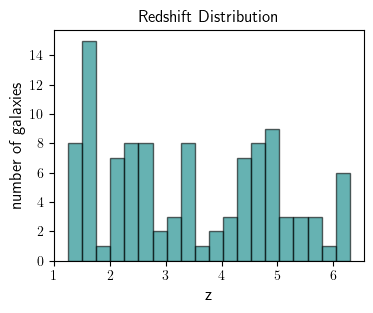

MSA_ID          ra        dec  old_z_phot   prism_z  prism_zq  Mgrat_z  \
2    10293  215.001656  53.005077       1.630       NaN       NaN    1.676   
6    11088  214.934206  52.826368       3.457       NaN       NaN    3.303   
7     1115  215.162818  53.073097       6.590       NaN       NaN    6.300   
11   11580  214.957140  52.872369       1.720       NaN       NaN    3.229   
13   11699  214.897723  52.836115       3.190  3.301238       4.0    3.301   

    Mgrat_zq  z_best  zq_best  ... Mgrat_7 prism_8  Mgrat_8  prism_9 Mgrat_9  \
2        4.0   1.676      4.0  ...   False   False    False    False   False   
6        4.0   3.303      4.0  ...   False   False    False    False   False   
7        4.0   6.300      4.0  ...    True   False    False    False   False   
11       4.0   3.229      4.0  ...   False   False    False    False   False   
13       4.0   3.301      4.0  ...   False   False    False    False   False   

   prism_10 Mgrat_10 prism_11 prism_12 prism_DD  
2     False    False    False    False    False  
6     False     True    False    False    False  
7     False    False    False    False    False  
11     True     True    False    False    False  
13    False    False    False    False    False  

[5 rows x 35 columns]

In [30]:
print(f'{len(z_log_df)} CEERS sources in sample')
plt.figure(figsize=(4,3))
plt.title('Redshift Distribution')
plt.xlabel('z',fontsize=12)
plt.ylabel('number of galaxies',fontsize=12)
plt.hist(z_log_df['allvet_Mgrat_z'],bins=20,color='teal',alpha=0.6,edgecolor='black')
plt.show()
z_log_df.head(5)

## Matching spectral info with NIRSpec data

In [31]:
NIRSpec_mgrat_fits = glob.glob('../data/spectra/CEERS/fits/nirspec_comb-mgrat_fits/*-masked.fits') 

# split fits str into source id str
ids = []
filenames = []
for path in NIRSpec_mgrat_fits:
    filename = os.path.basename(path)  
    try:
        id_string = filename.split('-')[1].split('_')[0]
        ids.append(int(id_string))
        filenames.append(filename)
    except IndexError:
        print(f"Failed to parse ID from: {filename}")
ids = np.array(ids).astype(int)

# saving as DataFrame
NIRSpec_mgrat_df = pd.DataFrame({
    'id': ids,
    'filenames': filenames,
    'fits': NIRSpec_mgrat_fits
})

# removing duplicates in CEERS mgrat data
NIRSpec_mgrat_df.drop_duplicates(subset=['id'],inplace=True)

# merging NIRSpec_mgrat_df with z_log_df based on MSA_ID
z_log_df['MSA_ID'] = z_log_df['MSA_ID'].astype(int)
NIRSpec_mgrat_df['id'] = NIRSpec_mgrat_df['id'].astype(int)
merged_df = pd.merge(z_log_df, NIRSpec_mgrat_df, left_on='MSA_ID', right_on='id', how='inner')

# creating final DataFrame for CEERS sample
NIRSpec_df = pd.DataFrame({
    'MSA_ID': merged_df['MSA_ID'],
    'FITS': merged_df['fits'],
    'Z_SPEC': merged_df['allvet_Mgrat_z']
})

# gathering fits data
data = []
for i in NIRSpec_df['FITS']:
    hdu = fits.open(i)
    data.append(hdu[1].data)
NIRSpec_df.drop(['FITS'], axis=1, inplace=True)  # don't need fits files anymore
NIRSpec_df.head()

MSA_ID  Z_SPEC
0   10293   1.676
1   11088   3.303
2    1115   6.300
3   11580   3.229
4   11699   3.301

## Retrieving RA and DEC info

In [32]:
hdu = fits.open('../data/spectra/CEERS/source_info/NIRSpec_Master_Catalog_V1.fits')

NIRSpec_catalog = pd.DataFrame()
NIRSpec_catalog['MSA_ID'] = list(hdu[1].data['MSA_ID']) # str ids
NIRSpec_catalog['RA'] = list(hdu[1].data['RA'])
NIRSpec_catalog['DEC'] = list(hdu[1].data['DEC'])

NIRSpec_catalog = NIRSpec_catalog.iloc[0:1330]                            # found some IDs had letters (e.g. ID = 'D01'), removing for now (can't convert to int)
NIRSpec_catalog['MSA_ID'] = NIRSpec_catalog['MSA_ID'].values.astype(int)  # converting str ids to int
NIRSpec_catalog.sort_values(by=['MSA_ID'],inplace=True)                   # sorting by int ids

subset_mask = np.isin(NIRSpec_catalog['MSA_ID'].values, NIRSpec_df['MSA_ID'].values)
ID_NIRSpec = NIRSpec_catalog['MSA_ID'][subset_mask]
RA_NIRSpec = NIRSpec_catalog['RA'][subset_mask]
DEC_NIRSpec = NIRSpec_catalog['DEC'][subset_mask]

# updating table
NIRSpec_df.insert(2, 'RA', RA_NIRSpec.values)
NIRSpec_df.insert(3, 'DEC', DEC_NIRSpec.values)
NIRSpec_df

MSA_ID  Z_SPEC          RA        DEC
0     10293   1.676  214.872556  52.875949
1     11088   3.303  214.806482  52.878827
2      1115   6.300  214.828968  52.875701
3     11580   3.229  214.878534  52.874142
4     11699   3.301  214.867247  52.836737
..      ...     ...         ...        ...
101    8736   1.554  215.216724  53.057855
102    8971   1.573  215.049454  52.941954
103    9156   2.054  215.069889  53.007982
104    9211   1.631  215.043555  52.989917
105    9238   1.742  215.082111  52.998676

[106 rows x 4 columns]

# Configuring spectral data

In [33]:
# converting wavelengths from [um] to [Angstroms]
wavs = [i['WAVELENGTH']*10000 for i in data]
fluxes = [flux_freq_to_flux_wav(i['FLUX'],i['WAVELENGTH']*10000) for i in data]
fluxes_err = [flux_freq_to_flux_wav(i['FLUX_ERROR'],i['WAVELENGTH']*10000) for i in data]

# masking nan vals
flux_nan = [~np.isnan(i) for i in fluxes]
flux_err_nan = [~np.isnan(i) for i in fluxes_err]
nan_mask = [flux_nan[i] & flux_err_nan[i] for i in range(len(flux_nan))]

# cleaned data
wavs_cleaned = [wavs[i][nan_mask[i]] for i in range(len(wavs))]
fluxes_cleaned = [fluxes[i][nan_mask[i]] for i in range(len(wavs))]
fluxes_err_cleaned = [fluxes_err[i][nan_mask[i]] for i in range(len(wavs))]

## Locating emission lines

In [34]:
# emission lines of interest
line_labels = ['Ha','Hb']
line_colors = ['red','blue']
Ha_rest = 6562.819 # [A]
Hb_rest = 4861.333 # [A]
Ha_line_obs = [restframe_to_obs(Ha_rest,z) for z in NIRSpec_df['Z_SPEC']]
Hb_line_obs = [restframe_to_obs(Hb_rest,z) for z in NIRSpec_df['Z_SPEC']]

# saving the location of observed emission line centers
Ha_center = []
Hb_center = []
for source in range(len(NIRSpec_df)):
    try:
            
        Ha_index = line_center_loc(wavs_cleaned[source],fluxes_cleaned[source],Ha_line_obs[source],source)
        Hb_index = line_center_loc(wavs_cleaned[source],fluxes_cleaned[source],Hb_line_obs[source],source)
        
        Ha_center.append(Ha_index)
        Hb_center.append(Hb_index)

    except Exception as e:
        print(f"Error processing source {source}: {e}")
        Ha_center.append(None)
        Hb_center.append(None)

# Plotting spectra

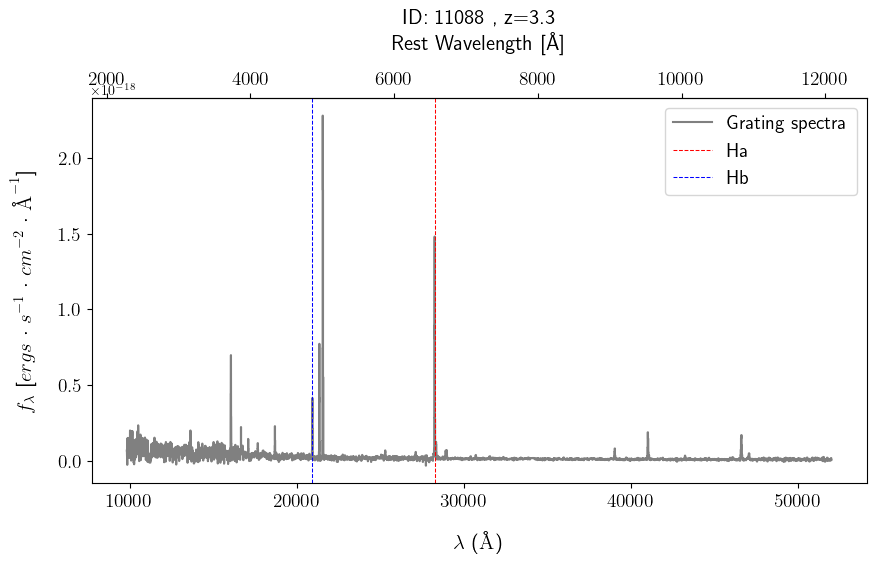

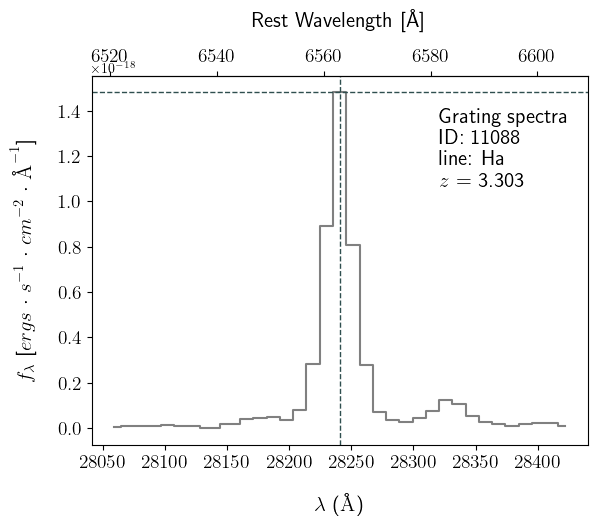

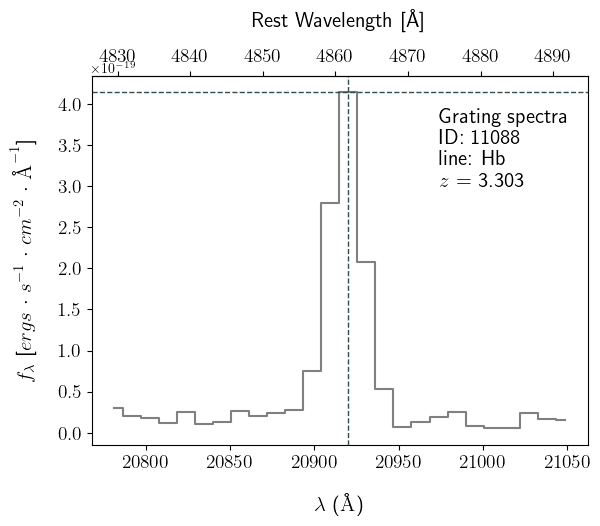

In [35]:
source = 1
CEERS_specific_spectra_plotting_func(NIRSpec_df['MSA_ID'][source], wavs_cleaned[source], fluxes_cleaned[source], NIRSpec_df['Z_SPEC'][source], data_label='Grating spectra', data_color='grey', 
                                     loc_obs_emission_lines=[Ha_line_obs[source],Hb_line_obs[source]], line_center_idx=[Ha_center[source],Hb_center[source]], emission_line_labels=line_labels, emission_line_colors=line_colors)

# Initial fitting with scipy.optimize.curve_fit()

## H-alpha initial fitting

In [36]:
# intializing dataframe
columns = ['MSA_ID','Z_SPEC', 'ppots', 'p0', 'wav_window', 'flux_window', 'flux_err_window', 'A', 'A_err', 'mu', 'sigma', 'A_NII', 'A_NII_err']
Ha_curve_fit_df = pd.DataFrame(columns=columns)

for source in range(len(NIRSpec_df)):
    try:

        new_row = initial_fits_Ha_CEERS(NIRSpec_df['MSA_ID'][source], wavs_cleaned[source], fluxes_cleaned[source], fluxes_err_cleaned[source], NIRSpec_df['Z_SPEC'][source], Ha_line_obs[source], Ha_center[source])

        # handle NaN values for amplitude
        if np.isnan(new_row[7]):
            print('NaN value for amplitude found:')
            print(new_row[2])  # printing best-fit parameters for source
        
        df_extended = pd.DataFrame(data=[new_row], columns=columns)
        Ha_curve_fit_df = pd.concat([Ha_curve_fit_df, df_extended],ignore_index=True)
    
    except Exception as e:
        print(f"Error processing source {source}: {e}")

Ha_curve_fit_df.head()

MSA_ID  Z_SPEC                                              ppots  \
0  10293   1.676  [8.067328847266918e-19, 5.795893281561327e-20,...   
1  11088   3.303  [1.4108979975673848e-18, 3.47576104423806e-20,...   
2   1115   6.300  [1.7785264161822164e-19, 5.1608402548901986e-2...   
3  11580   3.229  [6.514342479515638e-20, 7.790736662706439e-22,...   
4  11699   3.301  [3.7482485572522967e-19, 9.089087817599999e-21...   

                                                  p0  \
0  [9.368276481605745e-19, 1.8736552963211493e-19...   
1  [1.481173851179947e-18, 2.962347702359894e-19,...   
2  [1.5730120141673256e-19, 3.1460240283346514e-2...   
3  [7.077135352208706e-20, 1.4154270704417414e-20...   
4  [3.814599813562749e-19, 7.629199627125498e-20,...   

                                          wav_window  \
0  [17445.97127991015, 17452.298393934034, 17458....   
1  [28059.044052008045, 28069.721777720686, 28080...   
2  [47601.87457488187, 47619.6915830635, 47637.50...   
3  [27570.310517202717, 27580.892838156906, 27591...   
4  [28045.45524550129, 28056.098095817262, 28066....   

                                         flux_window  \
0  [1.339557475310239e-19, 1.319730864006706e-19,...   
1  [7.217726977070378e-21, 7.58257415915794e-21, ...   
2  [-1.1038835947847504e-20, 4.548769668530351e-2...   
3  [8.29764830927722e-21, 3.141401195981923e-21, ...   
4  [1.0931028576105312e-20, 1.7086719927103755e-2...   

                                     flux_err_window             A  \
0  [2.0143896637508487e-20, 2.3633116680624518e-2...  8.067329e-19   
1  [5.534136310942189e-21, 4.727308544606077e-21,...  1.410898e-18   
2  [4.627139974815265e-21, 4.982442601323615e-21,...  1.778526e-19   
3  [4.620786879305871e-21, 4.252007971607102e-21,...  6.514342e-20   
4  [4.681325793750713e-21, 5.5923693536416005e-21...  3.748249e-19   

          A_err            mu      sigma         A_NII     A_NII_err  
0  4.499240e-20  17565.324595   6.198196  5.795893e-20  1.677849e-20  
1  2.257082e-20  28240.097682  15.505518  3.475761e-20  6.709685e-21  
2  8.117895e-21  47915.263318  20.026024  5.160840e-21  2.226770e-21  
3  5.381888e-21  27751.213447  13.944239  7.790737e-22  1.584898e-21  
4  6.963552e-21  28237.512243  13.126034  9.089088e-21  2.076095e-21

## H-beta initial fitting

In [37]:
# intializing dataframe
columns = ['MSA_ID','Z_SPEC', 'ppots', 'p0', 'wav_window', 'flux_window', 'flux_err_window', 'A', 'A_err', 'mu', 'sigma']
Hb_curve_fit_df = pd.DataFrame(columns=columns)

for source in range(len(NIRSpec_df['MSA_ID'])):
    try:
        new_row = initial_fits_Hb_CEERS(NIRSpec_df['MSA_ID'][source], wavs_cleaned[source], fluxes_cleaned[source], fluxes_err_cleaned[source], NIRSpec_df['Z_SPEC'][source], Hb_line_obs[source], Hb_center[source]) 

        # handle NaN values for amplitude
        if np.isnan(new_row[7]):
            print('NaN value for amplitude found:')
            print(new_row[2])  # printing best-fit parameters for source
        
        df_extended = pd.DataFrame(data=[new_row], columns=columns)
        Hb_curve_fit_df = pd.concat([Hb_curve_fit_df, df_extended],ignore_index=True)
    
    except Exception as e:
        print(f"Error processing source {source}: {e}")

Hb_curve_fit_df.head()

MSA_ID  Z_SPEC                                              ppots  \
0  10293   1.676  [2.7637883875078675e-19, 13012.722463191876, 6...   
1  11088   3.303  [3.9945064769583105e-19, 20918.813796859027, 1...   
2   1115   6.300  [5.783884813301087e-20, 35499.602612666, 15.61...   
3  11580   3.229  [3.805575375880271e-20, 20559.744907624525, -9...   
4  11699   3.301  [1.0280606345477594e-19, 20914.74458340286, 14...   

                                                  p0  \
0  [4.34694637328887e-19, 13013.805372334755, 72....   
1  [4.1394419669317705e-19, 20920.269617757174, 1...   
2  [5.594487191430189e-20, 35493.550761903505, 17...   
3  [4.044964353571168e-20, 20562.67084197644, 33....   
4  [1.0900267449412536e-19, 20918.05456509244, 13...   

                                          wav_window  \
0  [12924.83158885563, 12931.18707660346, 12937.5...   
1  [20781.375248616154, 20792.059394147815, 20802...   
2  [35296.60956186185, 35314.51383615961, 35332.4...   
3  [20424.5547322851, 20435.179357324007, 20445.8...   
4  [20779.573826390268, 20790.226186919248, 20800...   

                                         flux_window  \
0  [2.093621463433951e-19, 2.1301264273726526e-19...   
1  [3.0556917372716284e-20, 2.008141295608656e-20...   
2  [-9.471742910644879e-22, -4.742002929516749e-2...   
3  [1.3184496632590594e-20, 1.035865348496696e-20...   
4  [1.415001384927917e-20, 1.896449108065487e-20,...   

                                     flux_err_window             A  \
0  [2.1352597617089642e-20, 2.1243955804034532e-2...  2.763788e-19   
1  [5.9799408305948676e-21, 5.483229344001797e-21...  3.994506e-19   
2  [3.953952887071161e-21, 3.9070150976251074e-21...  5.783885e-20   
3  [4.637410541972724e-21, 4.835348636553751e-21,...  3.805575e-20   
4  [3.477061369354047e-21, 3.891564276824716e-21,...  1.028061e-19   

          A_err            mu      sigma  
0  4.767812e-20  13012.722463   6.223460  
1  6.815215e-21  20918.813797  14.275305  
2  8.875558e-21  35499.602613  15.616959  
3  1.230802e-20  20559.744908  -9.279168  
4  5.787246e-21  20914.744583  14.473957

## Initial fitting results

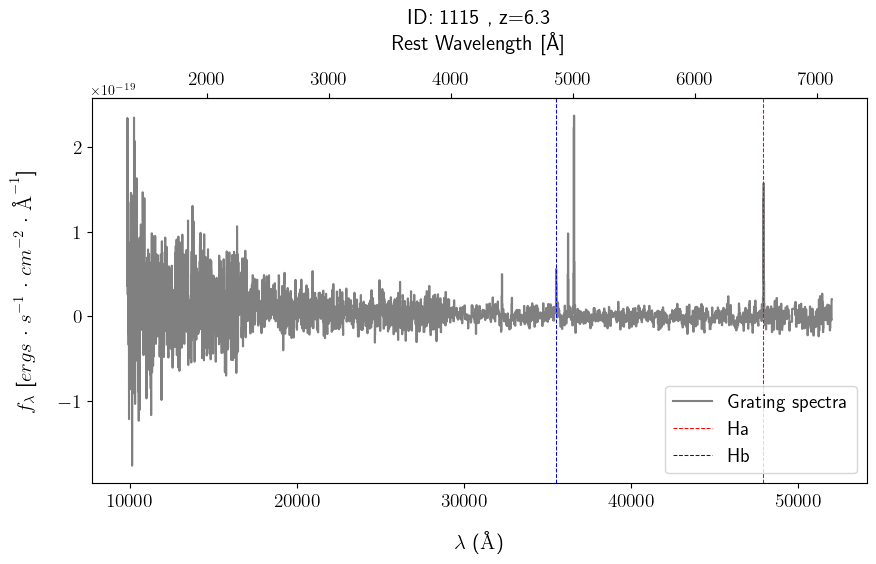

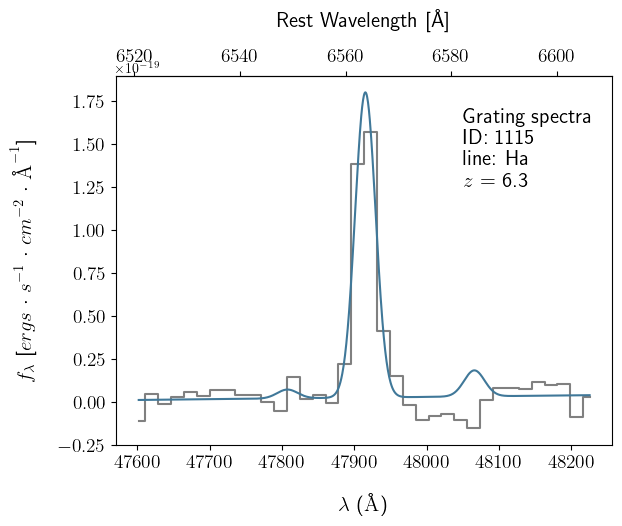

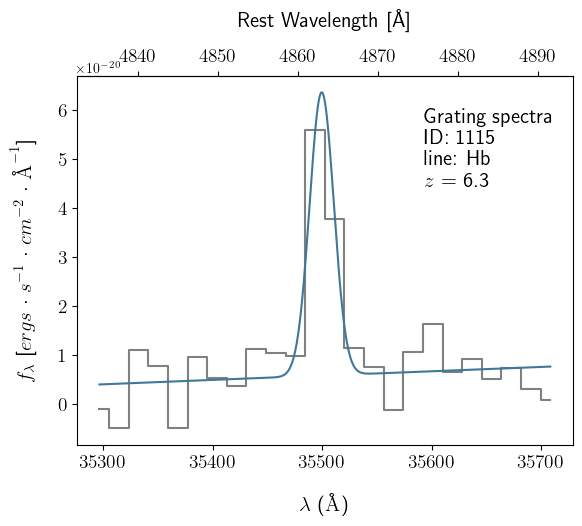

In [38]:
source = 2
CEERS_specific_spectra_plotting_func(NIRSpec_df['MSA_ID'][source], wavs_cleaned[source], fluxes_cleaned[source], NIRSpec_df['Z_SPEC'][source], data_label='Grating spectra', data_color='grey', 
                                     loc_obs_emission_lines=[Ha_line_obs[source],Hb_line_obs[source]], line_center_idx=[Ha_center[source],Hb_center[source]], emission_line_labels=line_labels, emission_line_colors=line_colors,
                                     line_model_outputs=[Ha_curve_fit_df['ppots'][source],Hb_curve_fit_df['ppots'][source]], fit='curve_fit')

# Final fitting with MCMC

## H-alpha final fitting

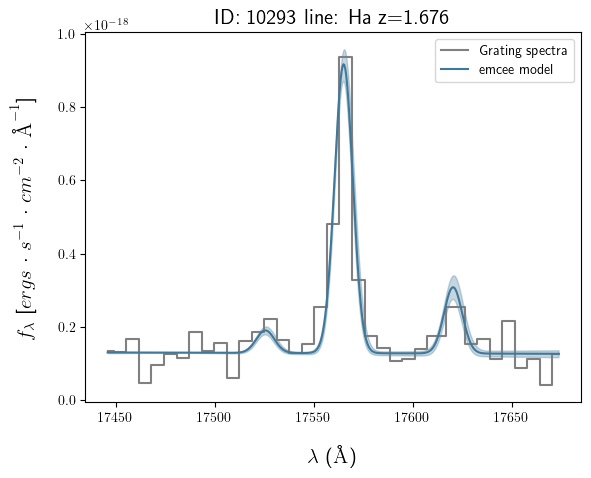

source #0


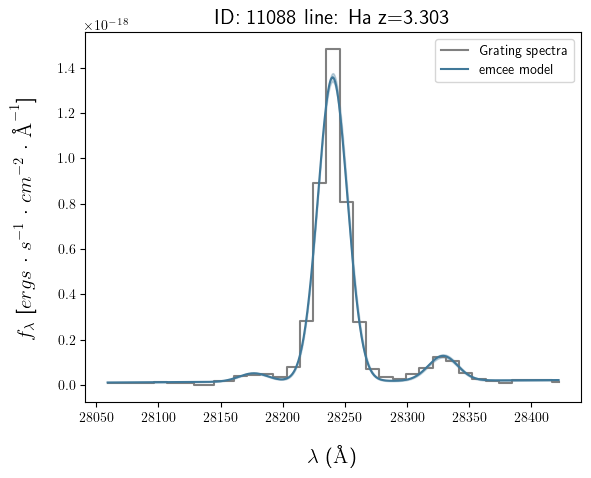

source #1


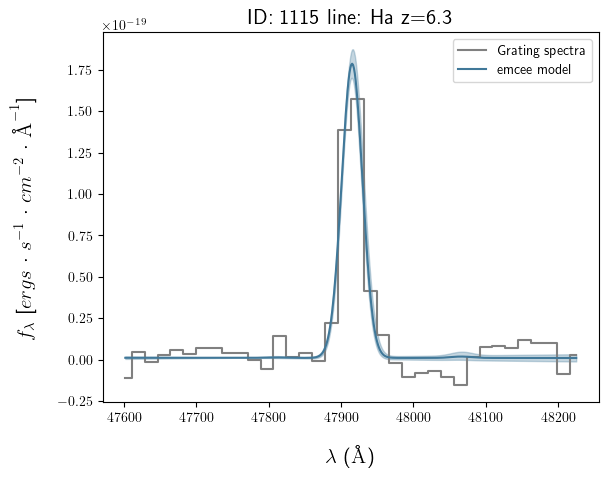

source #2


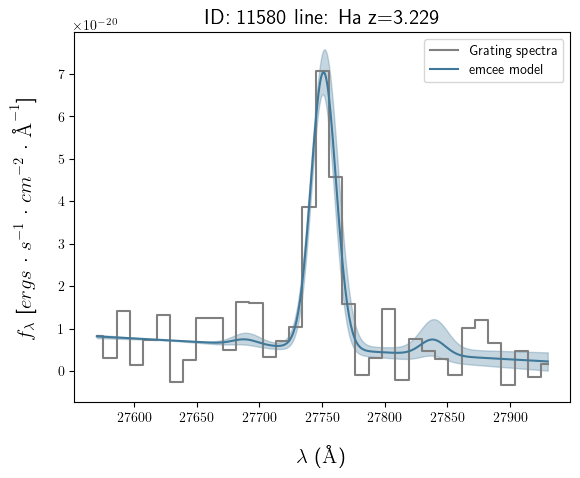

source #3


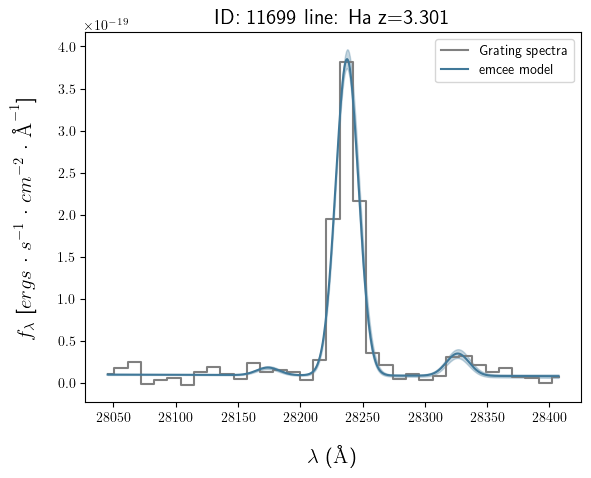

source #4


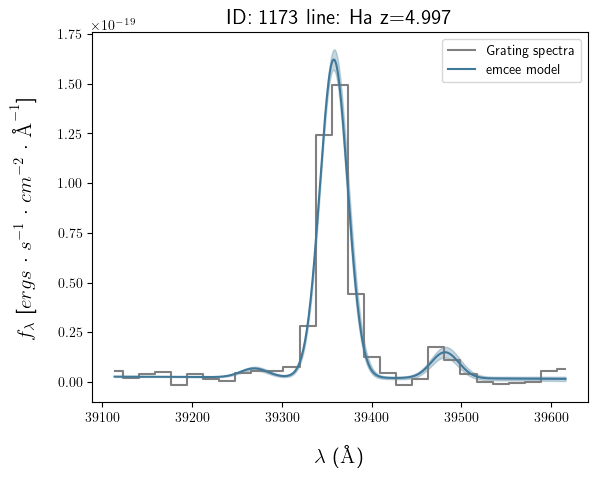

source #5


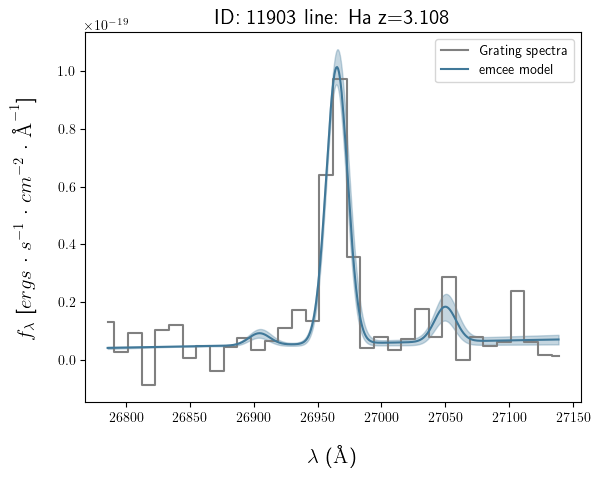

source #6


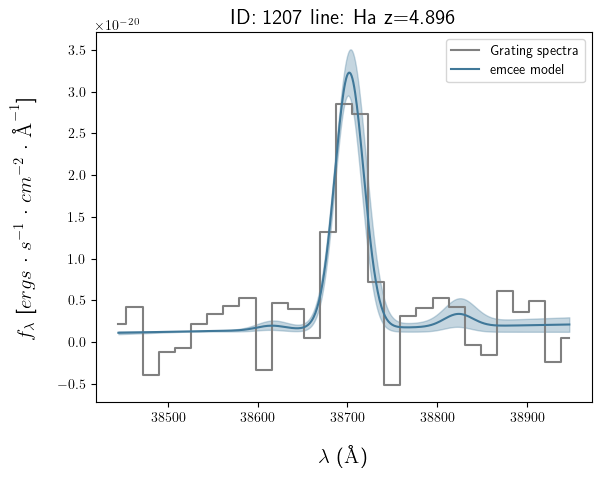

source #7


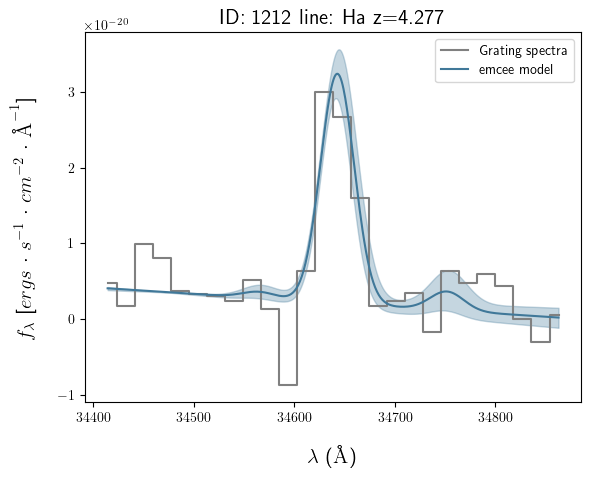

source #8


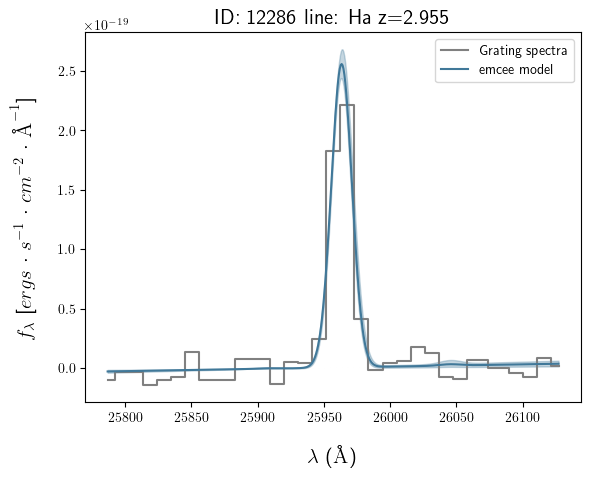

source #9


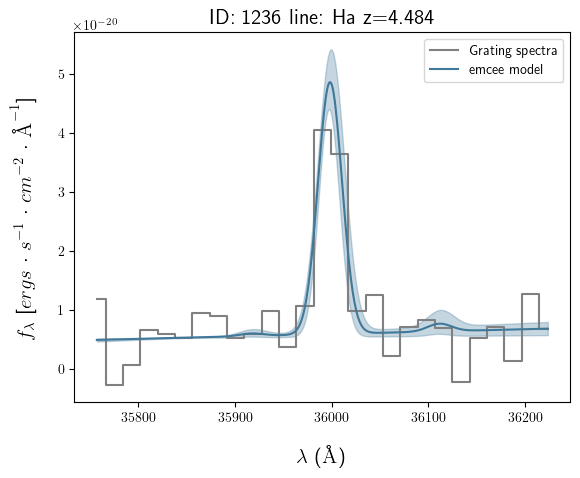

source #10


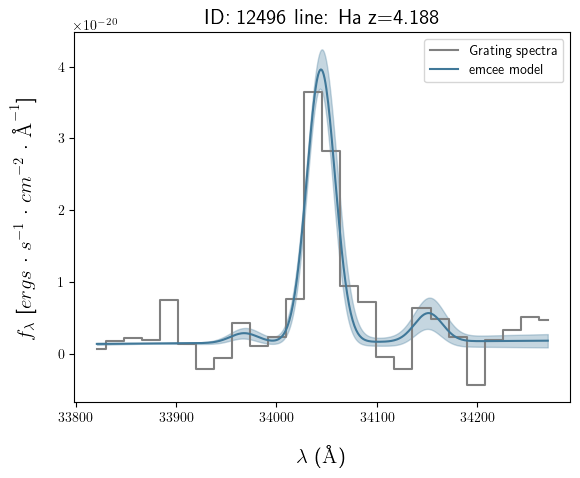

source #11


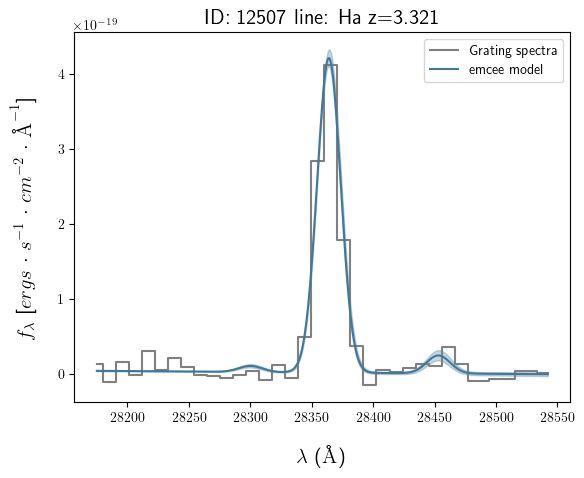

source #12


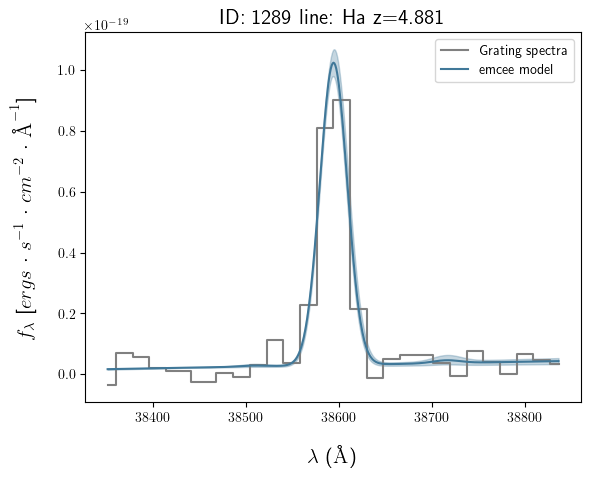

source #13


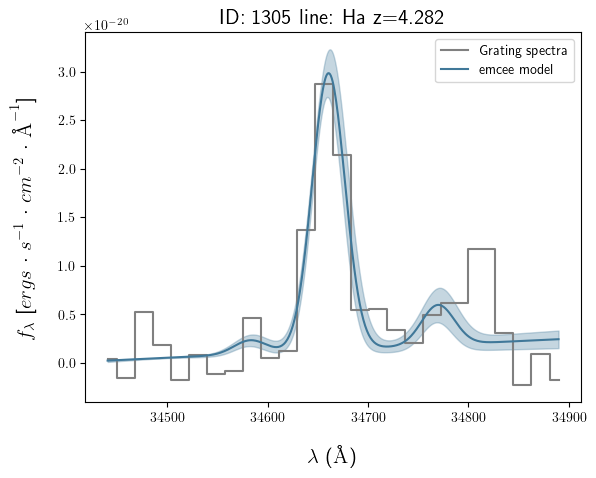

source #14


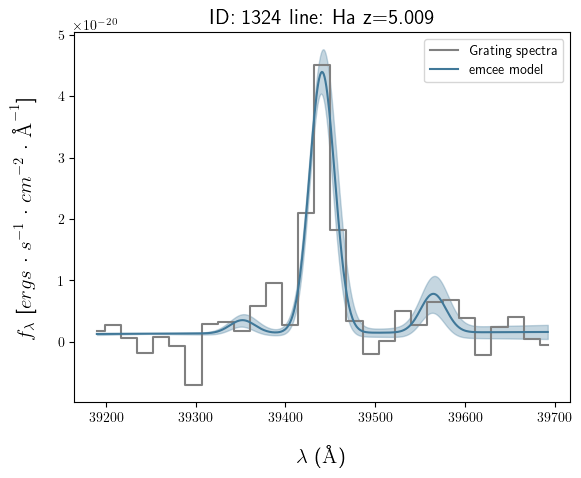

source #15


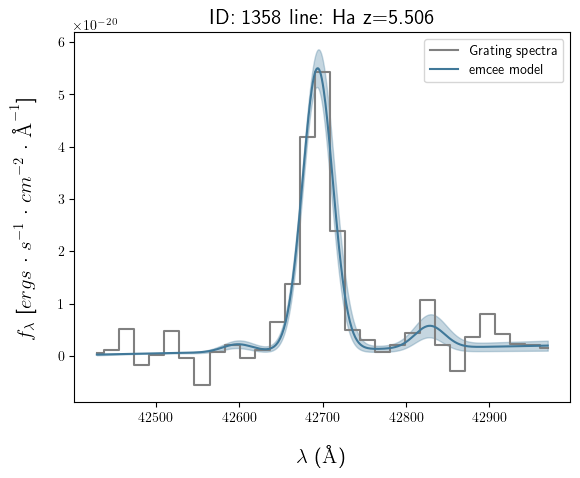

source #16


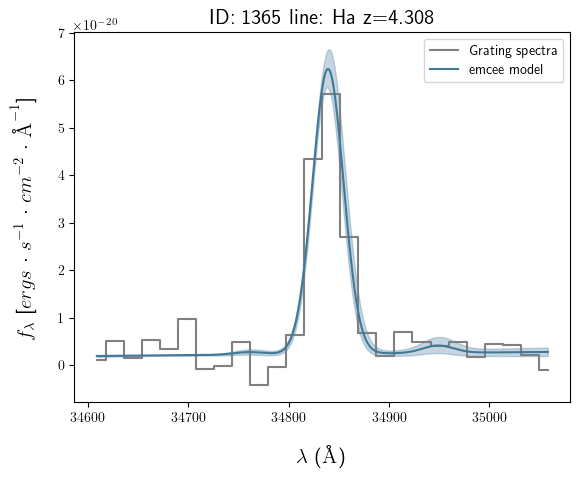

source #17


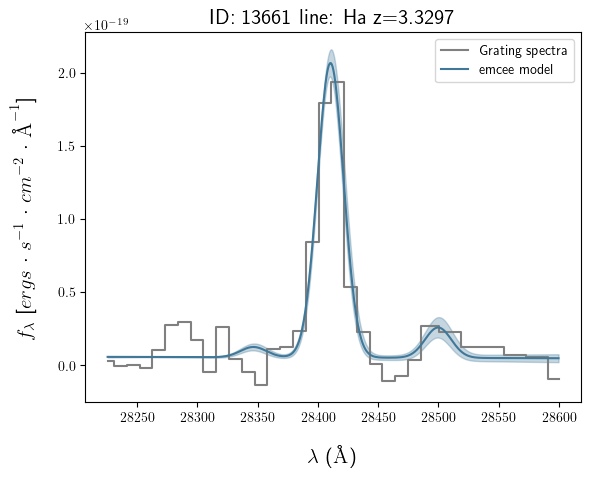

source #18


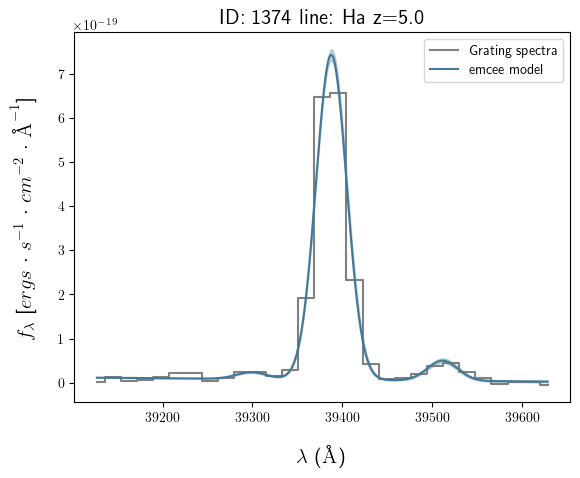

source #19


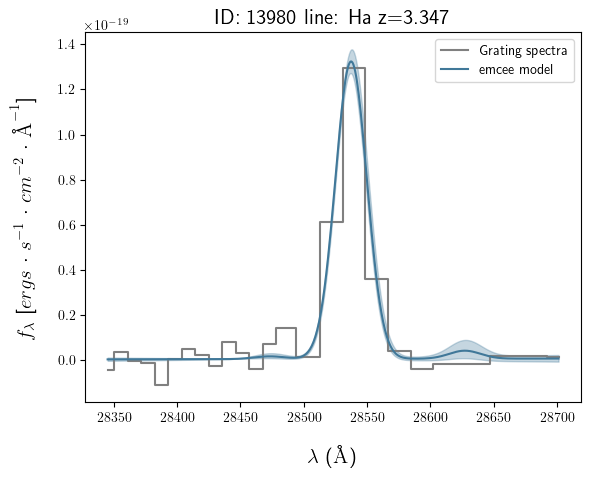

source #20


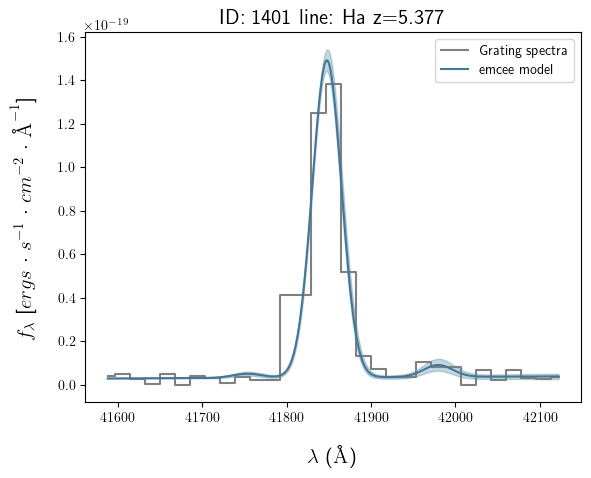

source #21


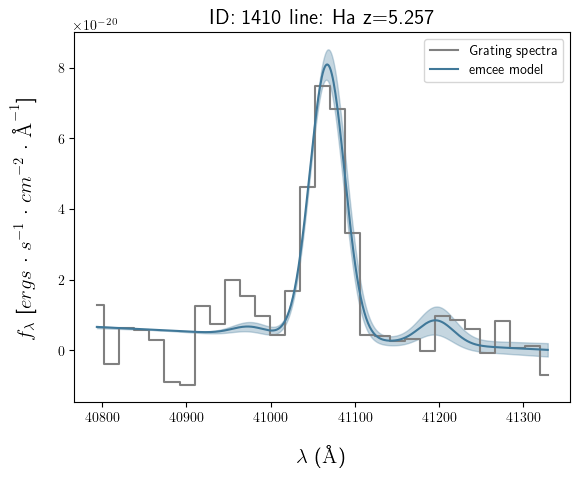

source #22


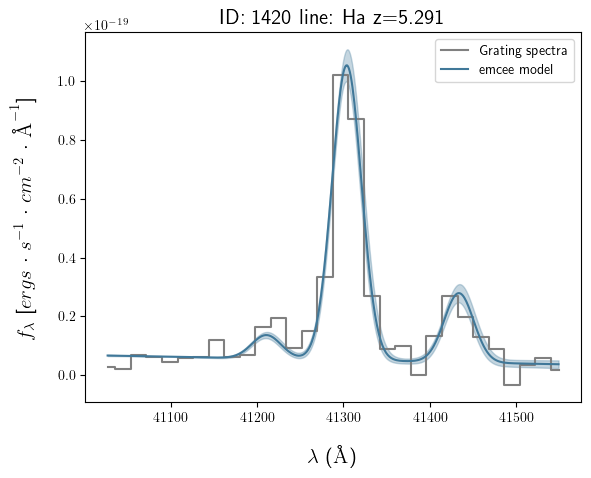

source #23


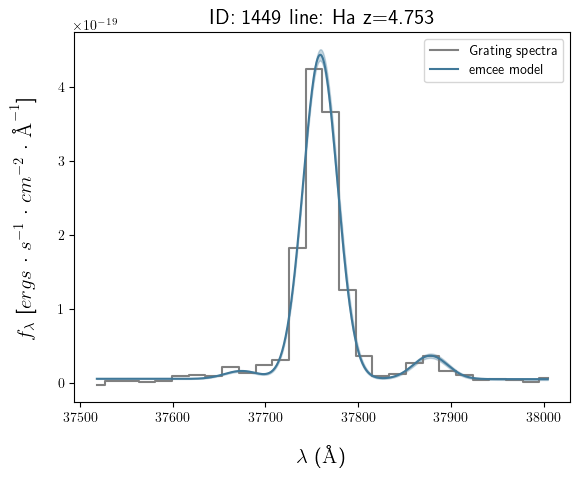

source #24


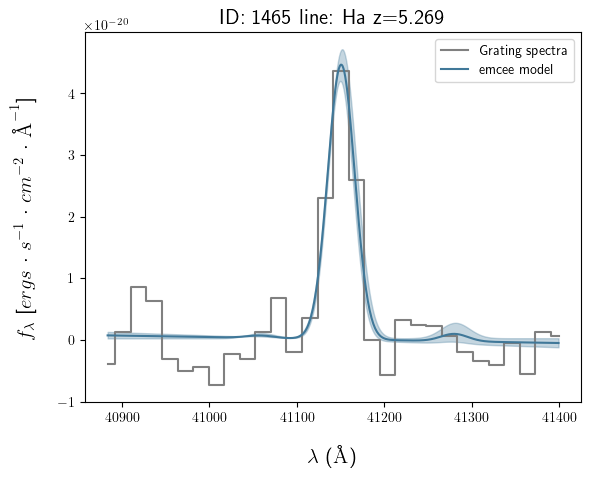

source #25


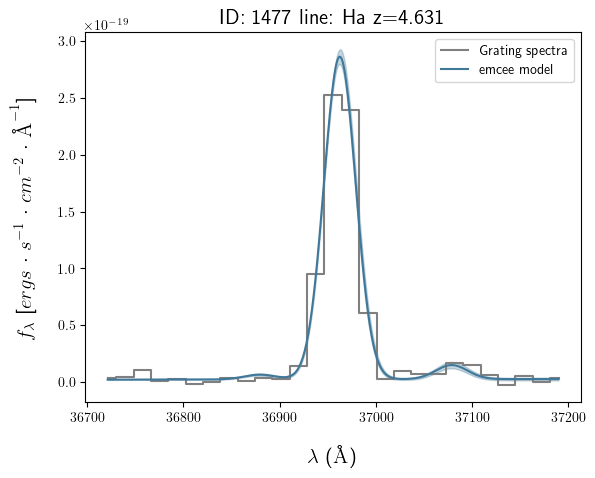

source #26


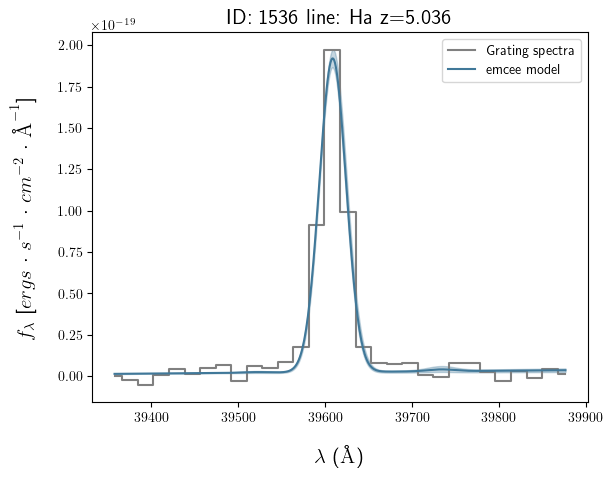

source #27


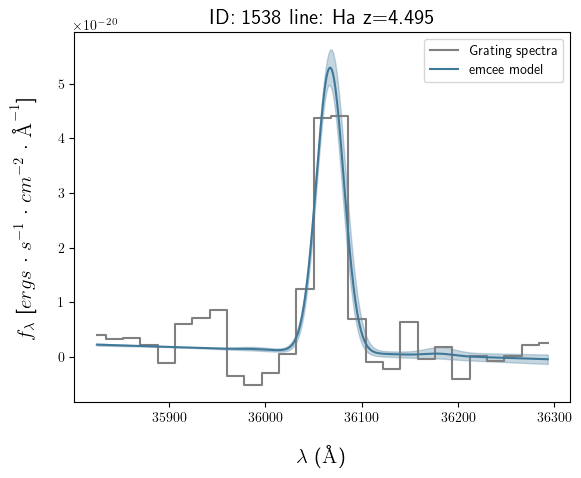

source #28


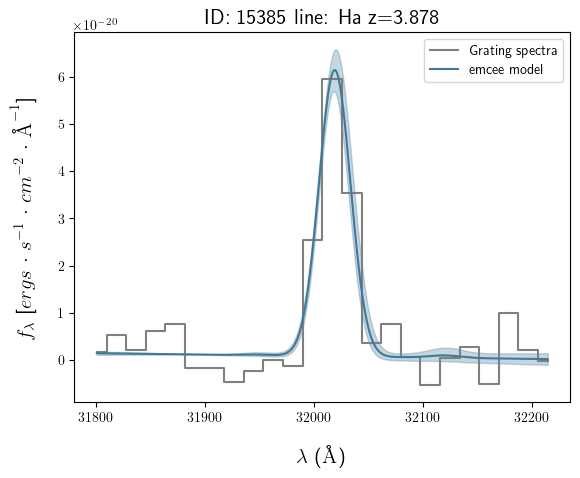

source #29


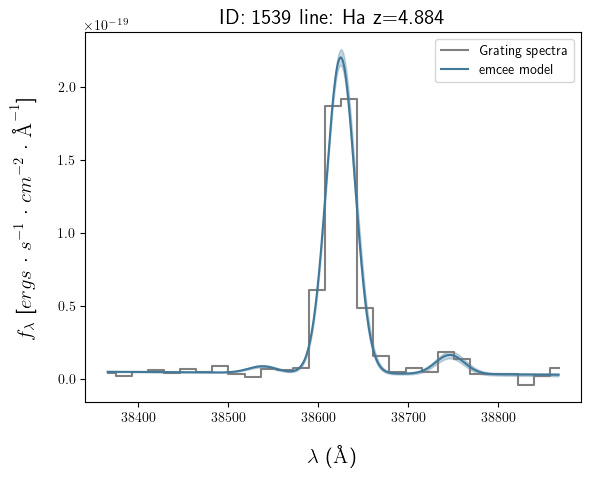

source #30


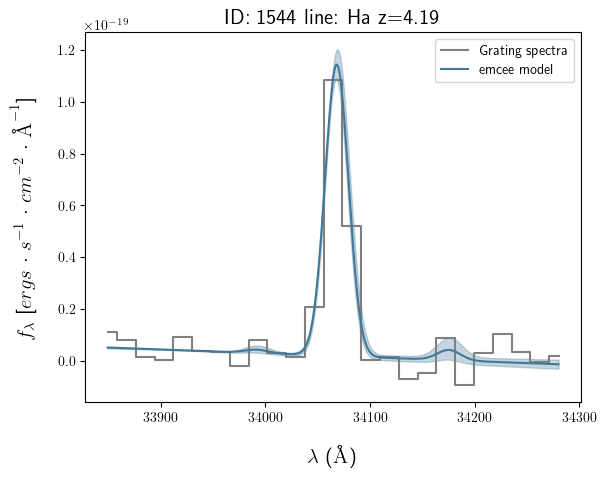

source #31


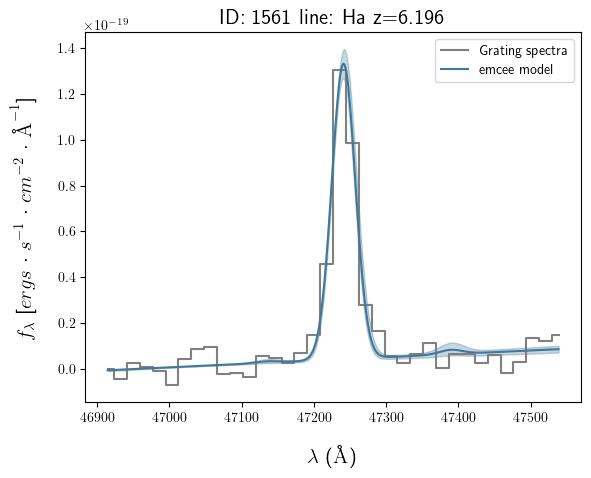

source #32


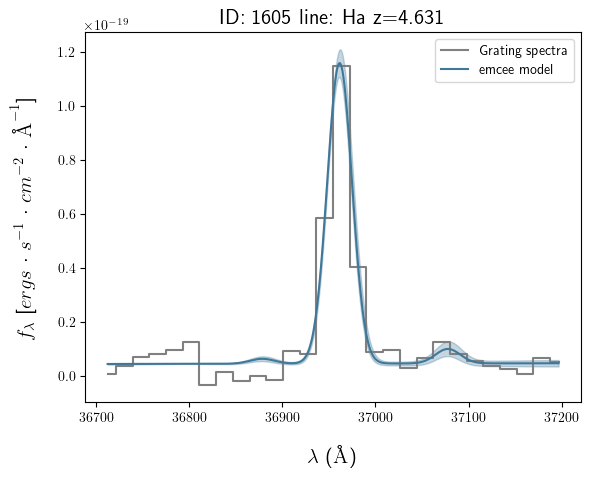

source #33


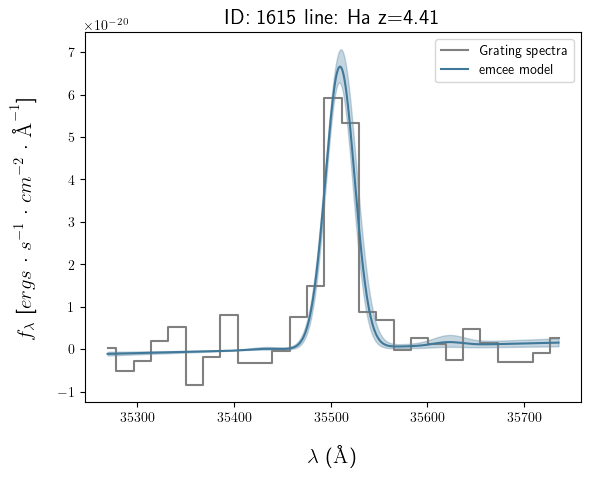

source #34


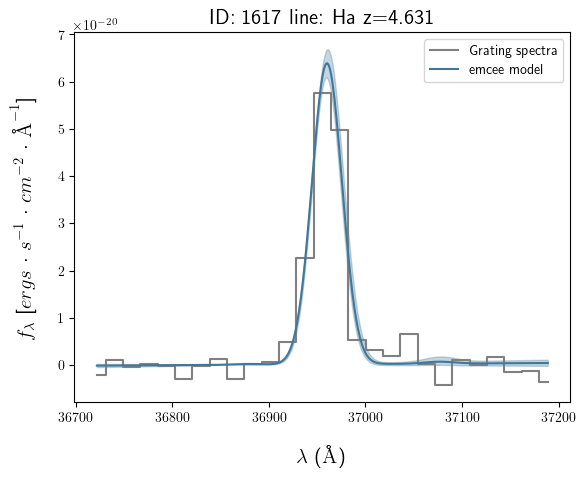

source #35


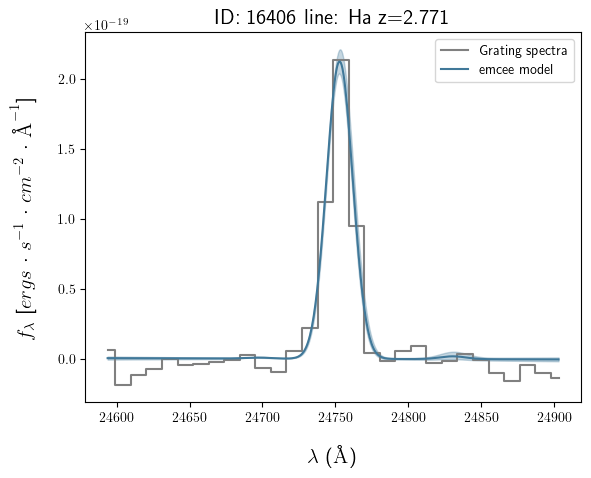

source #36


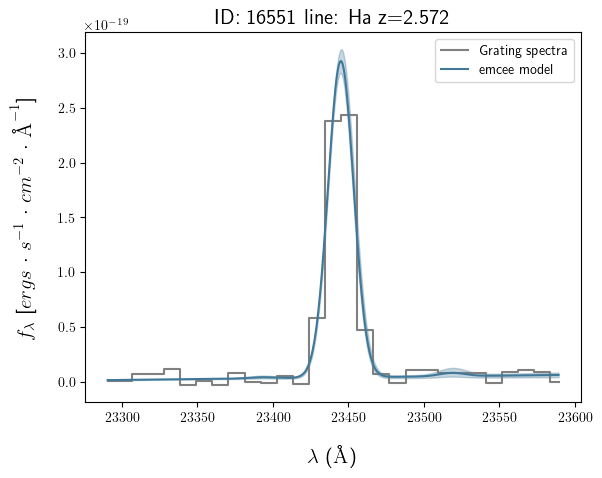

source #37


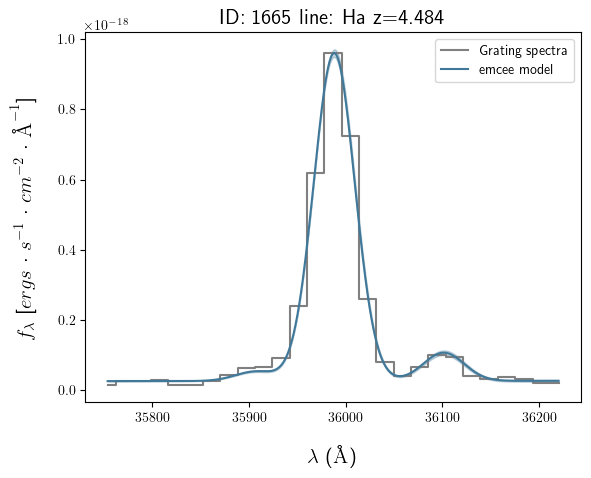

source #38


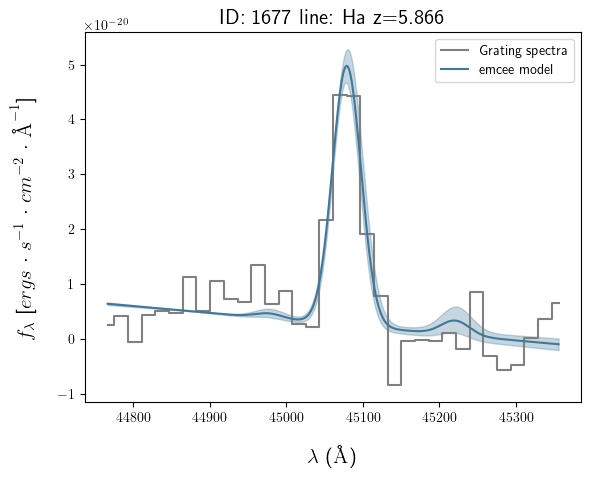

source #39


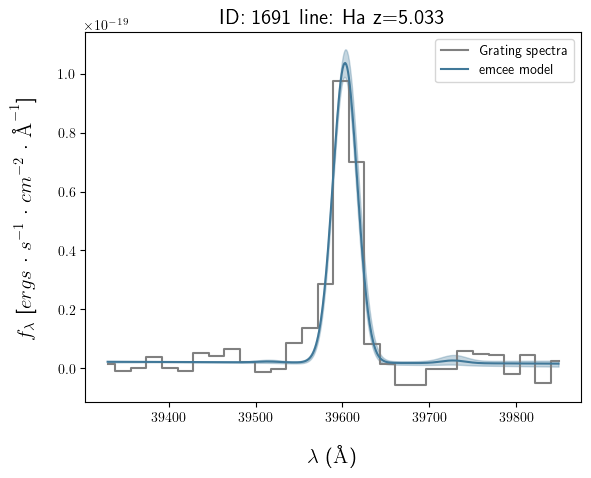

source #40


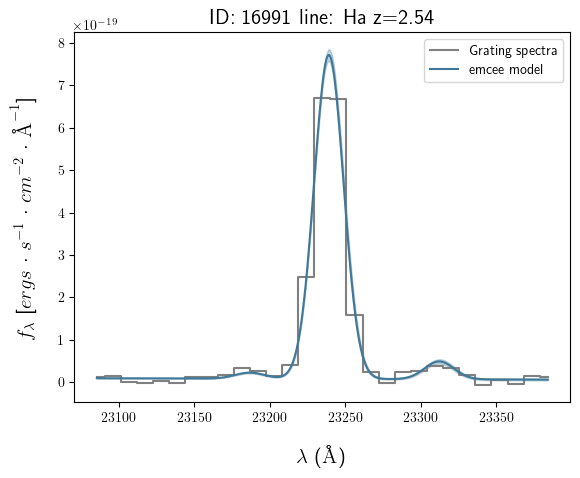

source #41


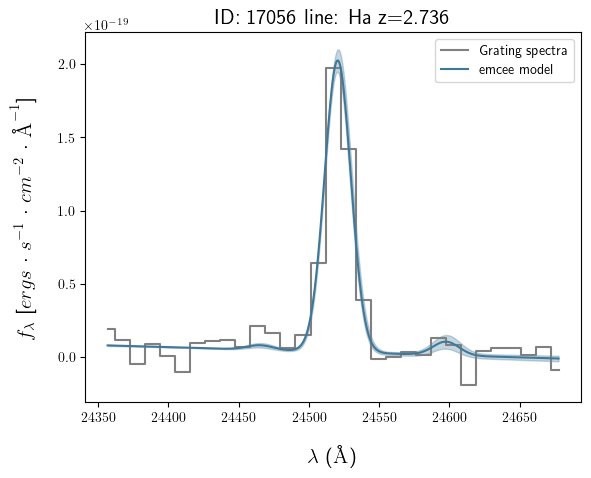

source #42


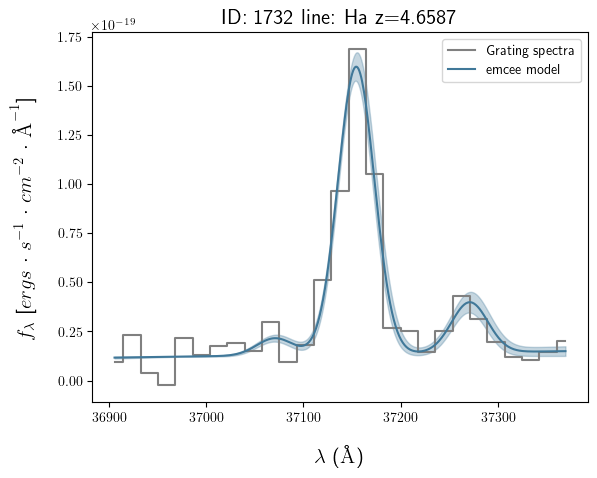

source #43


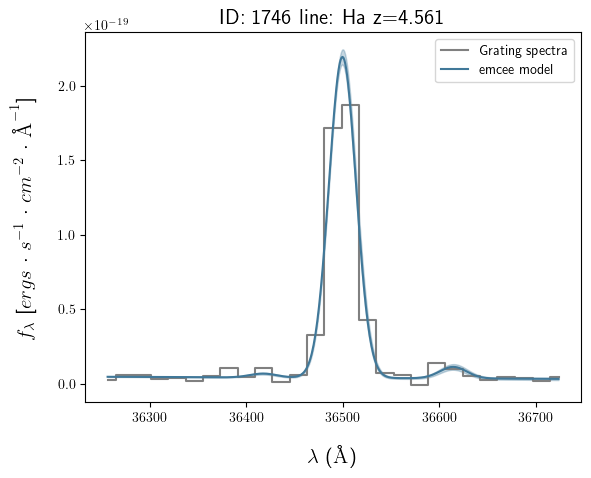

source #44


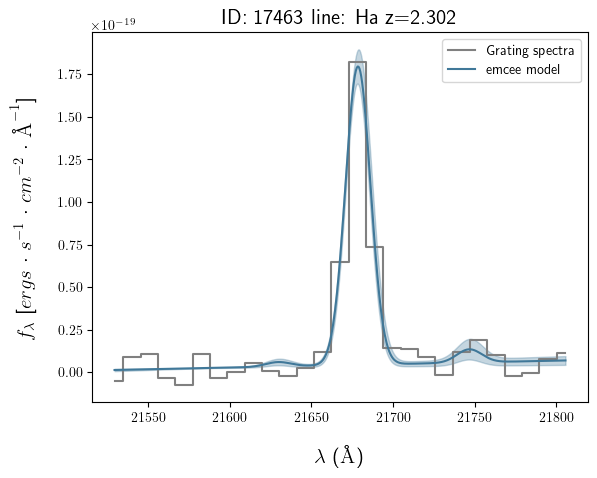

source #45


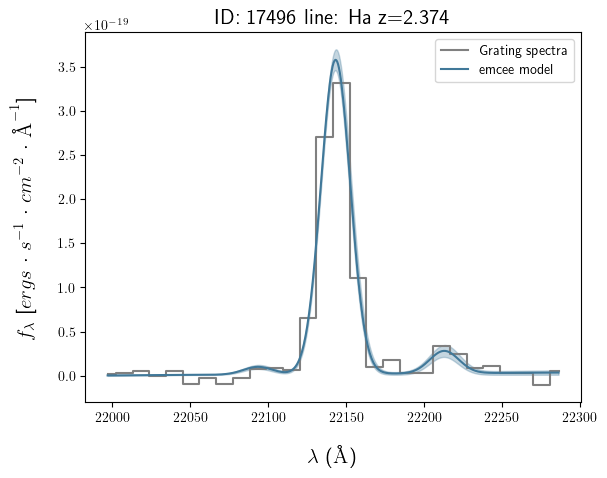

source #46


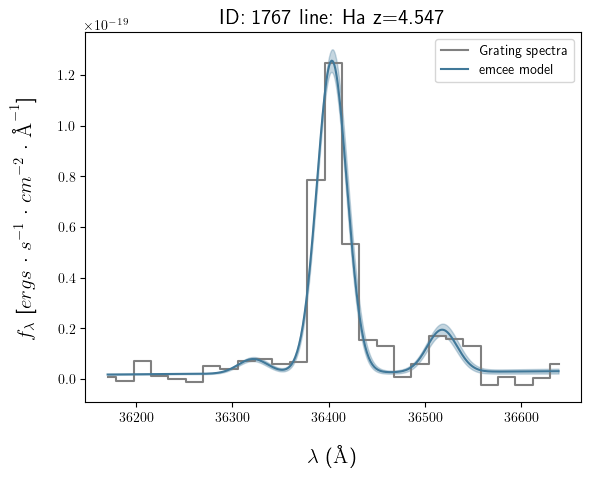

source #47


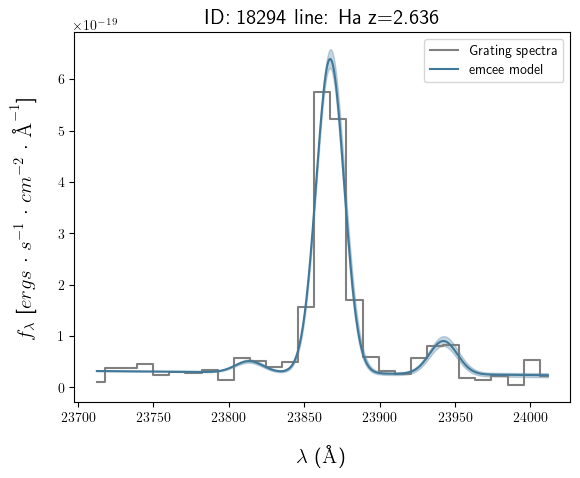

source #48


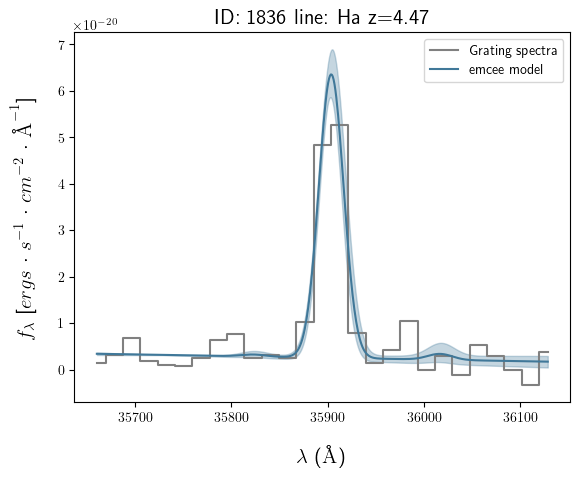

source #49


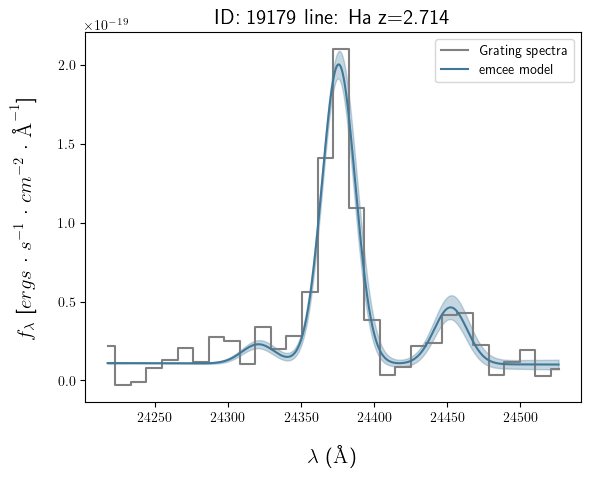

source #50


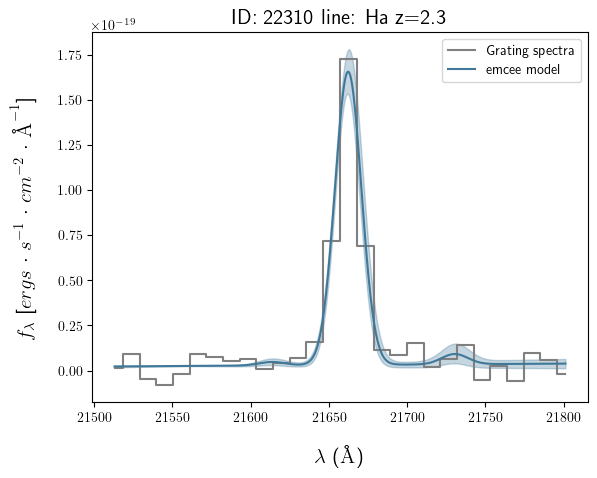

source #51


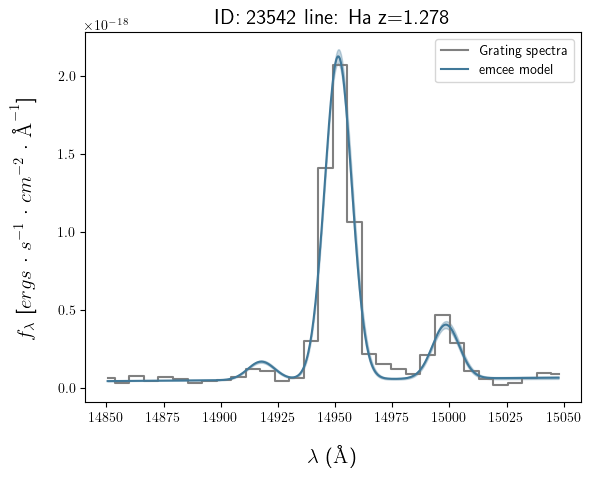

source #52


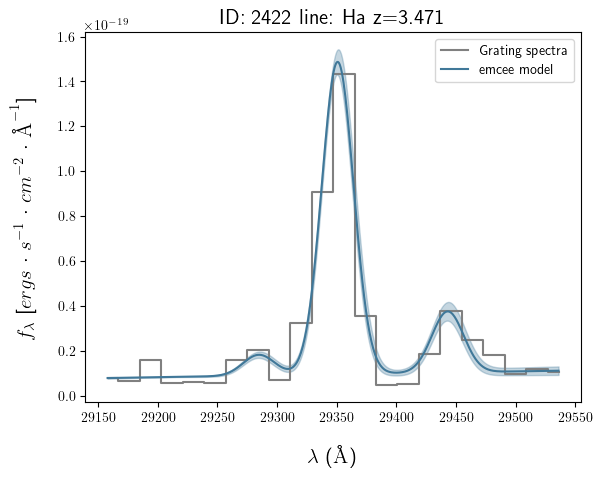

source #53


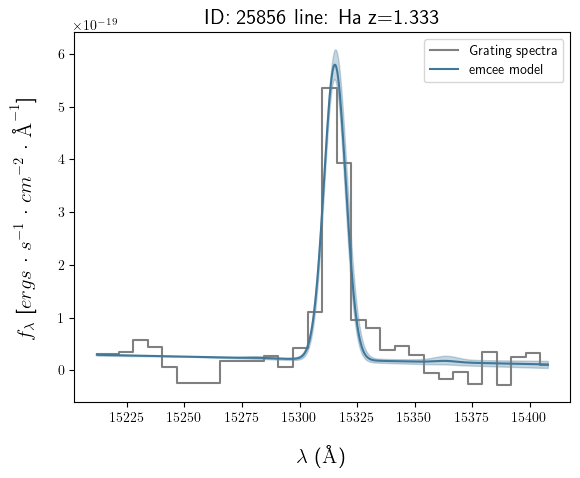

source #54


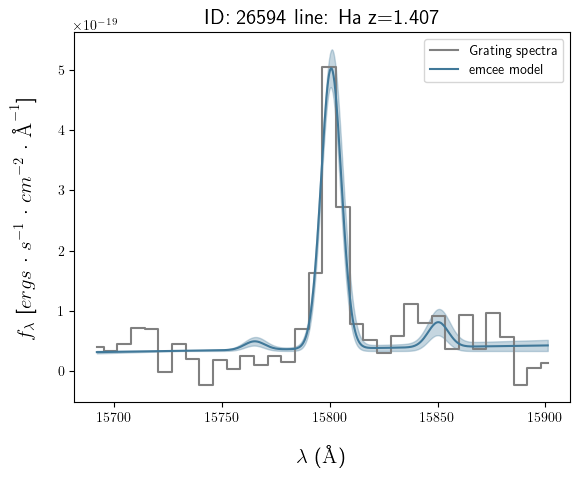

source #55


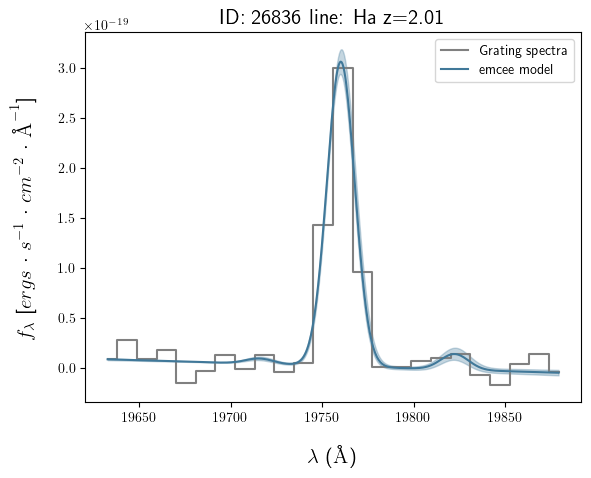

source #56


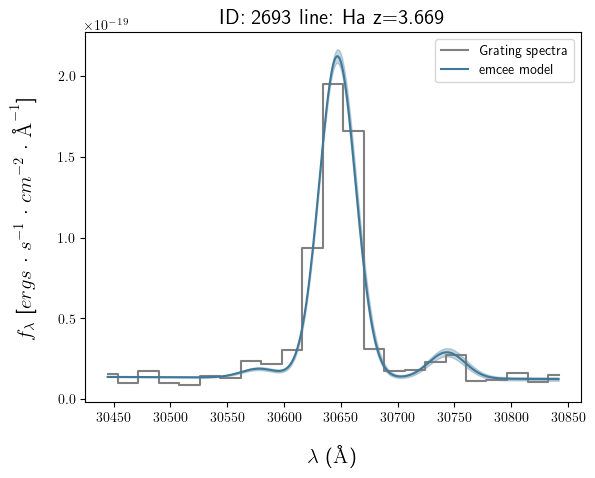

source #57


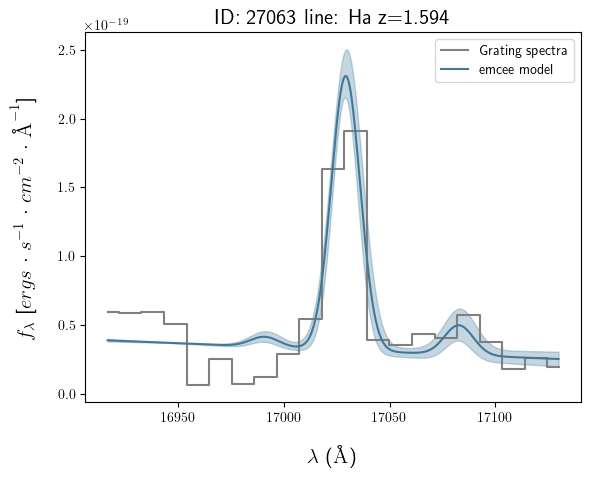

source #58


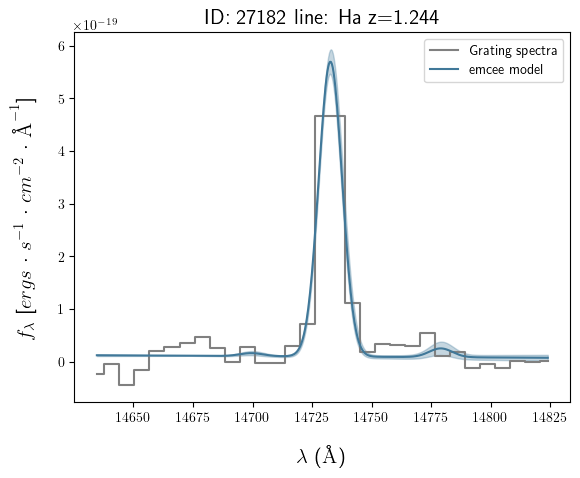

source #59


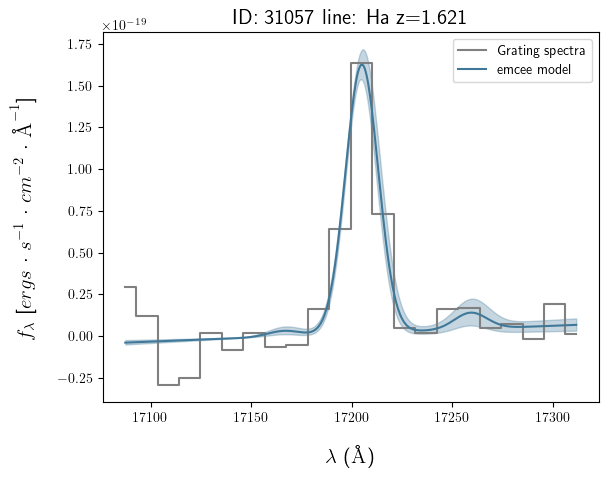

source #60


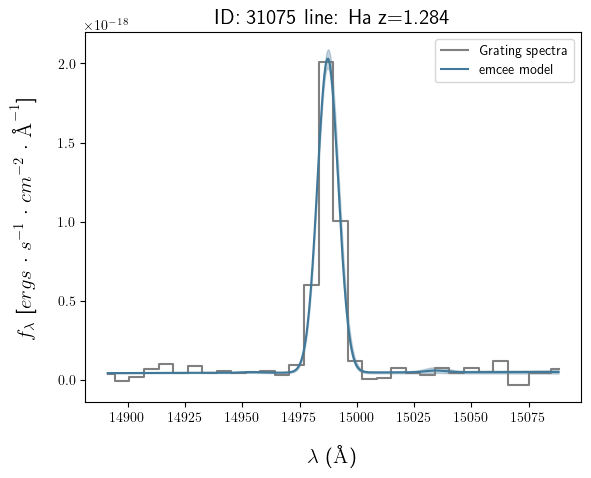

source #61


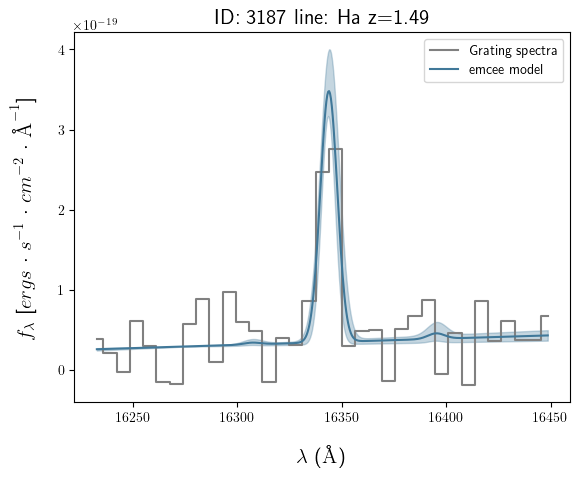

source #62


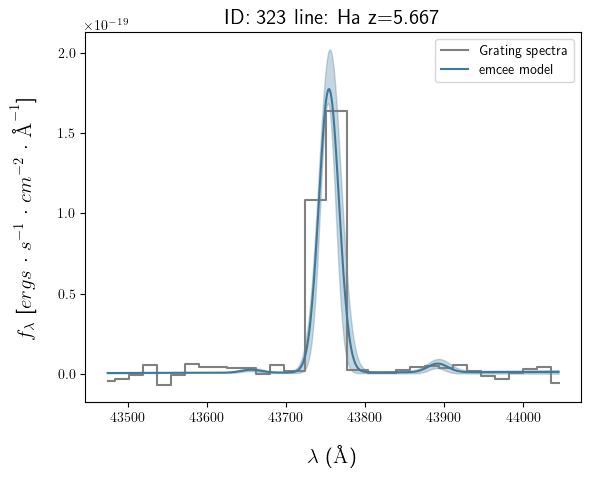

source #63


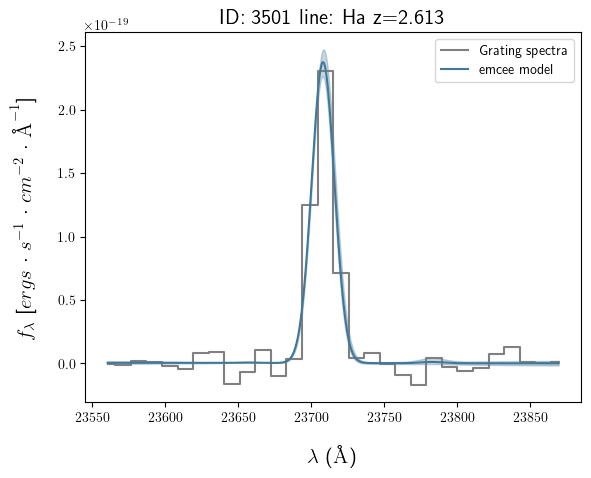

source #64


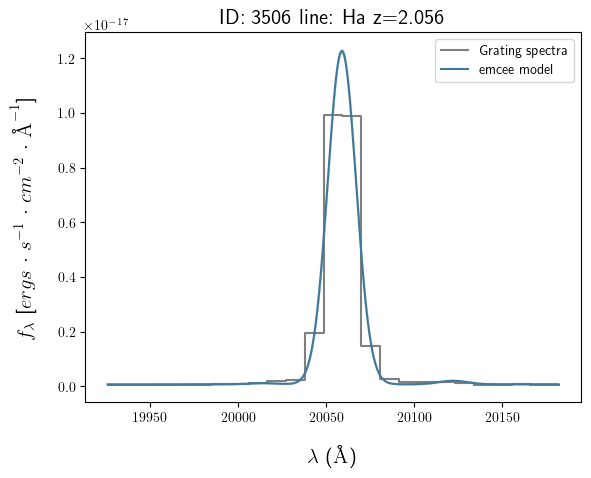

source #65


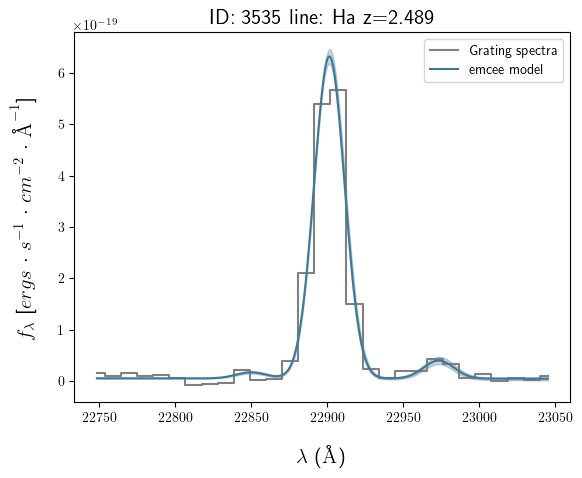

source #66


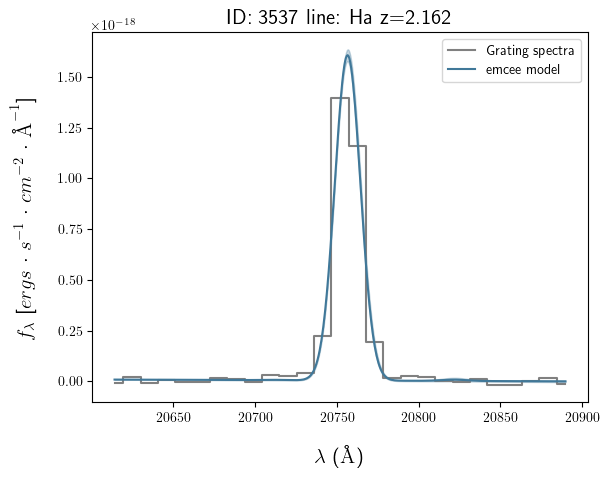

source #67


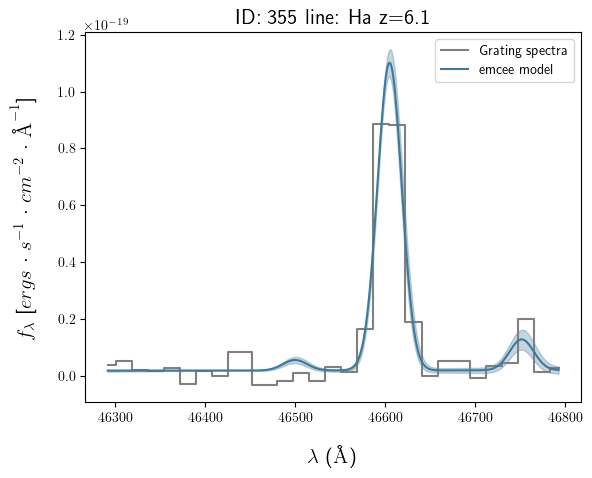

source #68


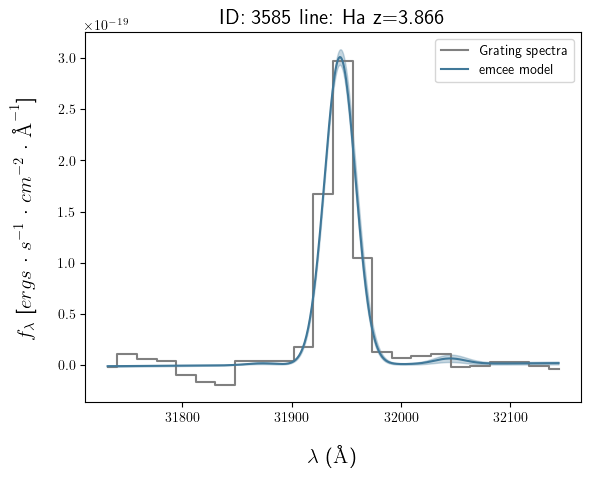

source #69


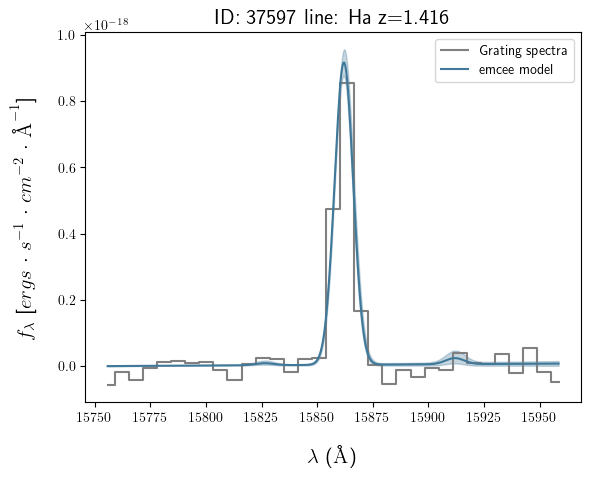

source #70


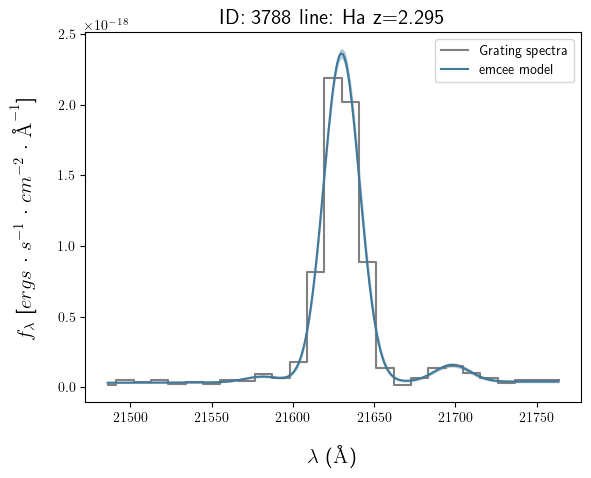

source #71


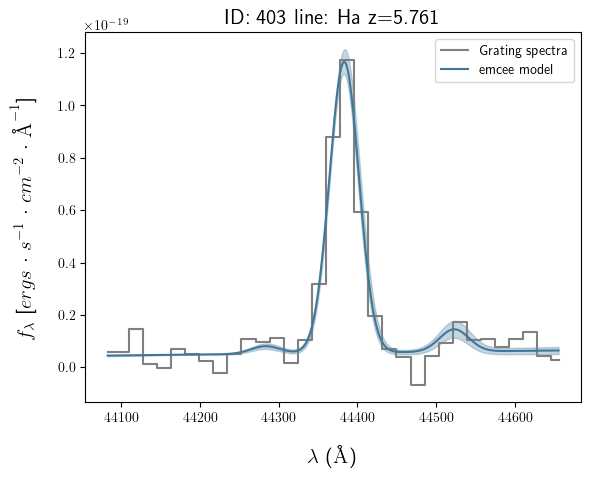

source #72


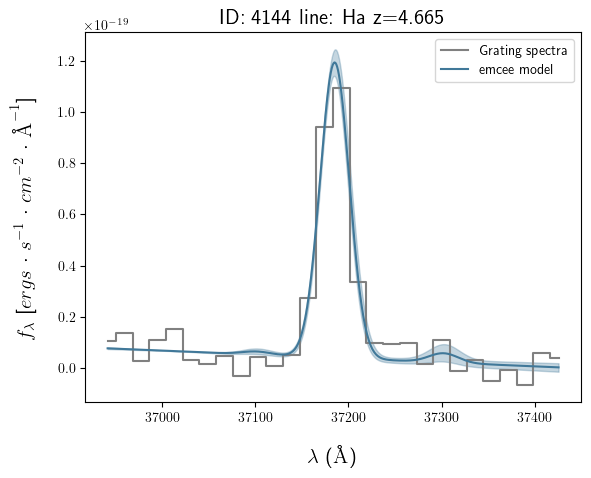

source #73


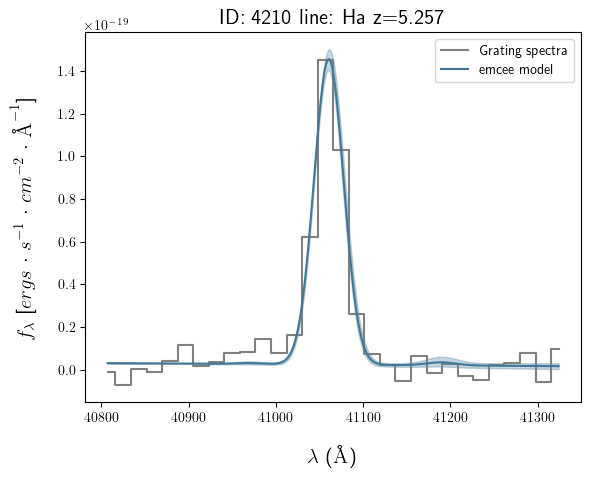

source #74


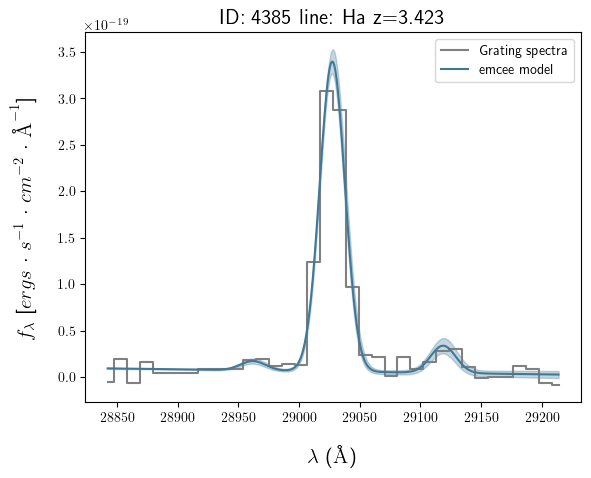

source #75


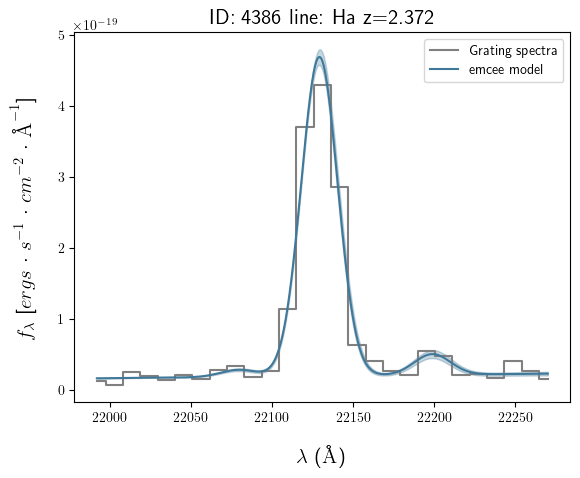

source #76


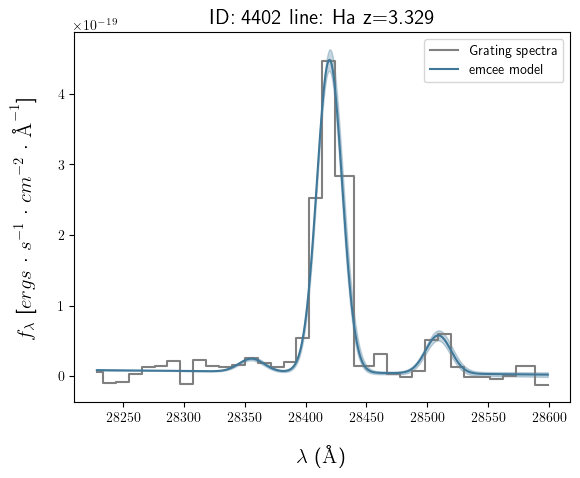

source #77


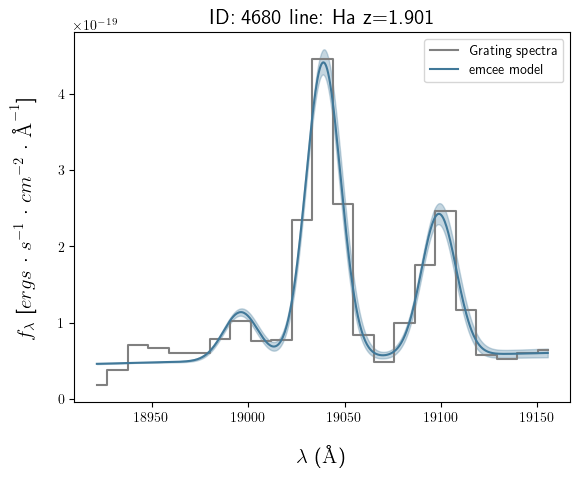

source #78


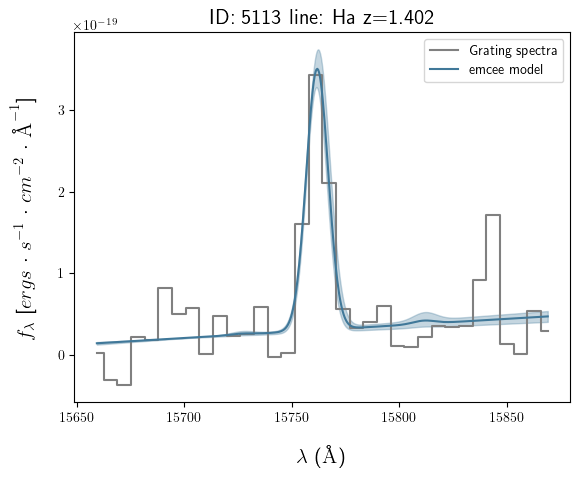

source #79


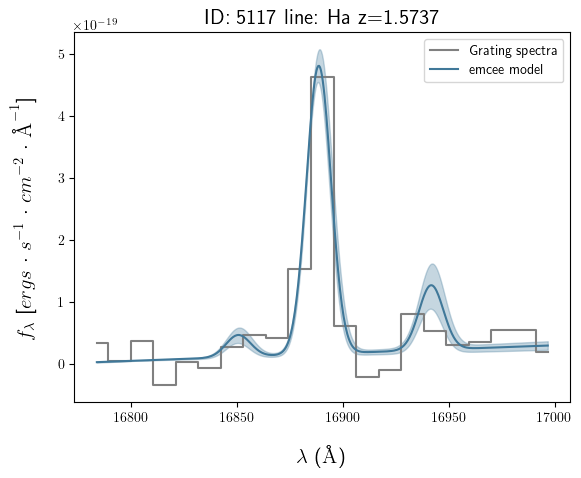

source #80


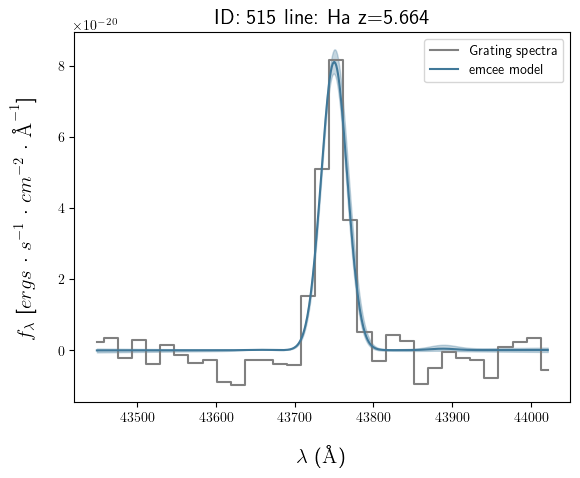

source #81


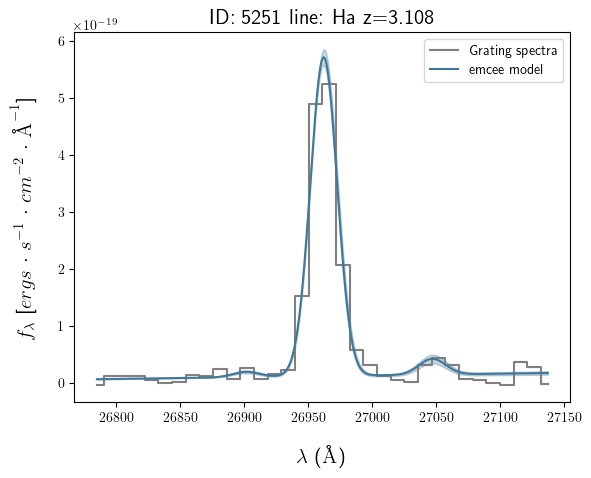

source #82


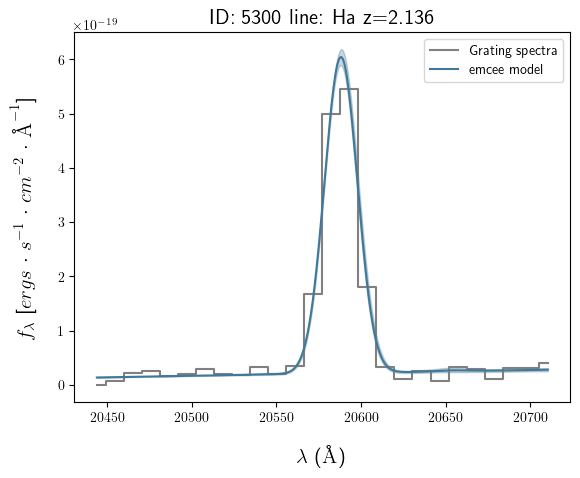

source #83


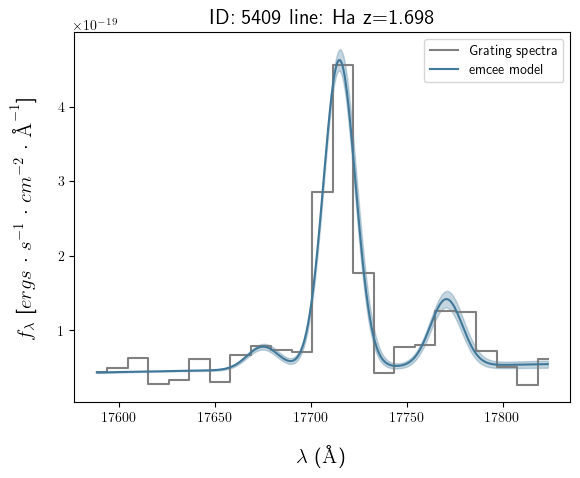

source #84


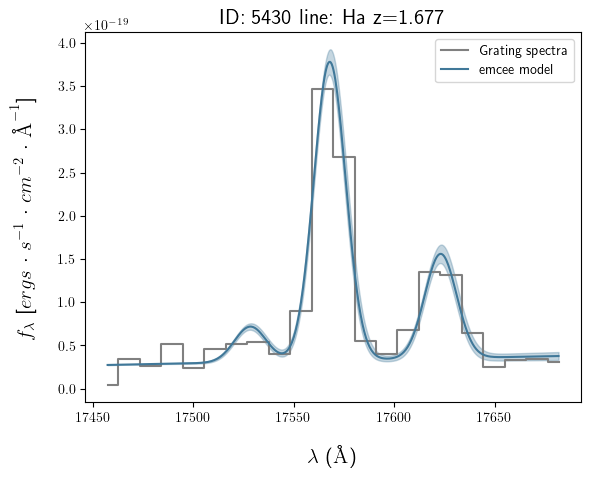

source #85


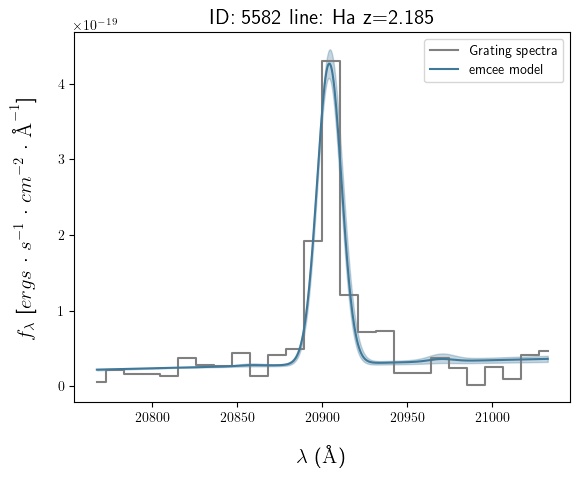

source #86


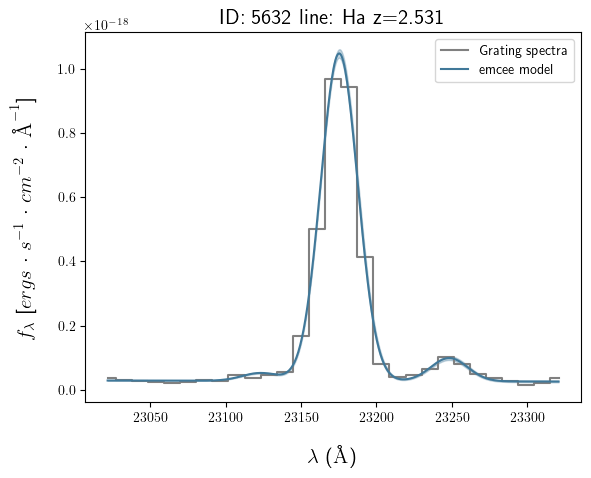

source #87


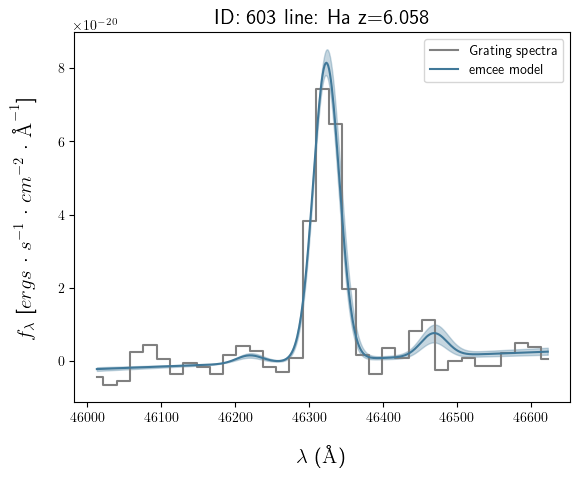

source #88


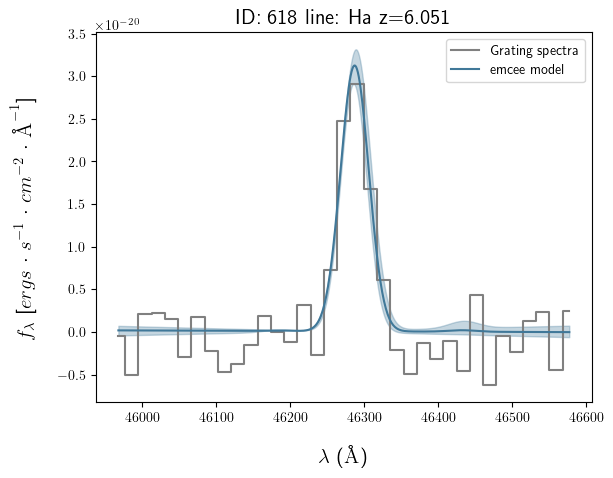

source #89


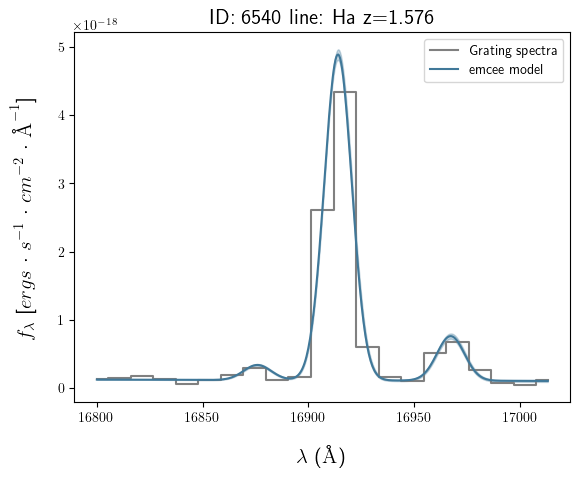

source #90


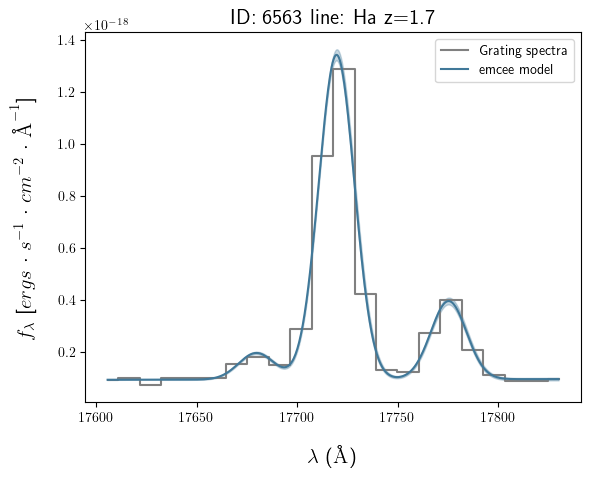

source #91


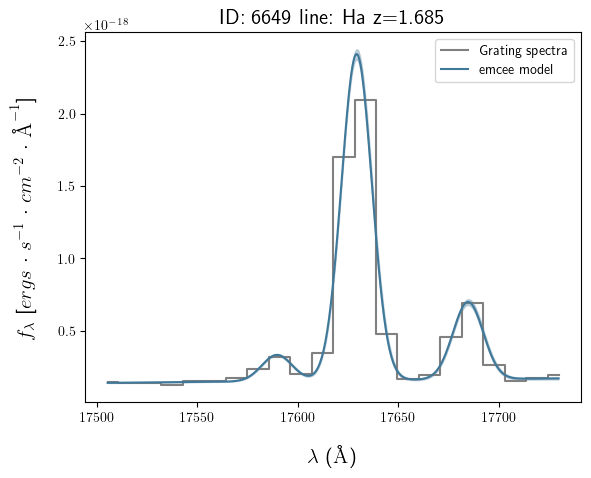

source #92


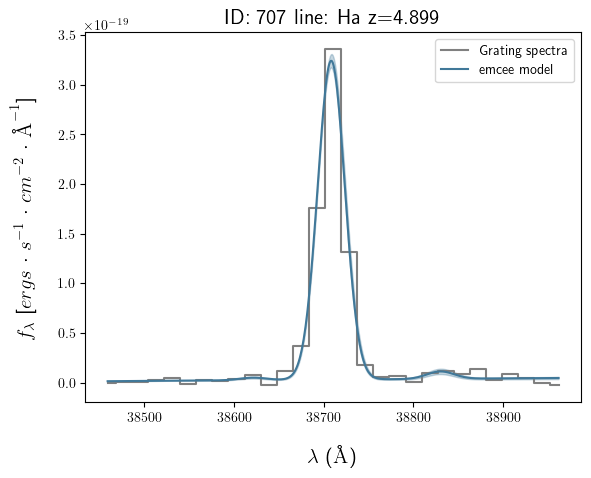

source #93


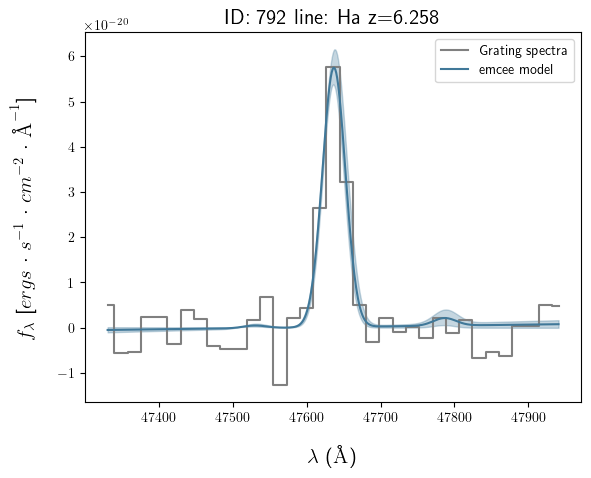

source #94


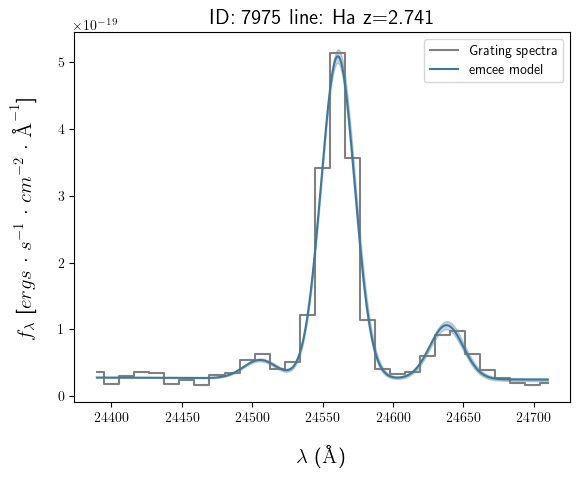

source #95


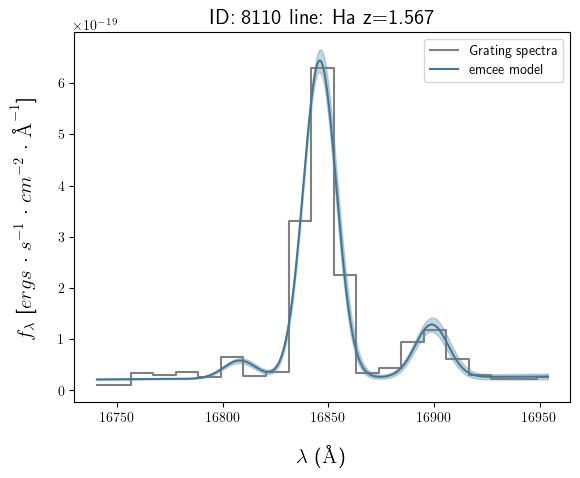

source #96


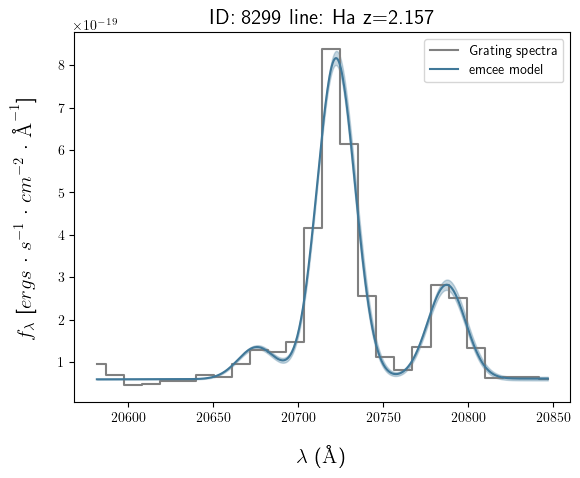

source #97


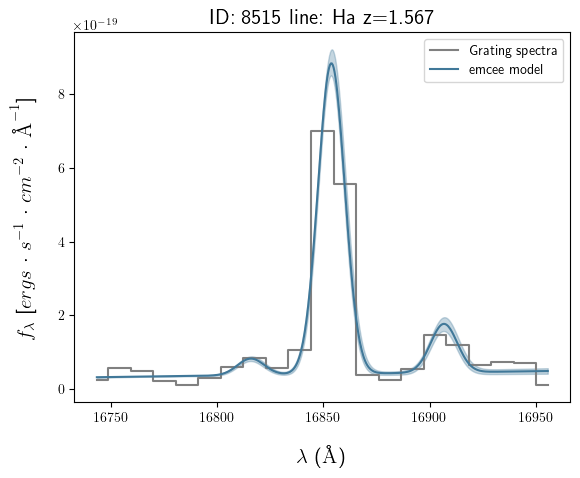

source #98


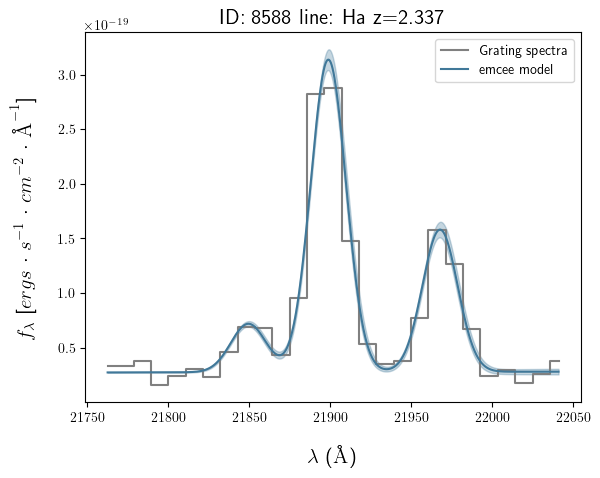

source #99


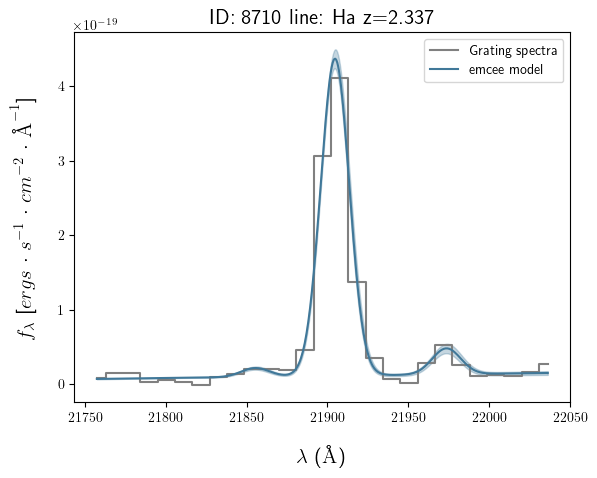

source #100


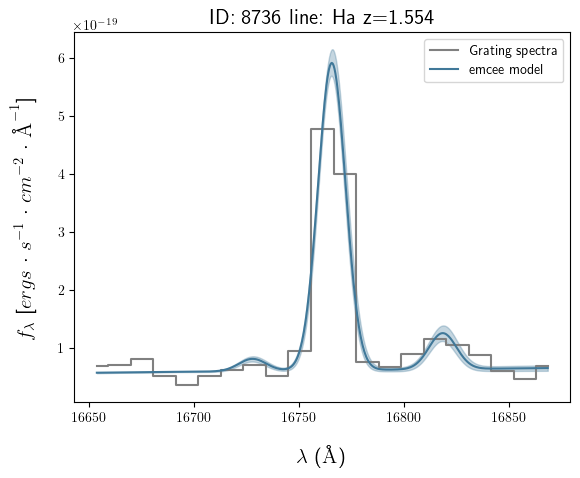

source #101


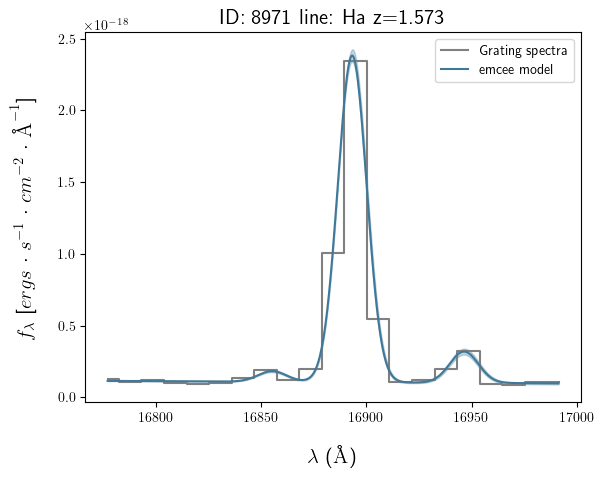

source #102


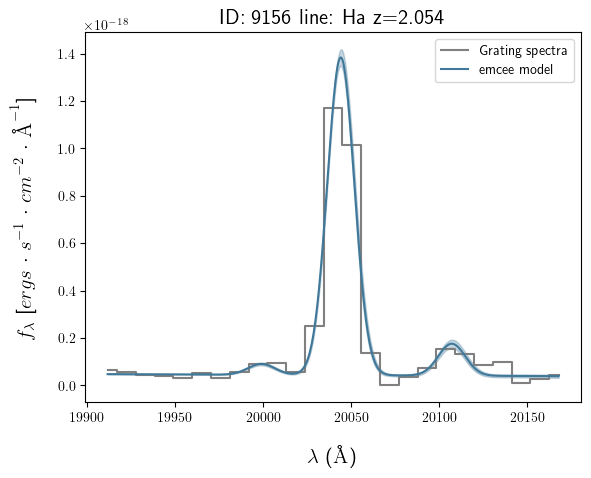

source #103


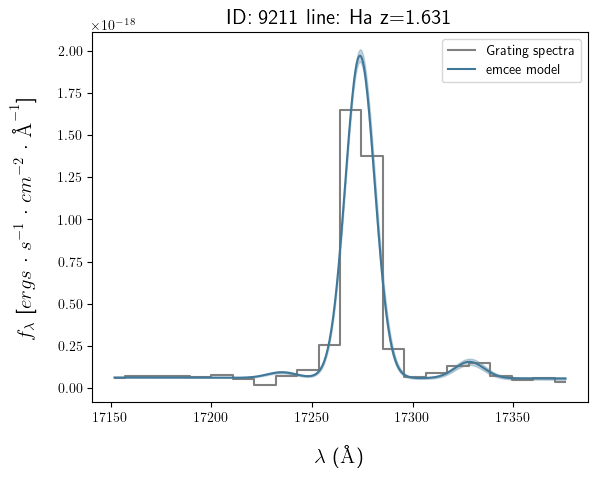

source #104


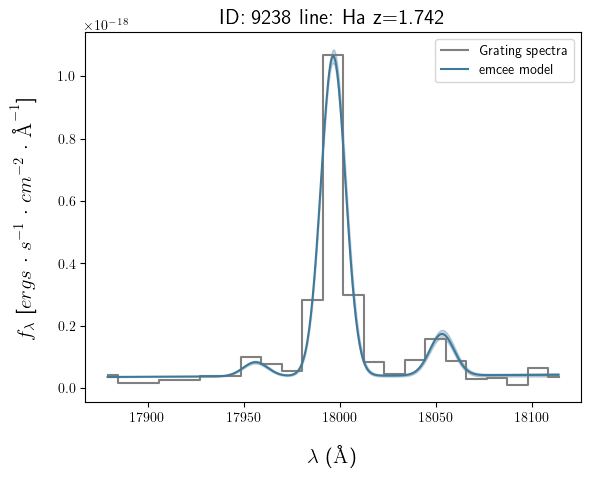

source #105
106 fitted sources


MSA_ID  Z_SPEC                                            samples  \
0  10293   1.676  [[[7.988906248452462e-19, 4.7474642338094054e-...   
1  11088   3.303  [[[1.2677732309891492e-18, 3.537305907236633e-...   
2   1115   6.300  [[[1.5921217116775752e-19, 5.0329922671395485e...   
3  11580   3.229  [[[6.954098441269984e-20, 7.116724683395238e-2...   
4  11699   3.301  [[[3.4942119092296844e-19, 9.926068715131465e-...   

                                                wavs  \
0  [17445.97127991015, 17452.298393934034, 17458....   
1  [28059.044052008045, 28069.721777720686, 28080...   
2  [47601.87457488187, 47619.6915830635, 47637.50...   
3  [27570.310517202717, 27580.892838156906, 27591...   
4  [28045.45524550129, 28056.098095817262, 28066....   

                                              fluxes  \
0  [1.339557475310239e-19, 1.319730864006706e-19,...   
1  [7.217726977070378e-21, 7.58257415915794e-21, ...   
2  [-1.1038835947847504e-20, 4.548769668530351e-2...   
3  [8.29764830927722e-21, 3.141401195981923e-21, ...   
4  [1.0931028576105312e-20, 1.7086719927103755e-2...   

                                          fluxes_err  \
0  [2.0143896637508487e-20, 2.3633116680624518e-2...   
1  [5.534136310942189e-21, 4.727308544606077e-21,...   
2  [4.627139974815265e-21, 4.982442601323615e-21,...   
3  [4.620786879305871e-21, 4.252007971607102e-21,...   
4  [4.681325793750713e-21, 5.5923693536416005e-21...   

                                       median_params             A  \
0  [7.881332054669409e-19, 6.144964714690573e-20,...  7.881332e-19   
1  [1.3407275644979135e-18, 3.7224770085726176e-2...  1.340728e-18   
2  [1.776597116438138e-19, 2.8704126327084176e-22...  1.776597e-19   
3  [6.519038274684821e-20, 1.2452305659158975e-21...  6.519038e-20   
4  [3.763779308395632e-19, 9.011986071360519e-21,...  3.763779e-19   

                                               A_err            mu      sigma  \
0  [3.9141420211904434e-20, 4.134907406893498e-20...  17565.136917   6.498857   
1  [1.7552415441073667e-20, 1.744184741411382e-20...  28240.197842  16.796348   
2  [7.922758054985134e-21, 7.814347849493888e-21,...  47915.502288  20.298382   
3  [4.4155622686192575e-21, 4.316296573787613e-21...  27751.179155  14.090022   
4  [1.0465008332713192e-20, 1.00539201042296e-20,...  28237.600393  12.946924   

                                           sigma_err  \
0  [0.35348579277183356, 0.32835053047654306, 0.3...   
1  [0.16833392056736152, 0.17136660463523867, 0.1...   
2  [0.8840420691770756, 0.8813188924837974, 0.886...   
3  [1.0315139248194827, 0.9753047105855526, 1.087...   
4  [0.2998640711375673, 0.2922257123660881, 0.307...   

                                    perc_16th_params  \
0  [7.467841313980059e-19, 5.28152414938037e-20, ...   
1  [1.3232857170837997e-18, 3.546938337382398e-20...   
2  [1.6984536379431992e-19, 7.611581069129378e-23...   
3  [6.08740861730606e-20, 4.615477154929392e-22, ...   
4  [3.663240107353336e-19, 7.702837304663237e-21,...   

                                    perc_84th_params         A_NII  \
0  [8.250669718218148e-19, 7.019899156907301e-20,...  6.144965e-20   
1  [1.358390547965947e-18, 3.888323399012091e-20,...  3.722477e-20   
2  [1.8569087990429018e-19, 7.710820791371463e-22...  2.870413e-22   
3  [6.970521071029911e-20, 2.374317361258205e-21,...  1.245231e-21   
4  [3.8725402740075996e-19, 1.0268673531816666e-2...  9.011986e-21   

                                           A_NII_err  
0  [8.691875037634654e-21, 8.634405653102031e-21,...  
1  [1.7069253081484665e-21, 1.755386711902198e-21...  
2  [3.4748313422292626e-22, 2.1092545257954798e-2...  
3  [9.56384822882633e-22, 7.836828504229583e-22, ...  
4  [1.2829181135767143e-21, 1.3091487666972816e-2...

In [39]:
# intializing dataframe
columns = ['MSA_ID','Z_SPEC', 'samples', 'wavs','fluxes','fluxes_err','median_params','A','A_err','mu','sigma','sigma_err','perc_16th_params','perc_84th_params','A_NII','A_NII_err']
Ha_emcee_df = pd.DataFrame(columns=columns)

for source in range(len(NIRSpec_df)):
    try:

        new_row = final_fits_Ha_CEERS(source, Ha_curve_fit_df, NIRSpec_df['MSA_ID'][source], NIRSpec_df['Z_SPEC'][source], diagnose=True)

        # handle NaN values for amplitude
        if np.isnan(new_row[7]):
            print('NaN value for amplitude found:')
            print(new_row[2])  # printing best-fit parameters for source
        
        df_extended = pd.DataFrame(data=[new_row], columns=columns)
        Ha_emcee_df = pd.concat([Ha_emcee_df, df_extended],ignore_index=True)
        print(f'source #{source}')
    
    except Exception as e:
        print(f"Error processing source {source}: {e}")

Ha_emcee_df.to_pickle('../outputs/checkpoints/Ha_emcee_outputs_CEERS.pkl')
print(len(Ha_emcee_df),'fitted sources')
Ha_emcee_df.head()

## H-beta final fitting

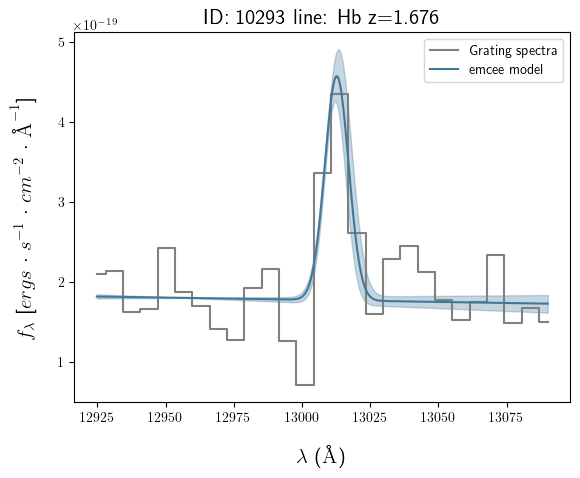

source #0


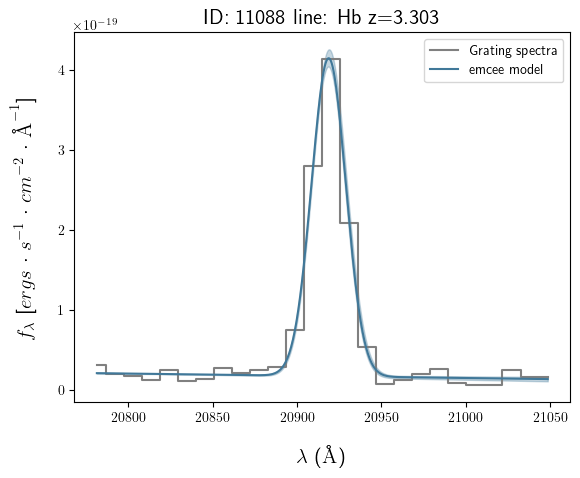

source #1


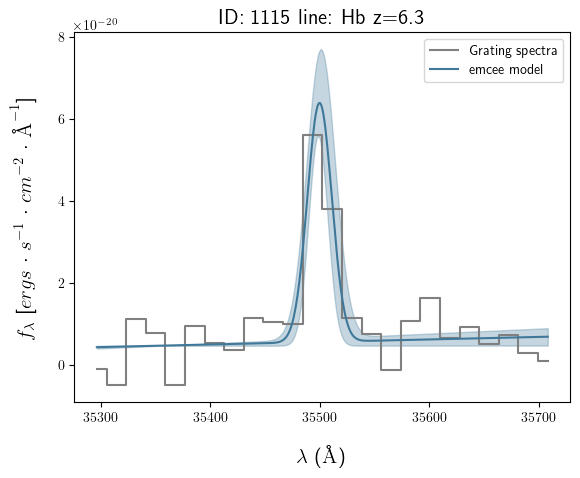

source #2


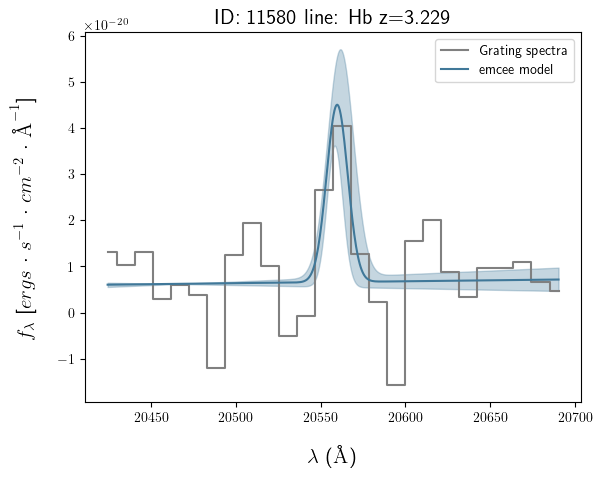

source #3


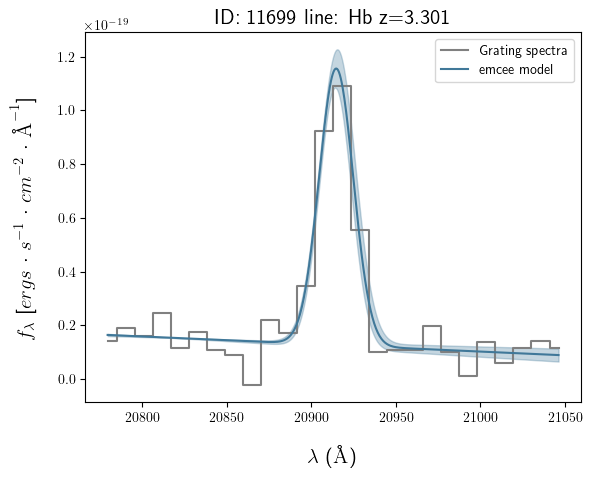

source #4


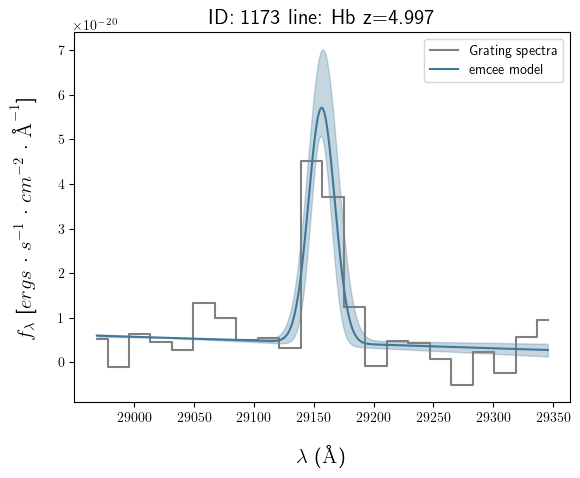

source #5


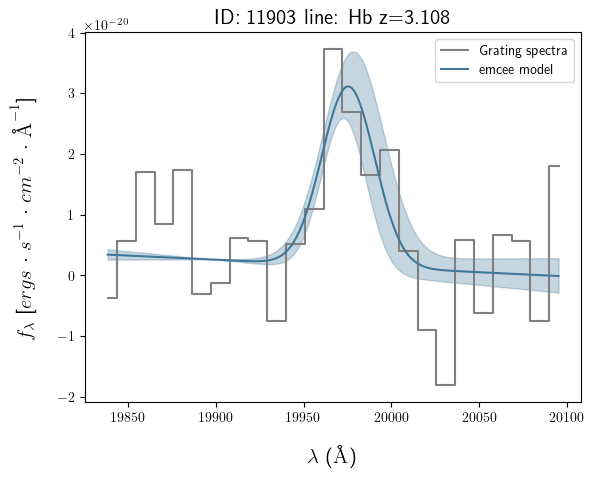

source #6


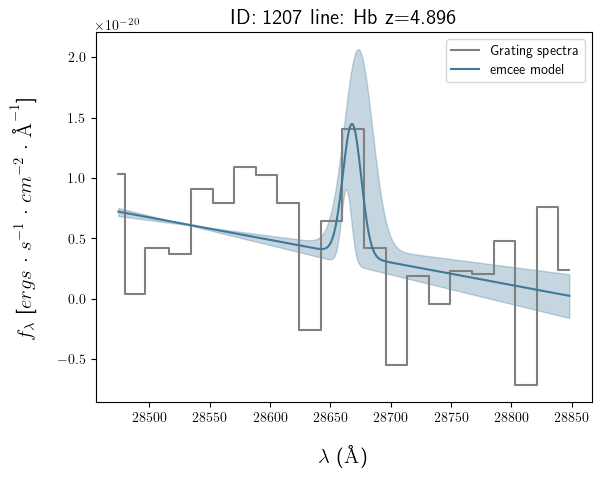

source #7


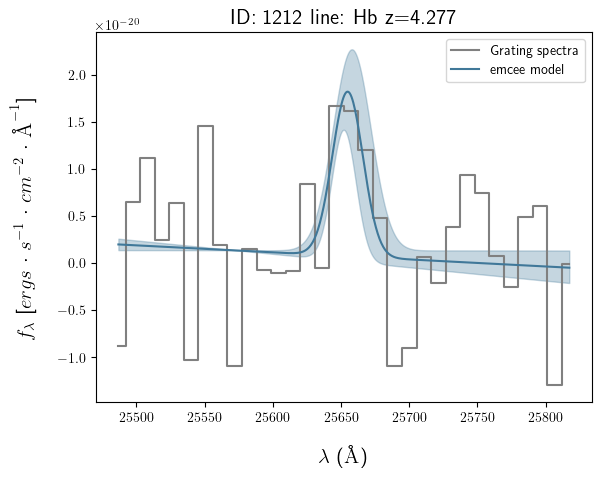

source #8


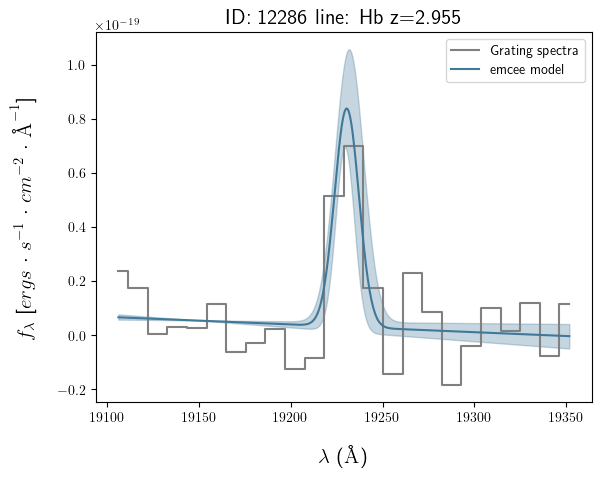

source #9


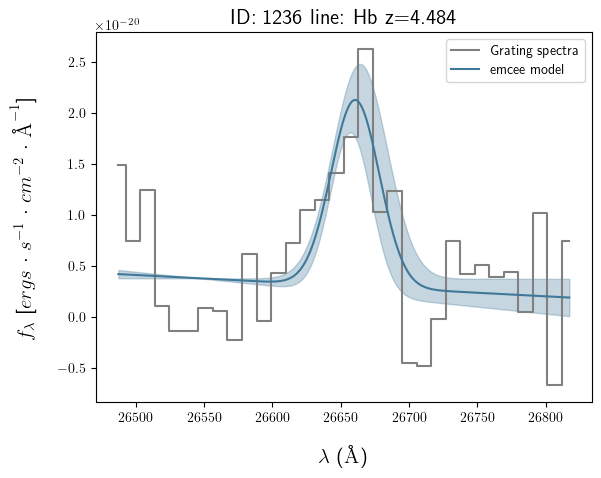

source #10


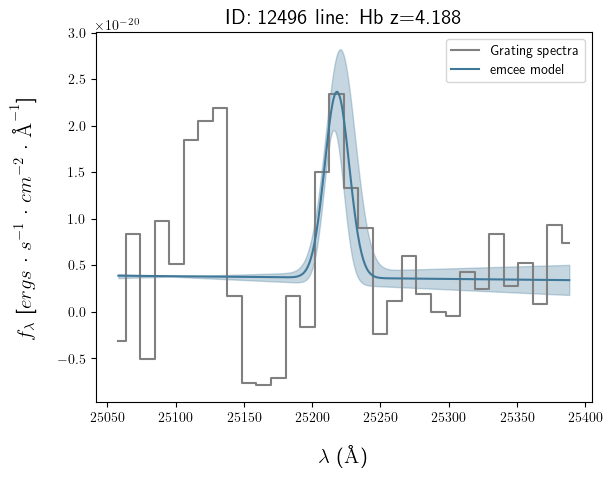

source #11


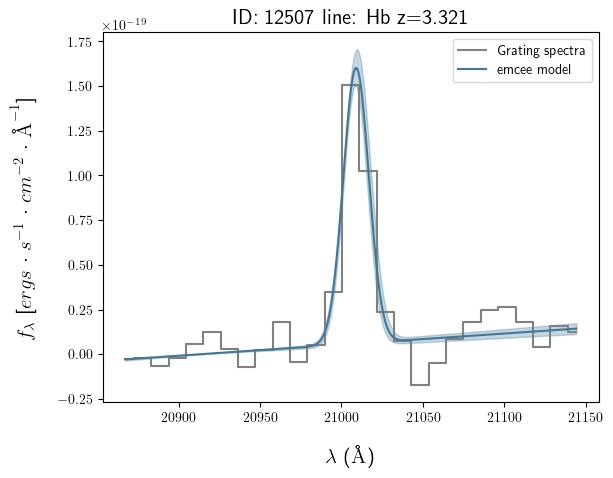

source #12


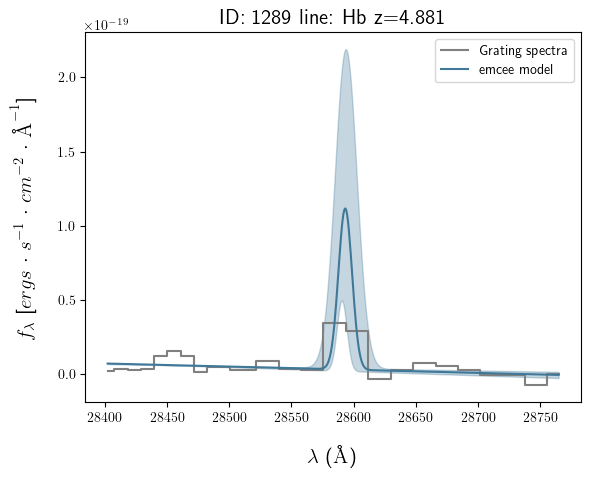

source #13


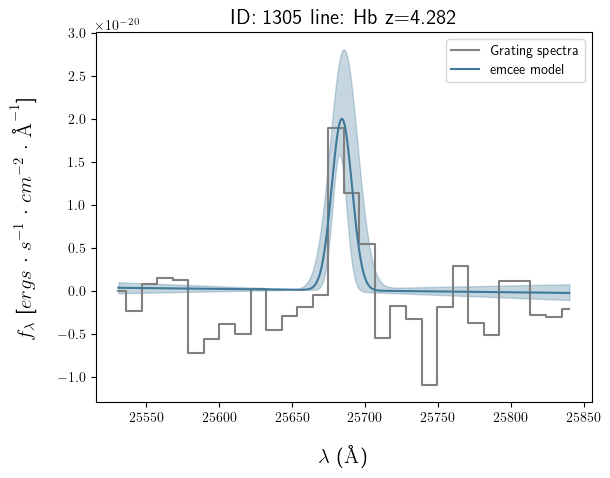

source #14


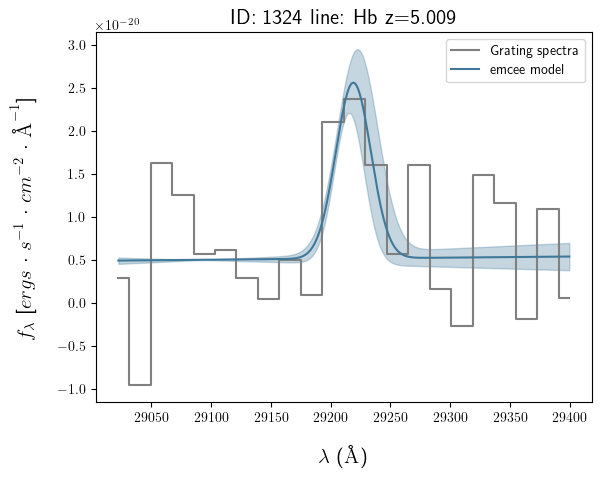

source #15


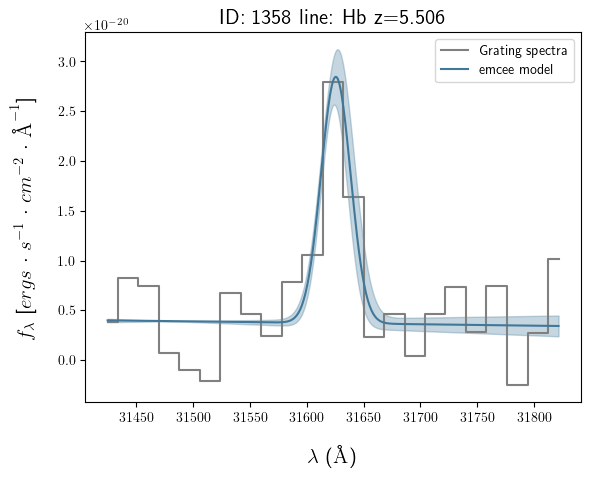

source #16


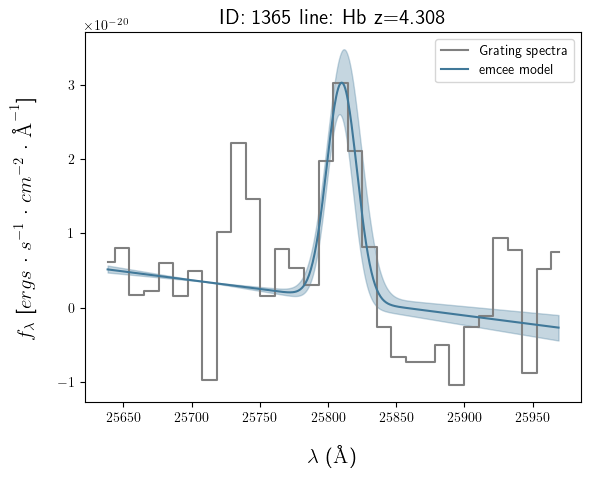

source #17


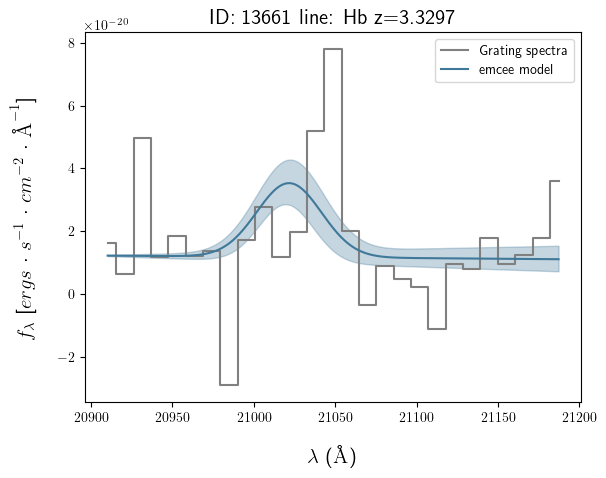

source #18


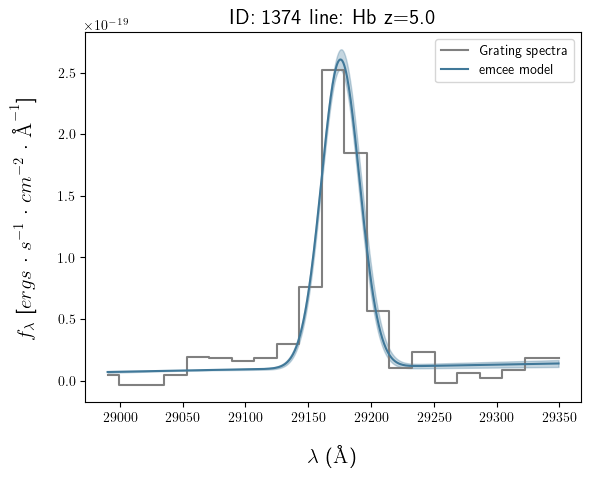

source #19


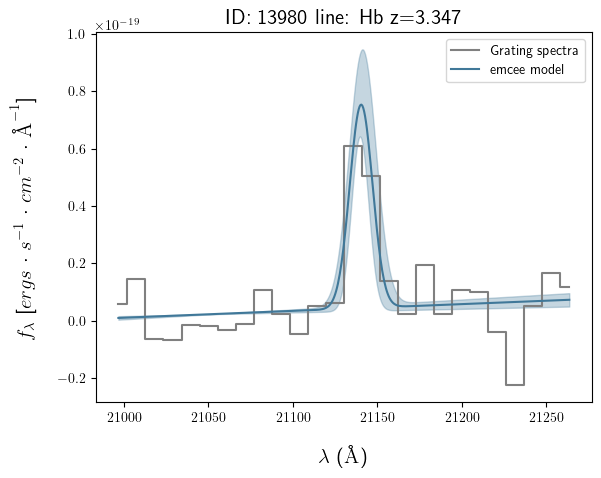

source #20


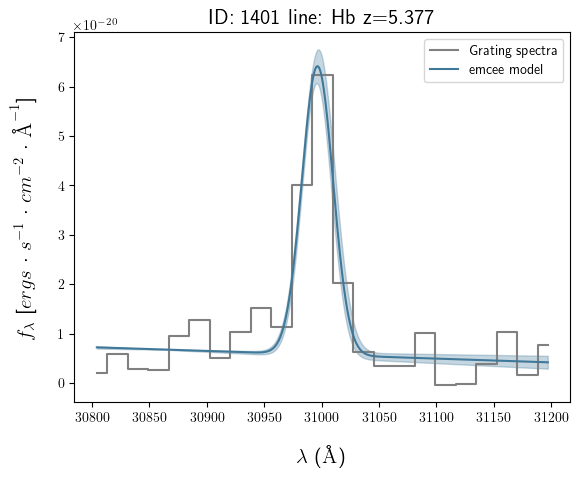

source #21


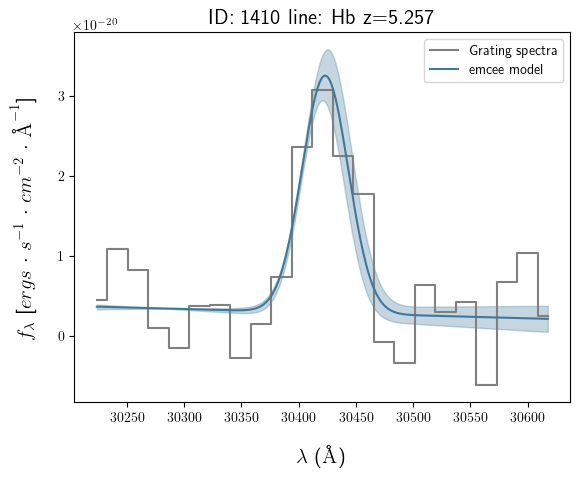

source #22


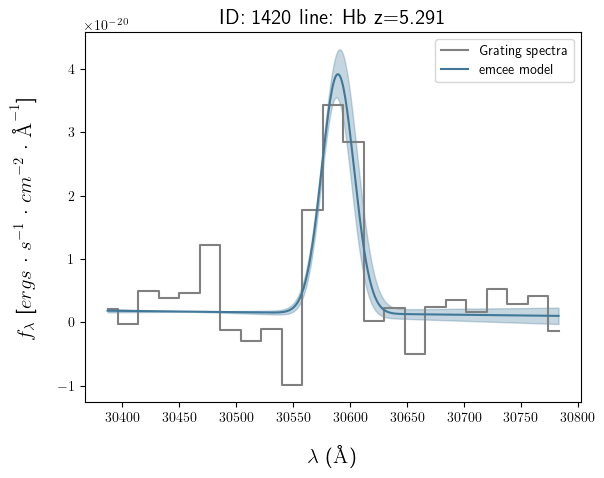

source #23


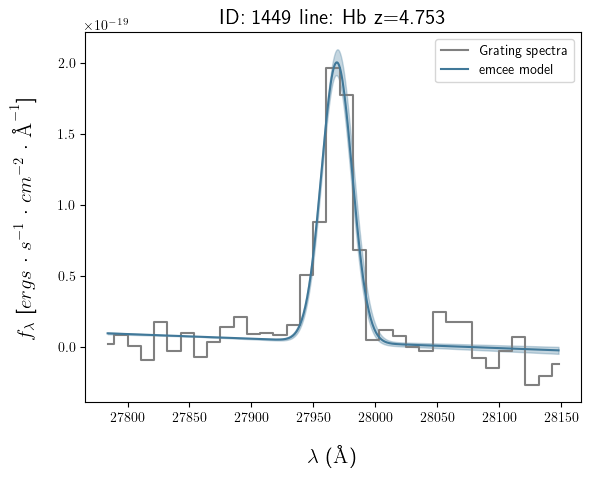

source #24


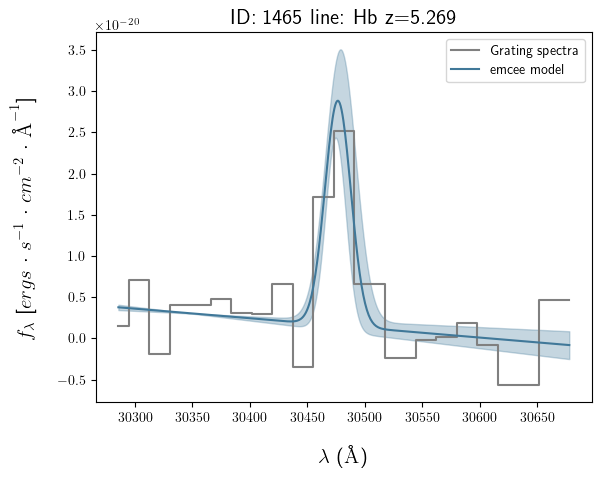

source #25


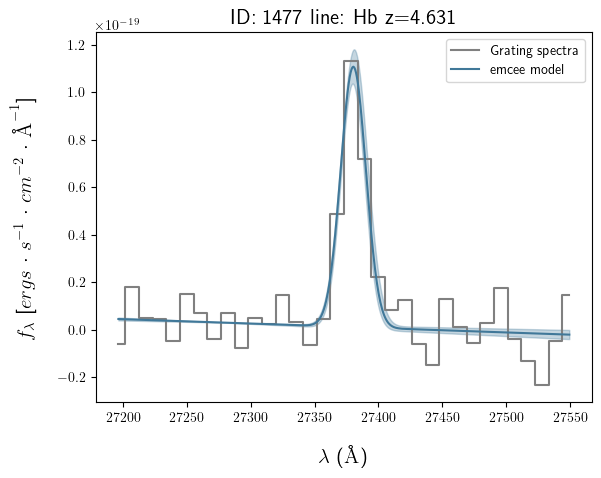

source #26


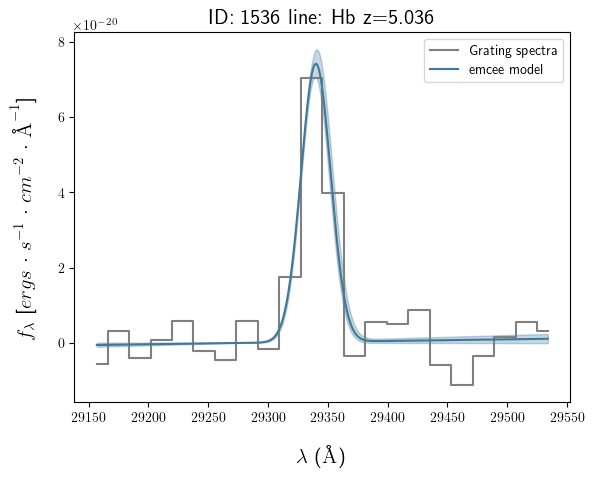

source #27


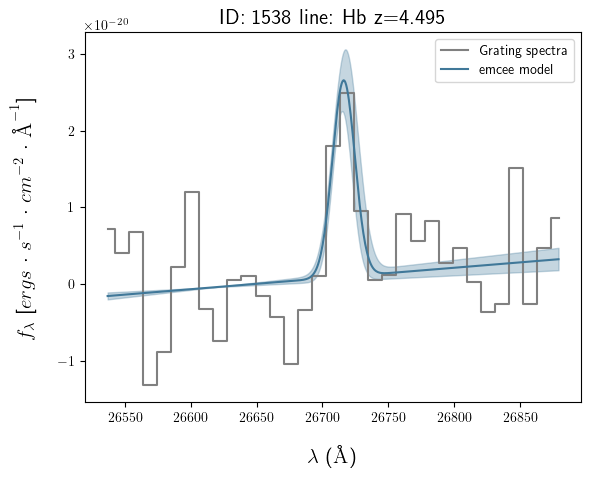

source #28


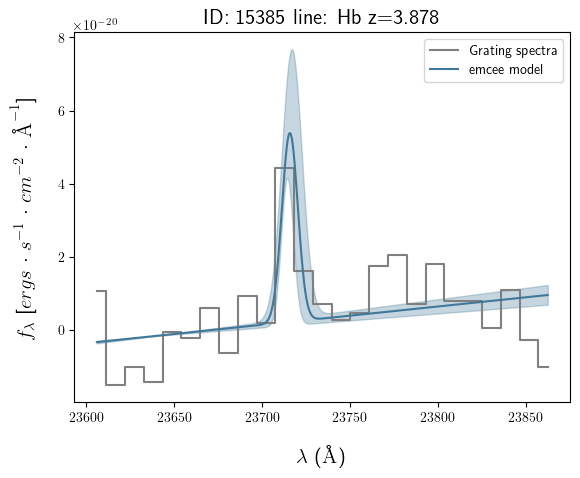

source #29


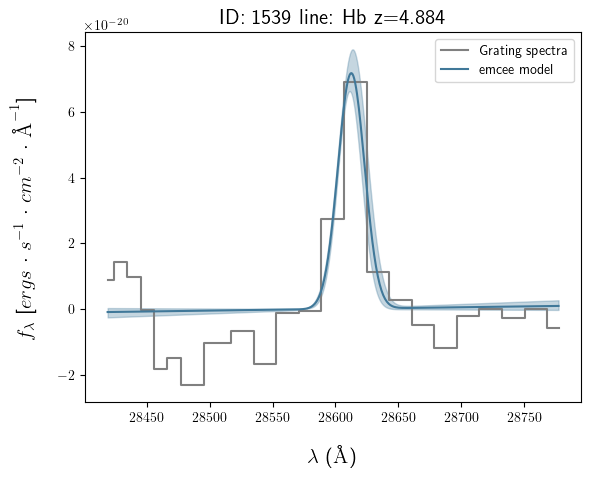

source #30


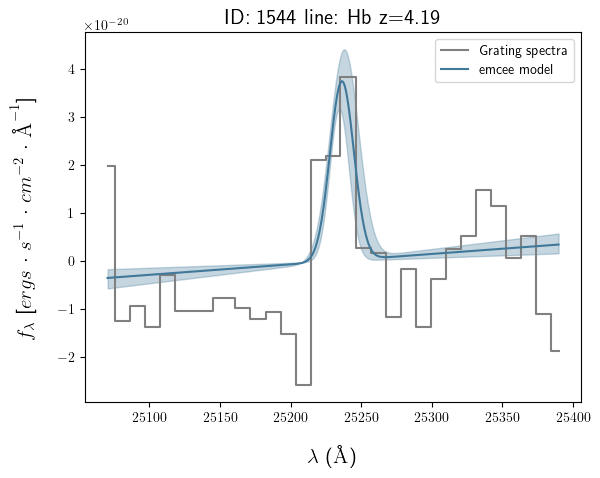

source #31


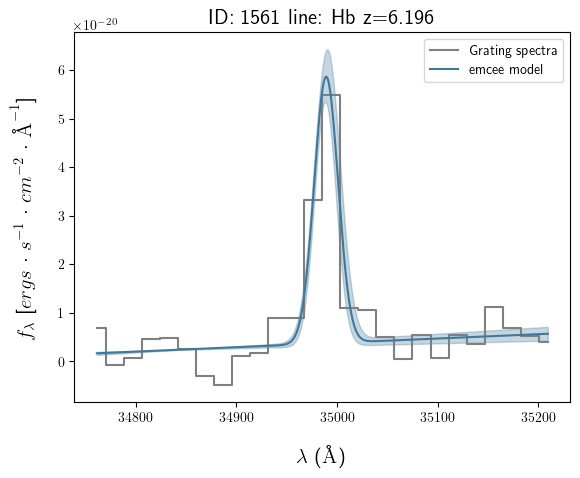

source #32


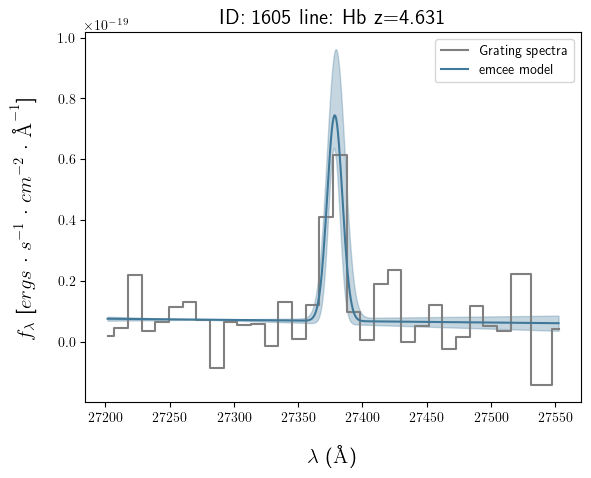

source #33


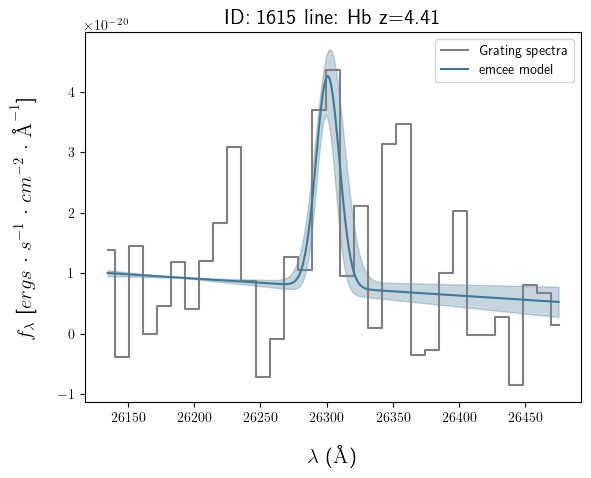

source #34


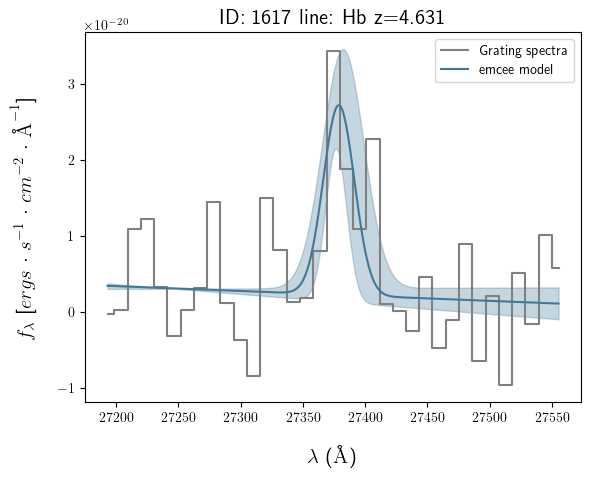

source #35


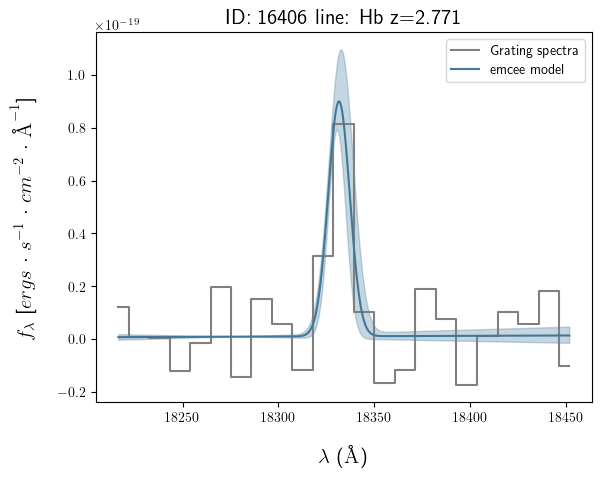

source #36


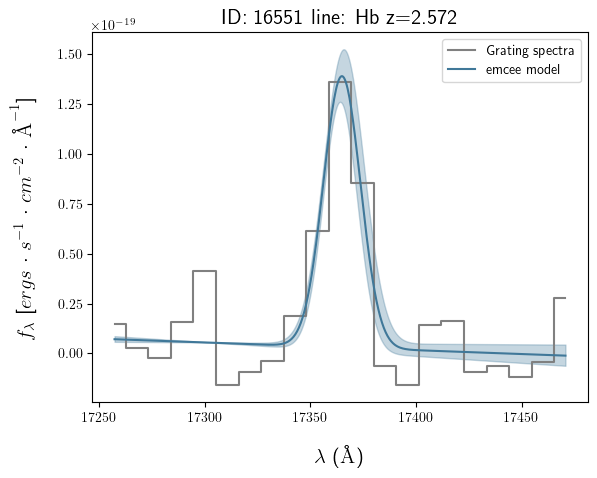

source #37


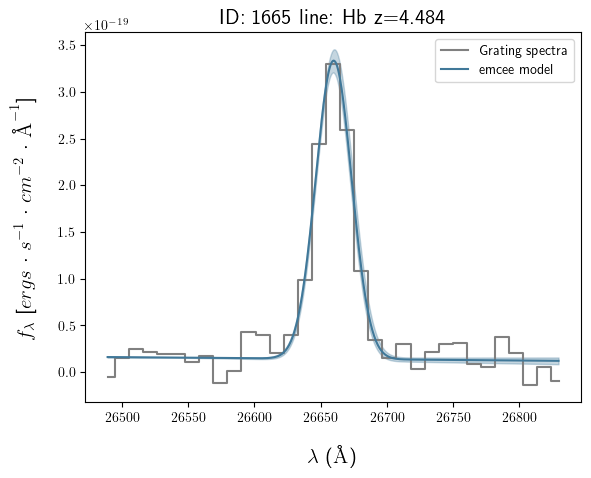

source #38


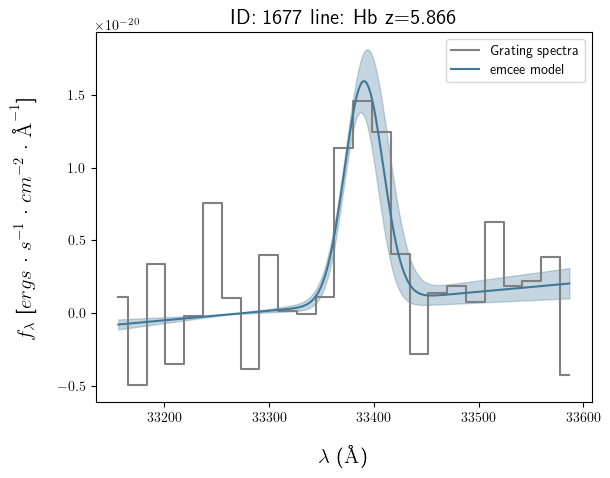

source #39


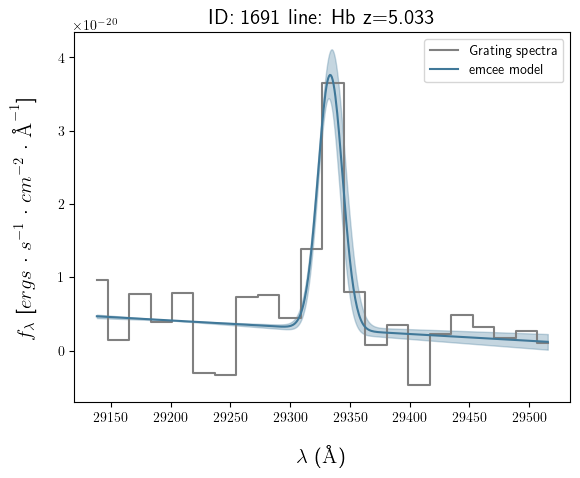

source #40


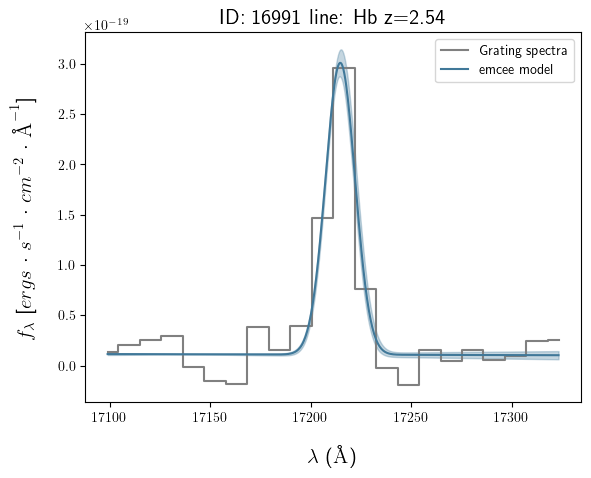

source #41


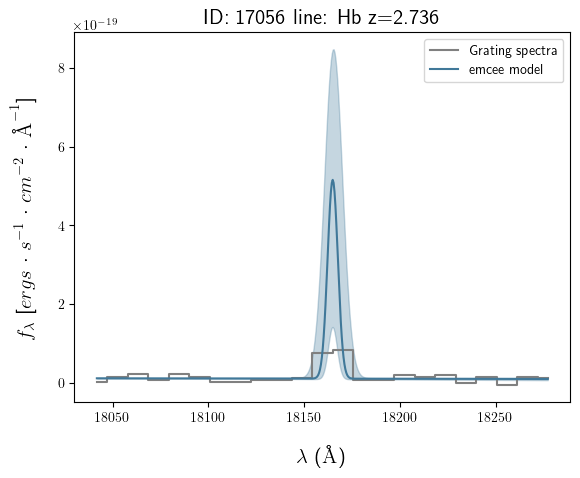

source #42


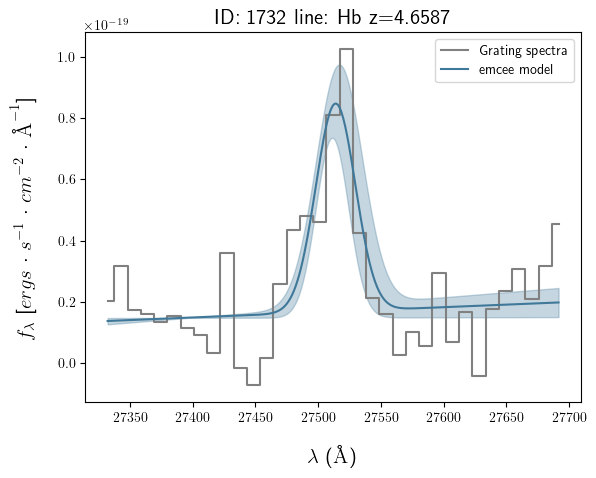

source #43


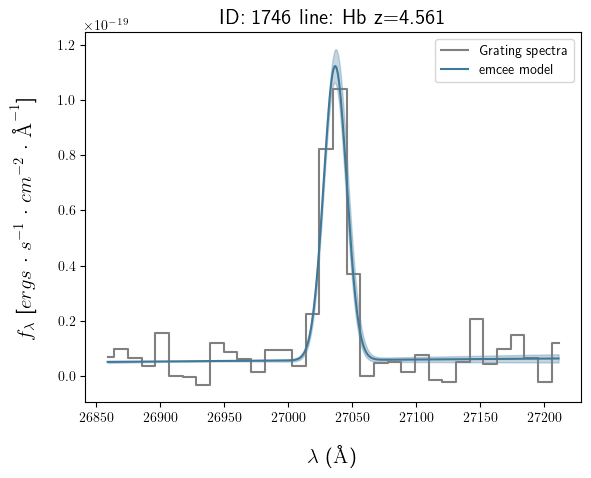

source #44


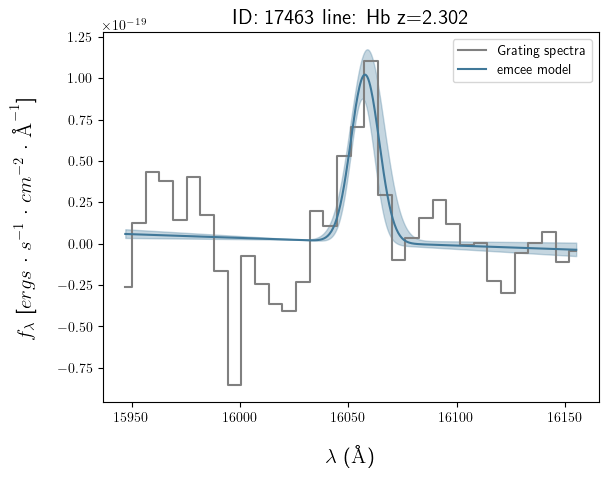

source #45


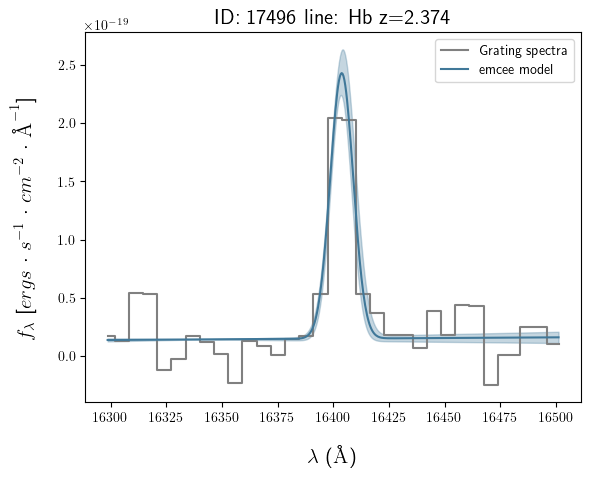

source #46


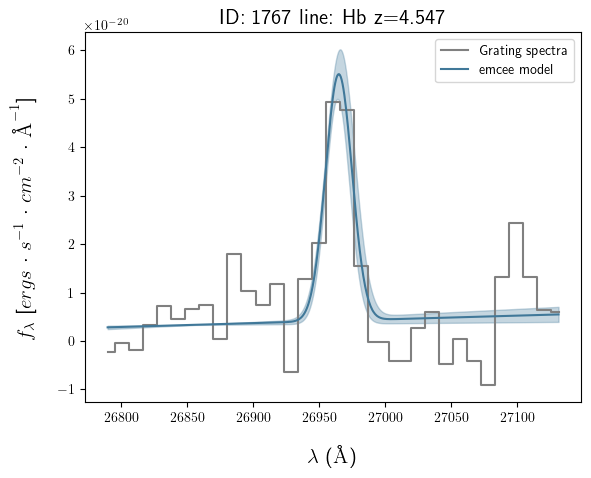

source #47


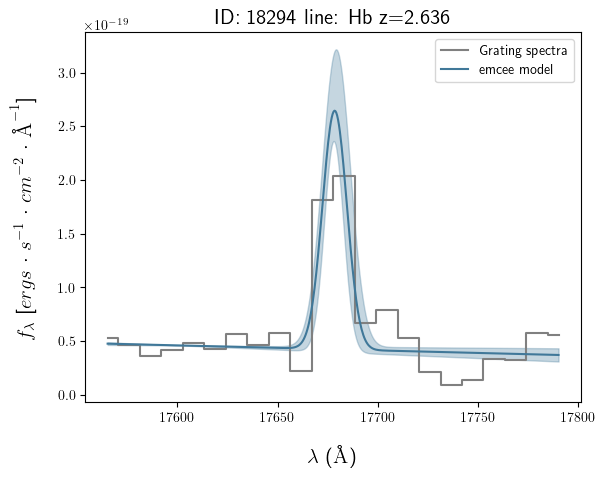

source #48


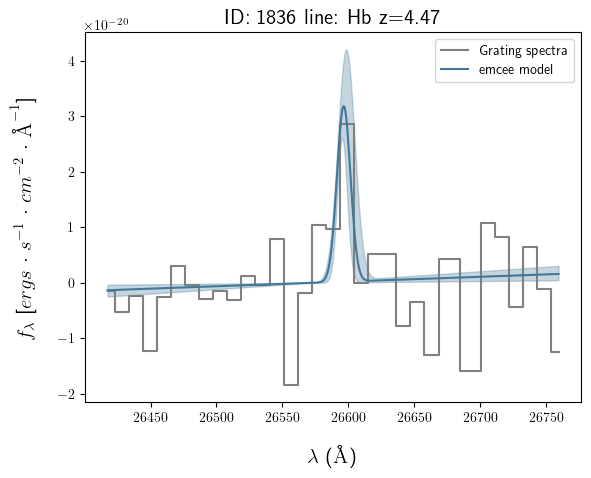

source #49


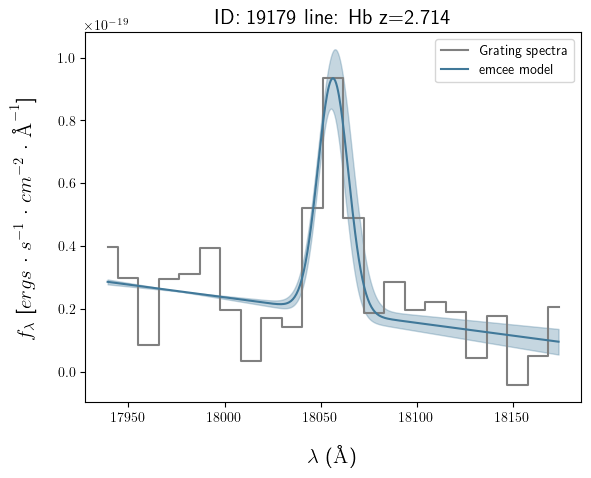

source #50


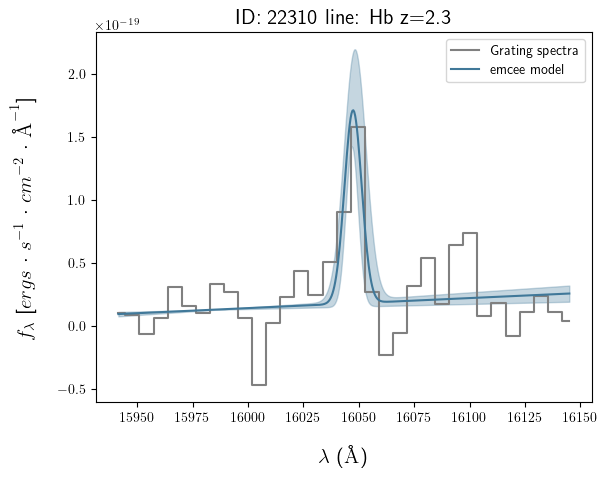

source #51


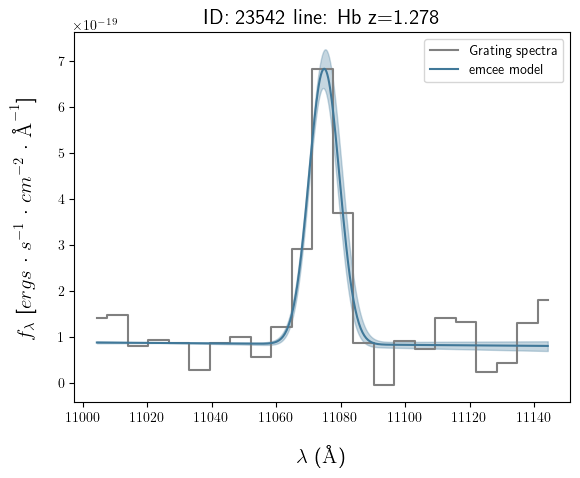

source #52


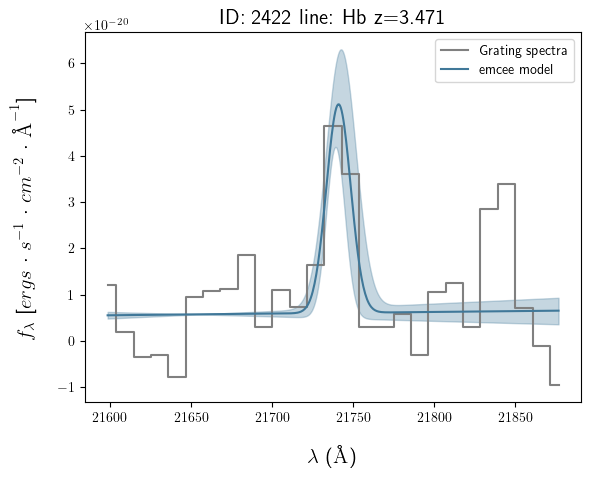

source #53


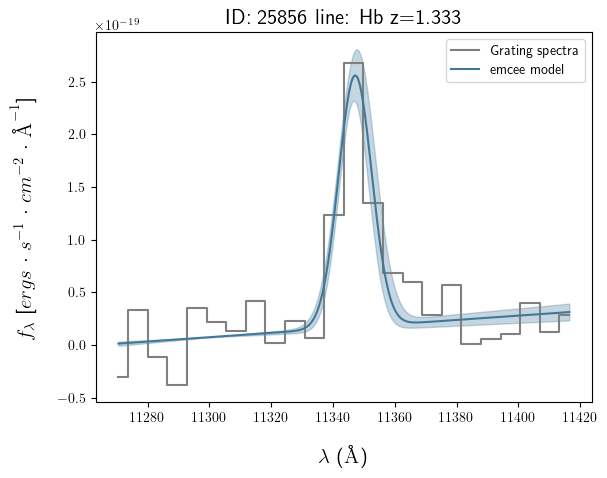

source #54


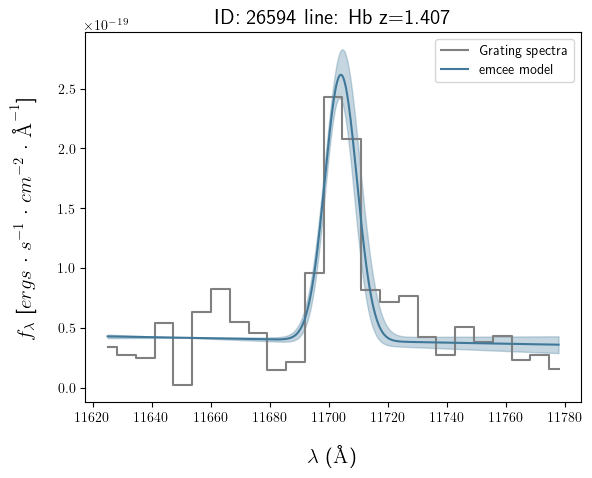

source #55


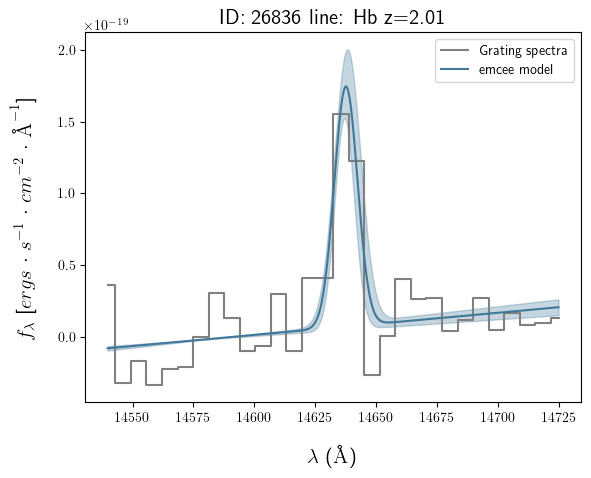

source #56


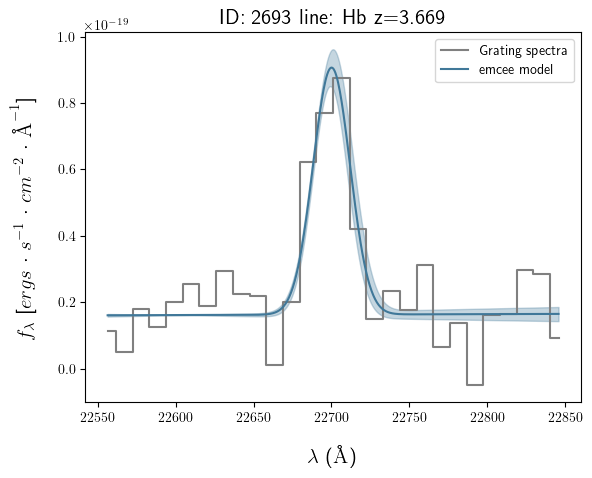

source #57


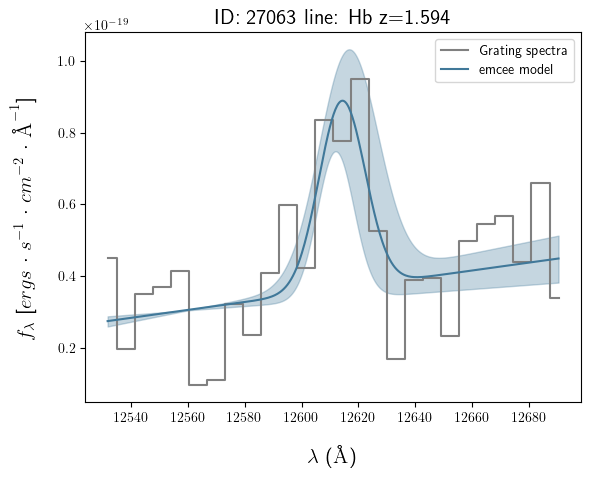

source #58


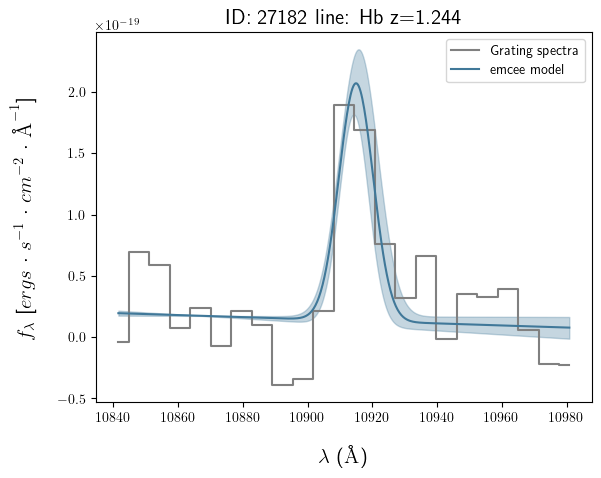

source #59


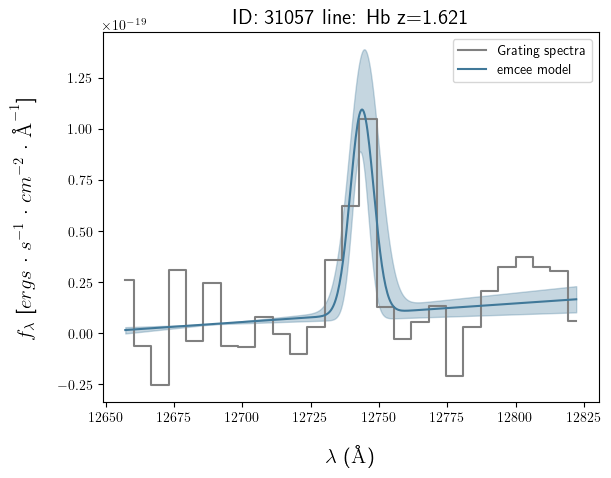

source #60


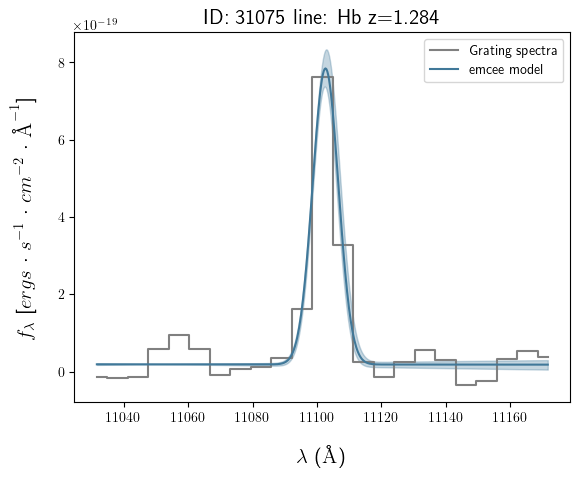

source #61


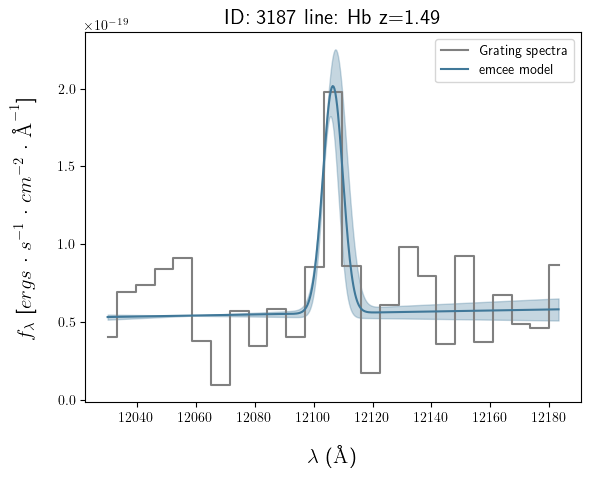

source #62


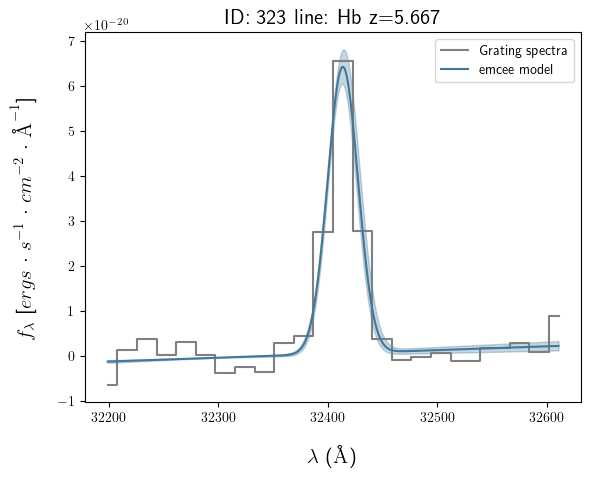

source #63


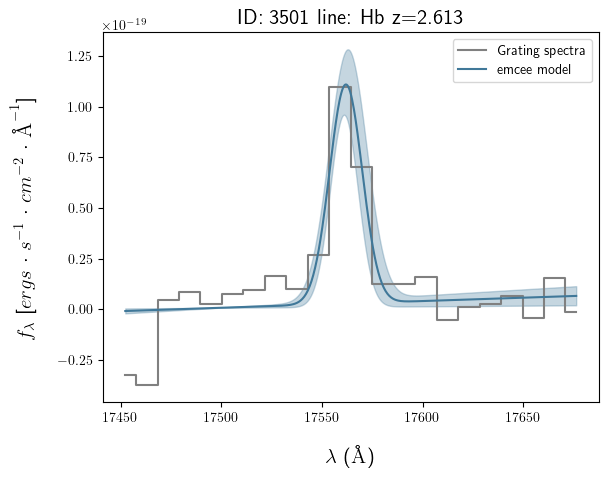

source #64


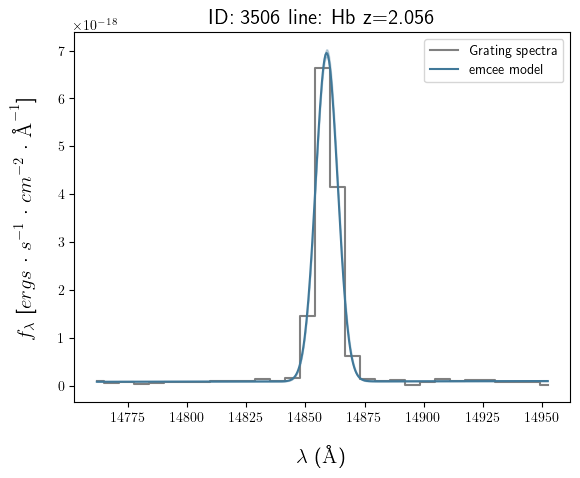

source #65


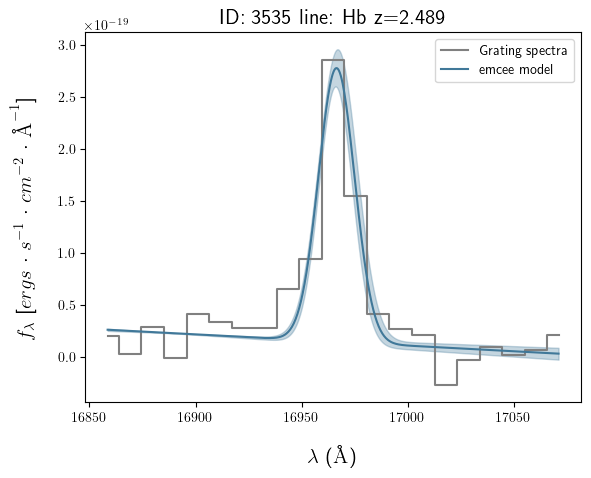

source #66


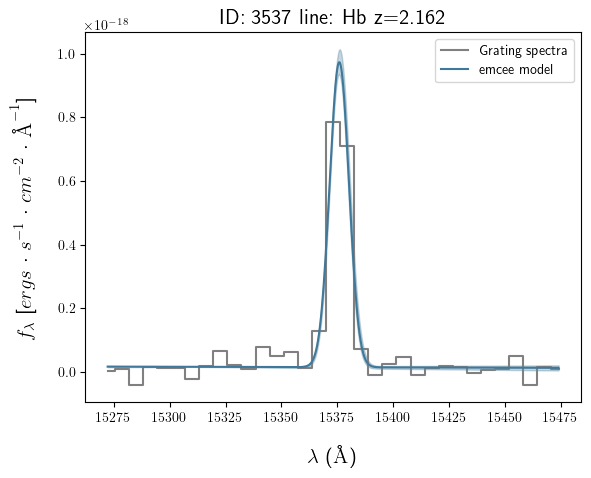

source #67


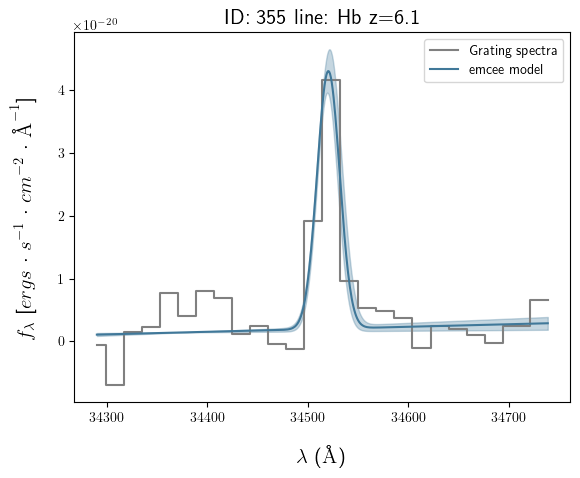

source #68


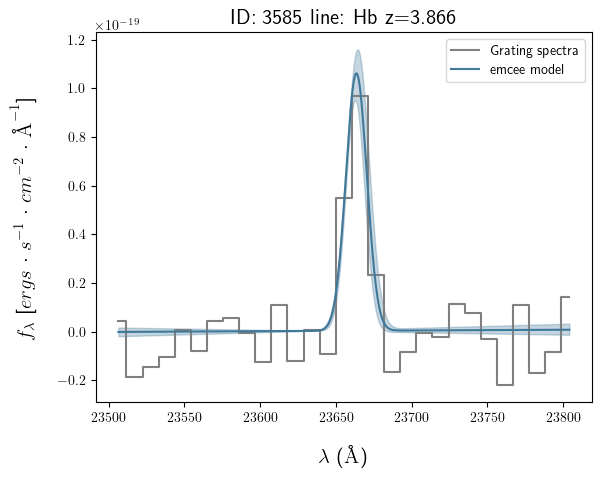

source #69


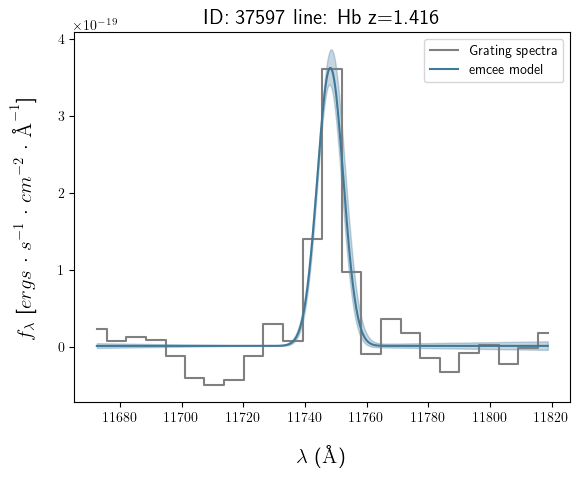

source #70


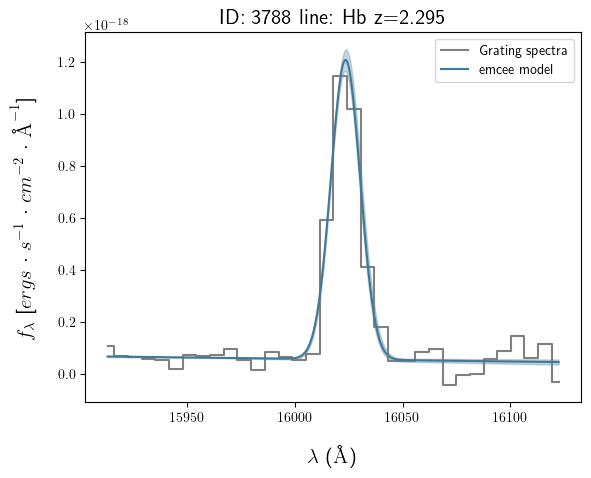

source #71


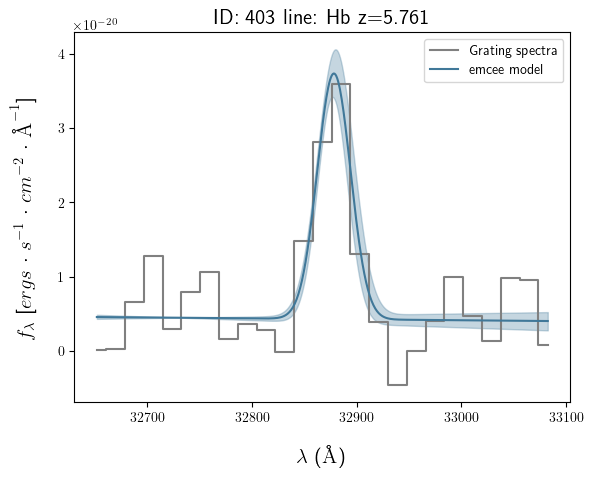

source #72


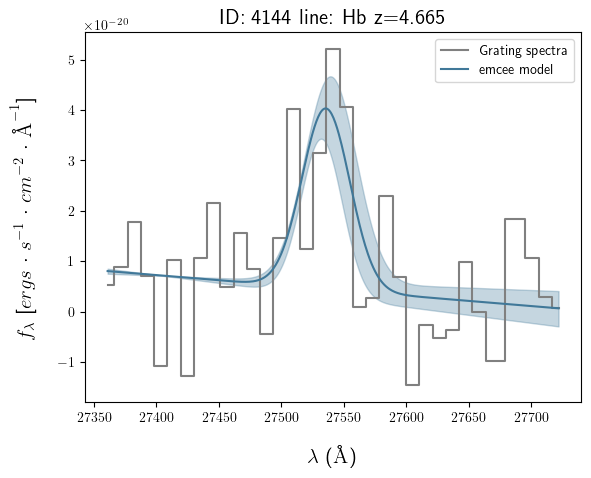

source #73


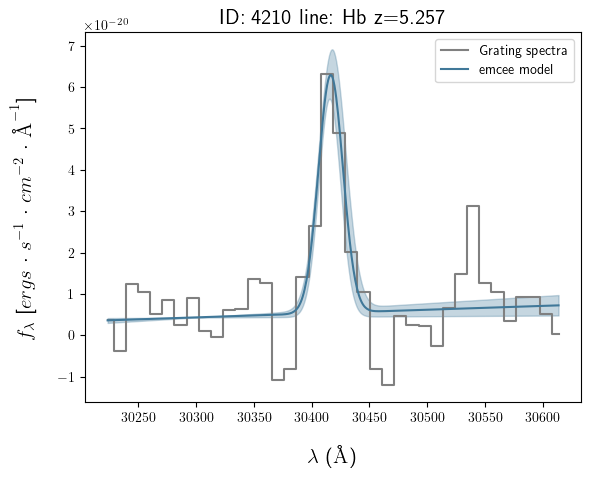

source #74


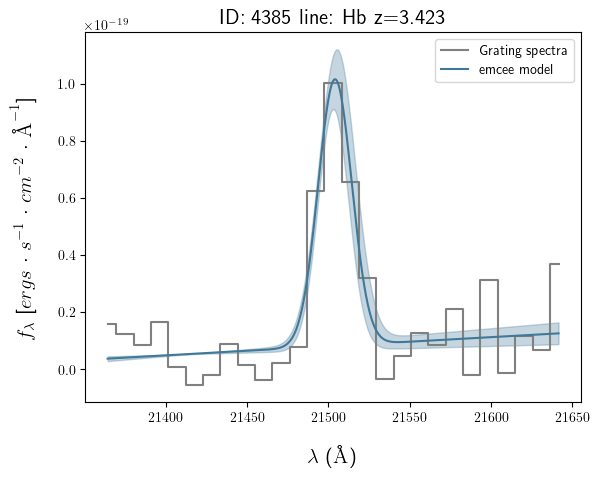

source #75


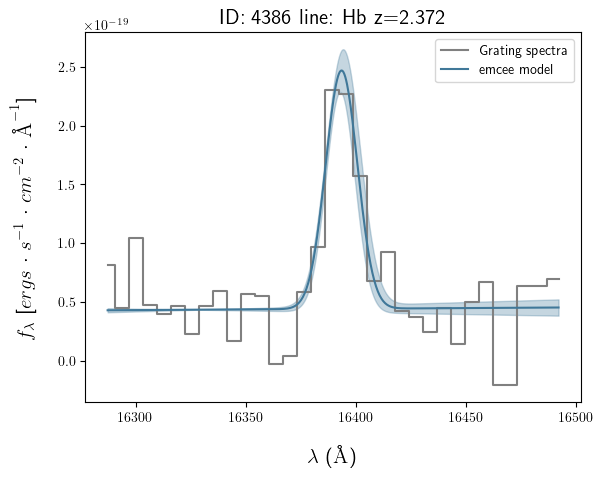

source #76


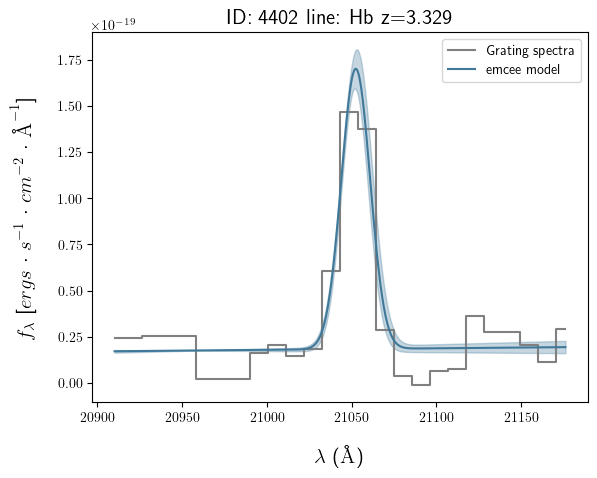

source #77


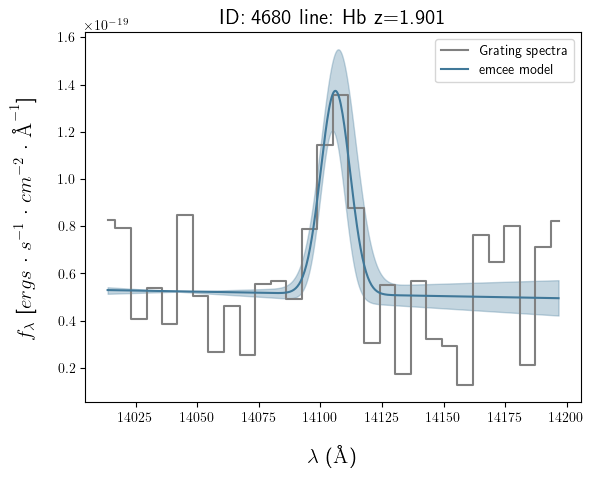

source #78


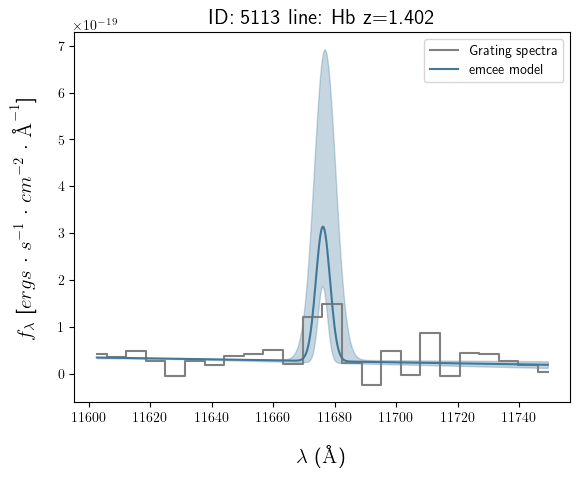

source #79


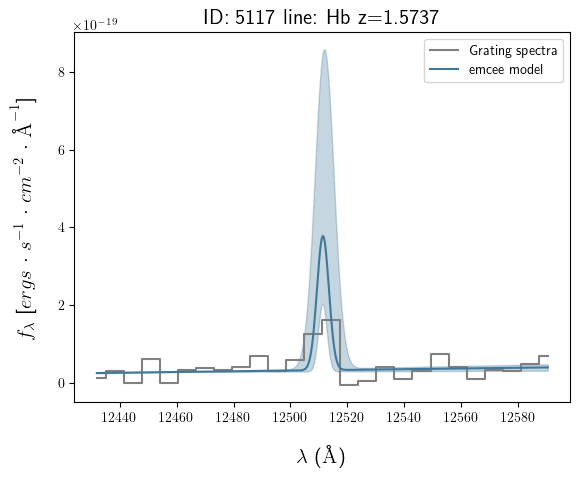

source #80


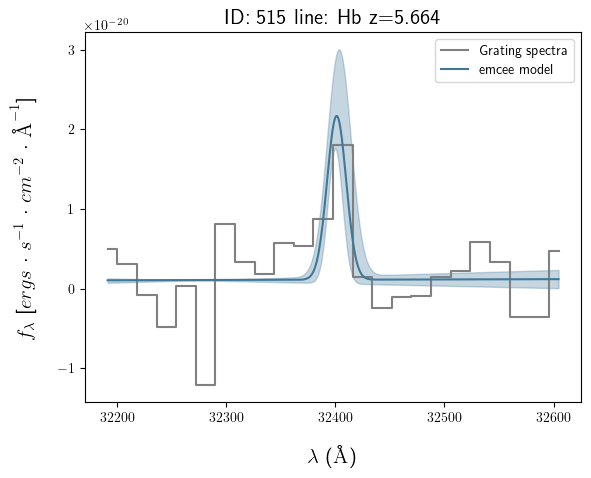

source #81


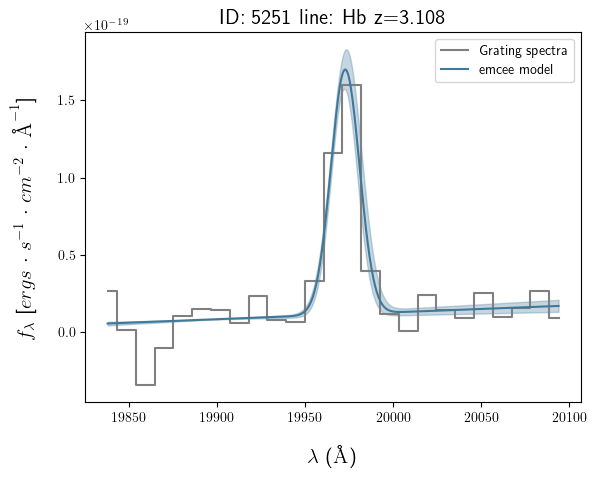

source #82


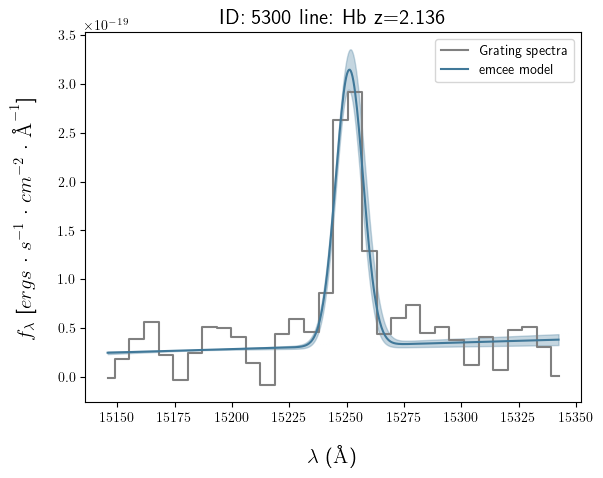

source #83


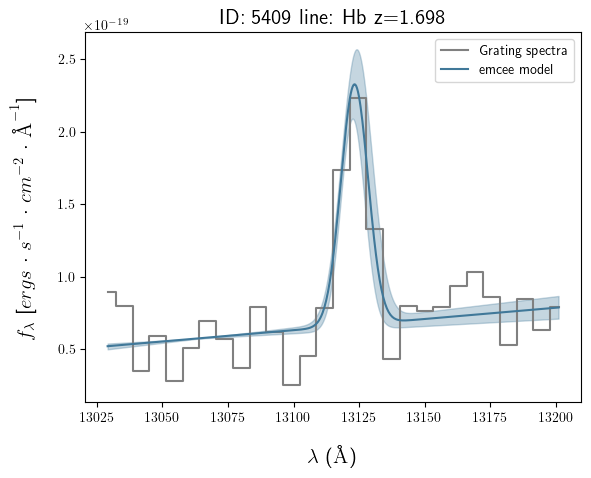

source #84


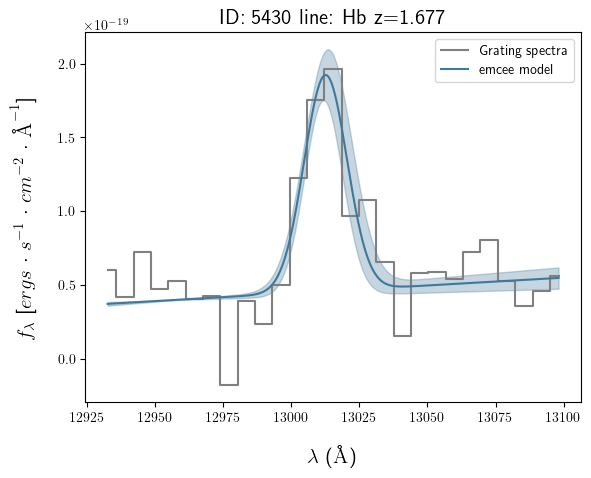

source #85


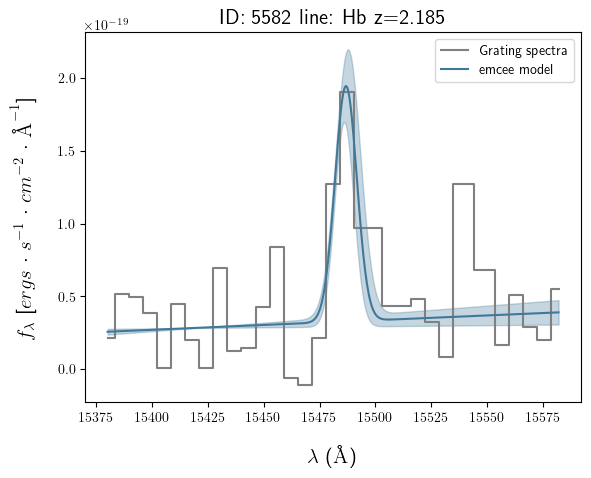

source #86


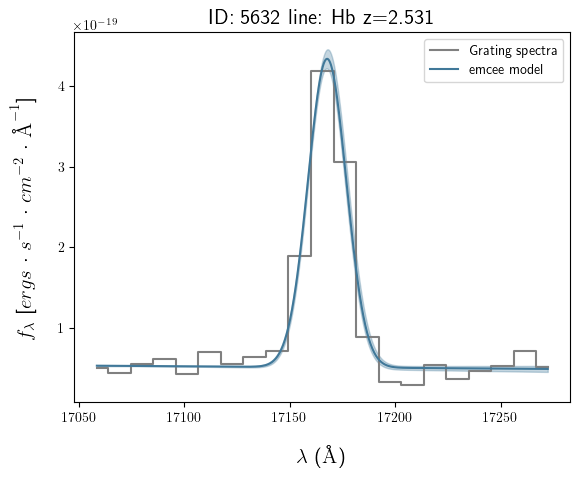

source #87


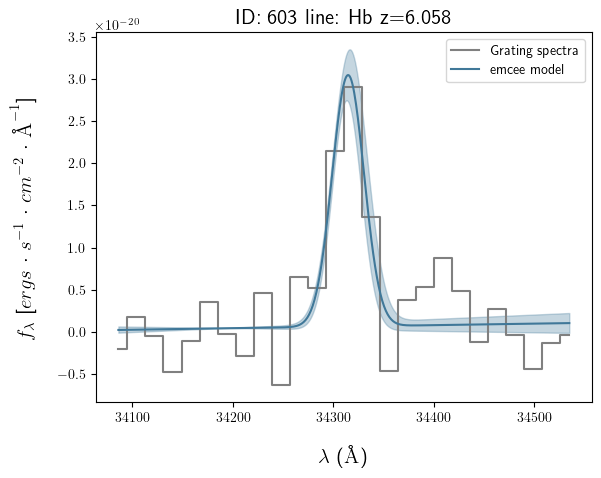

source #88


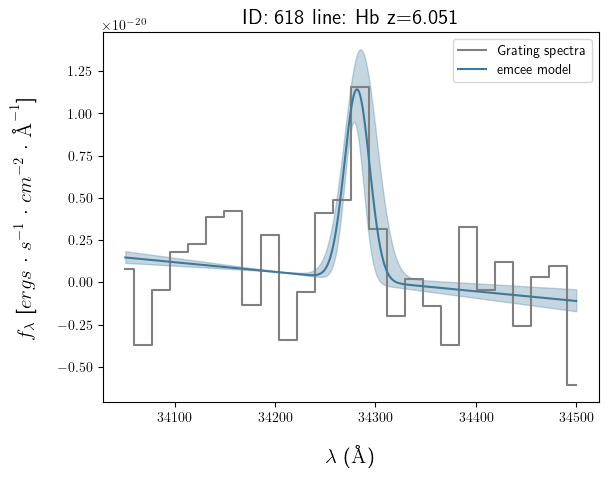

source #89


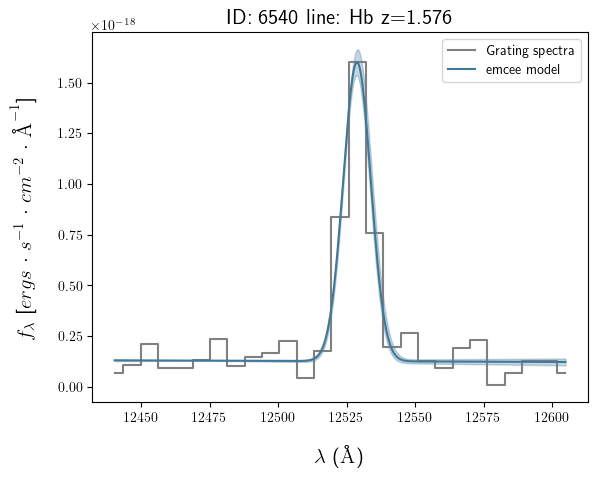

source #90


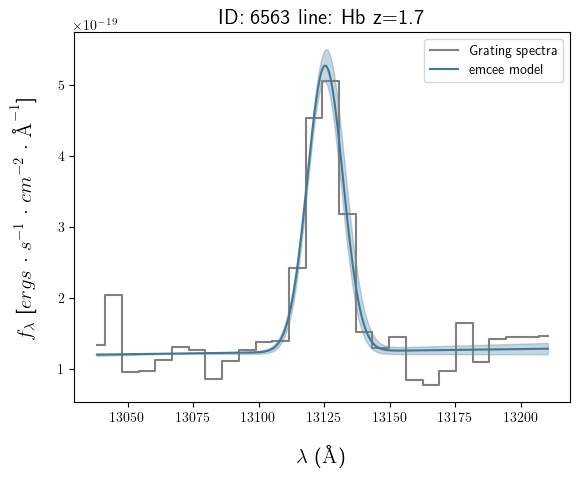

source #91


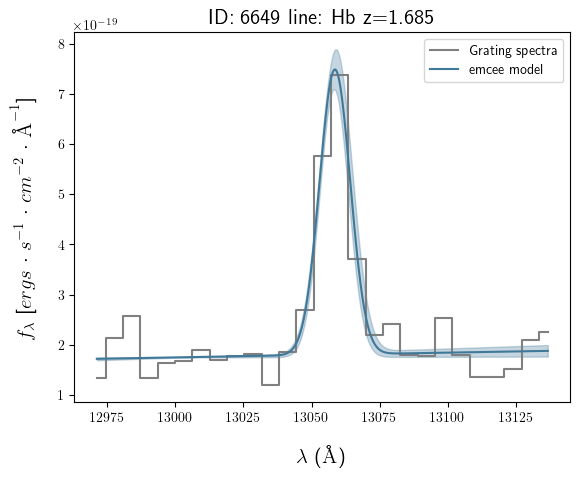

source #92


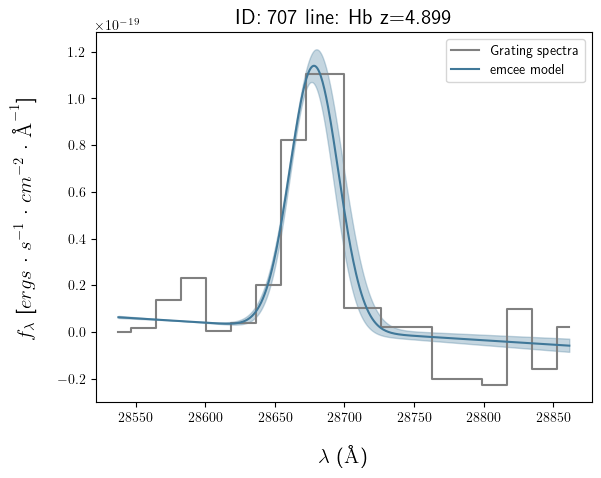

source #93


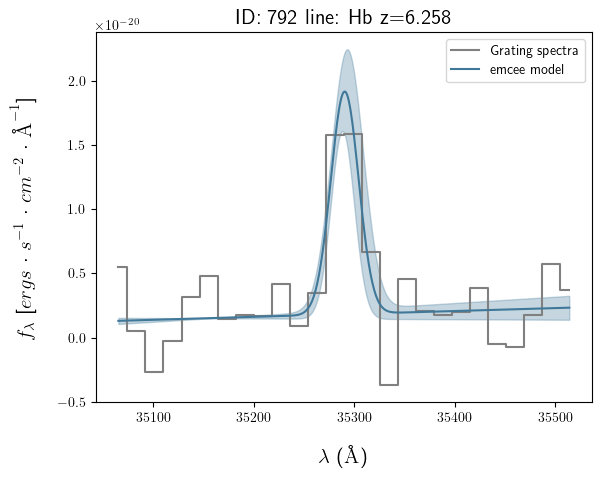

source #94


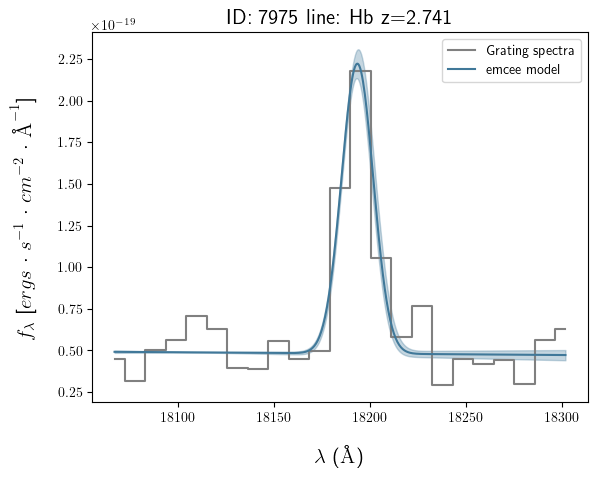

source #95


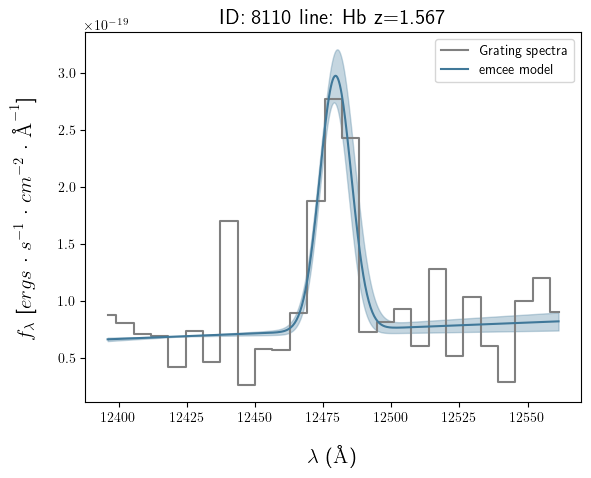

source #96


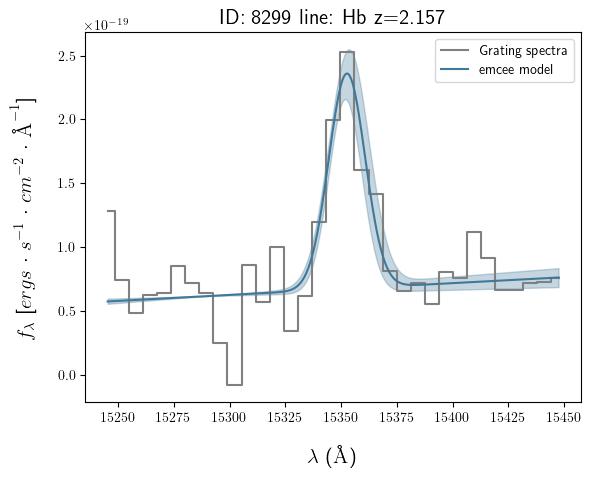

source #97


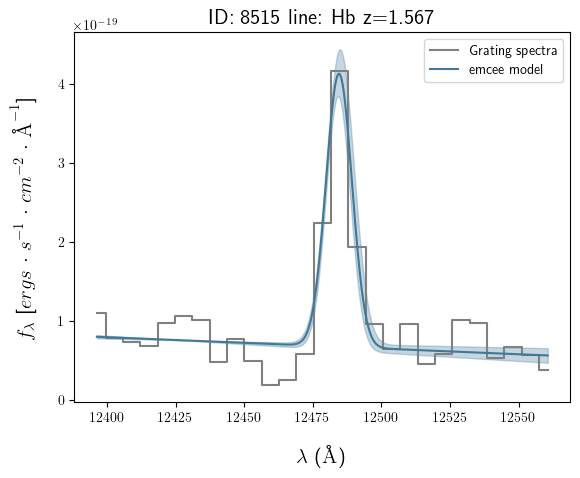

source #98


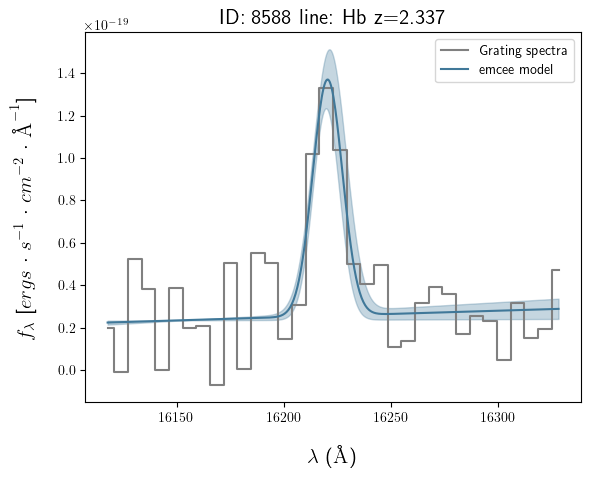

source #99


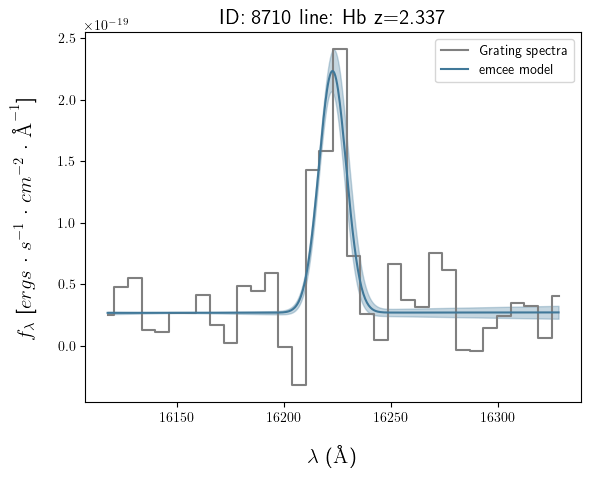

source #100


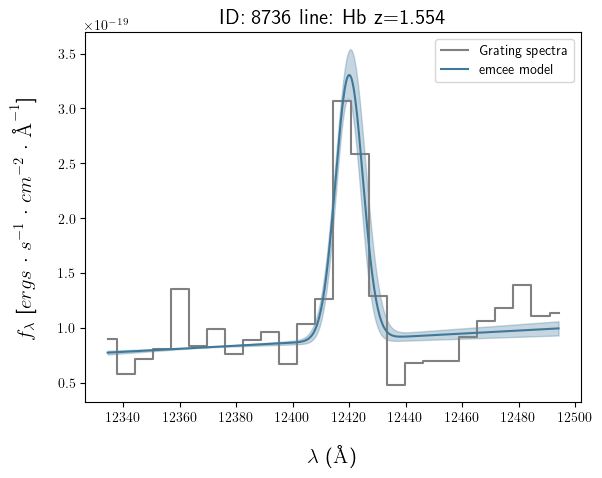

source #101


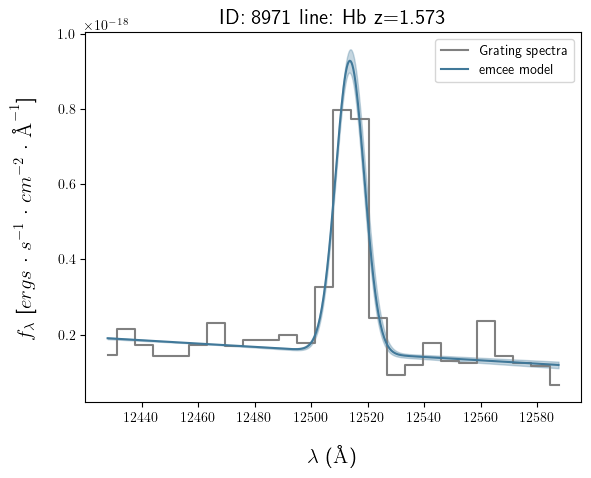

source #102


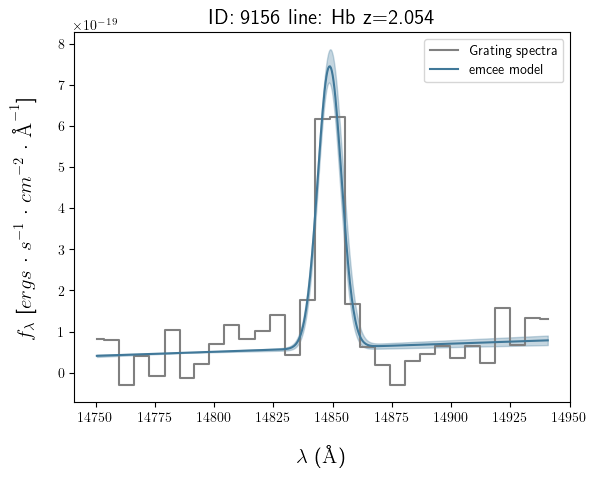

source #103


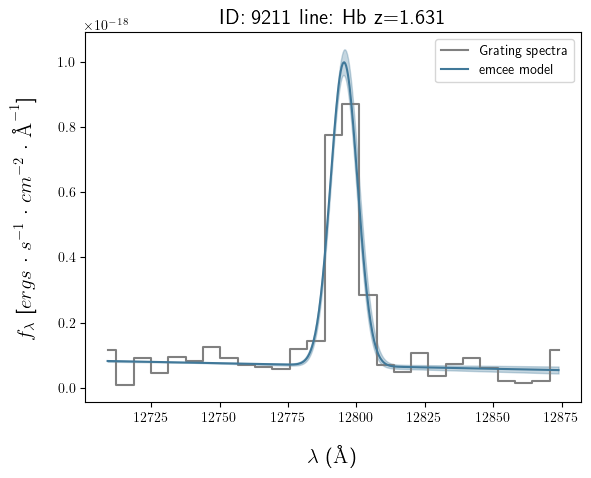

source #104


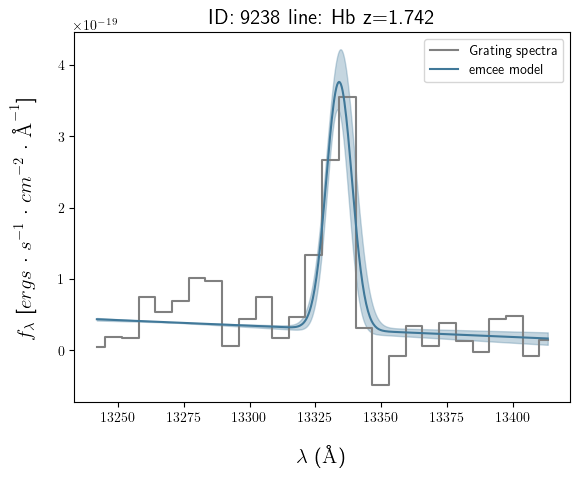

source #105
106 fitted sources


MSA_ID  Z_SPEC                                            samples  \
0  10293   1.676  [[[3.2448412012600488e-19, 12980.002400620528,...   
1  11088   3.303  [[[4.1807954353609326e-19, 20867.922356101695,...   
2   1115   6.300  [[[6.114894825207679e-20, 35483.36078172735, 1...   
3  11580   3.229  [[[3.876793467501316e-20, 20535.65103939111, 5...   
4  11699   3.301  [[[1.0123388000566607e-19, 20861.391449012455,...   

                                                wavs  \
0  [12924.83158885563, 12931.18707660346, 12937.5...   
1  [20781.375248616154, 20792.059394147815, 20802...   
2  [35296.60956186185, 35314.51383615961, 35332.4...   
3  [20424.5547322851, 20435.179357324007, 20445.8...   
4  [20779.573826390268, 20790.226186919248, 20800...   

                                              fluxes  \
0  [2.093621463433951e-19, 2.1301264273726526e-19...   
1  [3.0556917372716284e-20, 2.008141295608656e-20...   
2  [-9.471742910644879e-22, -4.742002929516749e-2...   
3  [1.3184496632590594e-20, 1.035865348496696e-20...   
4  [1.415001384927917e-20, 1.896449108065487e-20,...   

                                          fluxes_err  \
0  [2.1352597617089642e-20, 2.1243955804034532e-2...   
1  [5.9799408305948676e-21, 5.483229344001797e-21...   
2  [3.953952887071161e-21, 3.9070150976251074e-21...   
3  [4.637410541972724e-21, 4.835348636553751e-21,...   
4  [3.477061369354047e-21, 3.891564276824716e-21,...   

                                       median_params             A  \
0  [2.8033973043552613e-19, 13012.742551309204, 6...  2.803397e-19   
1  [3.9845475379248547e-19, 20918.820427383038, 1...  3.984548e-19   
2  [5.82369915199661e-20, 35499.985307570074, 15....  5.823699e-20   
3  [3.845092116770698e-20, 20559.76829056724, 8.7...  3.845092e-20   
4  [1.0293522894427635e-19, 20914.731100889676, 1...  1.029352e-19   

                                               A_err            mu      sigma  \
0  [2.812955829676414e-20, 2.7167690006104707e-20...  13012.742551   6.149392   
1  [9.663228474987305e-21, 9.256649401640787e-21,...  20918.820427  14.360958   
2  [9.666486082005636e-21, 7.137440950472053e-21,...  35499.985308  15.779177   
3  [9.370751334074191e-21, 7.80074414800357e-21, ...  20559.768291   8.773661   
4  [6.131057594295236e-21, 6.1085337906540035e-21...  20914.731101  14.292856   

                                           sigma_err  \
0  [0.5917205841106497, 0.6064571680691024, 0.576...   
1  [0.311614743734725, 0.3111347390504342, 0.3120...   
2  [3.052976191434297, 3.4618074383689788, 2.6441...   
3  [2.115674888238733, 2.1824479277635858, 2.0489...   
4  [0.7851428890342795, 0.7726629910728136, 0.797...   

                                    perc_16th_params  \
0  [2.5317204042942143e-19, 13012.127436558745, 5...   
1  [3.891981043908447e-19, 20918.6129459416, 14.0...   
2  [5.1099550569494047e-20, 35498.689481563706, 1...   
3  [3.065017701970341e-20, 20558.293581001664, 6....   
4  [9.682669515362235e-20, 20914.092412669383, 13...   

                                    perc_84th_params  
0  [3.094311570229497e-19, 13013.346333422542, 6....  
1  [4.085245613408193e-19, 20919.034406762123, 14...  
2  [7.043252273350532e-20, 35501.12714251282, 18....  
3  [4.939167968785179e-20, 20561.61101590929, 10....  
4  [1.0908881034221282e-19, 20915.334372782738, 1...

In [40]:
# intializing dataframe
columns = ['MSA_ID','Z_SPEC', 'samples', 'wavs','fluxes','fluxes_err','median_params','A','A_err','mu','sigma','sigma_err','perc_16th_params','perc_84th_params']
Hb_emcee_df = pd.DataFrame(columns=columns)

for source in range(len(NIRSpec_df['MSA_ID'])):
    try:
        new_row = final_fits_Hb_CEERS(source, Hb_curve_fit_df, NIRSpec_df['MSA_ID'][source], NIRSpec_df['Z_SPEC'][source], diagnose=True)

        # handle NaN values for amplitude
        if np.isnan(new_row[7]):
            print('NaN value for amplitude found:')
            print(new_row[2])  # printing best-fit parameters for source
        
        df_extended = pd.DataFrame(data=[new_row], columns=columns)
        Hb_emcee_df = pd.concat([Hb_emcee_df, df_extended],ignore_index=True)
        print(f'source #{source}')
    
    except Exception as e:
        print(f"Error processing source {source}: {e}")
        
Hb_emcee_df.to_pickle('../outputs/checkpoints/Hb_emcee_outputs_CEERS.pkl')
print(len(Hb_emcee_df),'fitted sources')
Hb_emcee_df.head()

In [41]:
NIRSpec_df.to_pickle('../outputs/checkpoints/CEERS_sample.pkl')

## MCMC fitting results

In [42]:
# redefining emcee output dataframes with saved files
Ha_emcee_df = pd.read_pickle('../outputs/checkpoints/Ha_emcee_outputs_CEERS.pkl')
Hb_emcee_df = pd.read_pickle('../outputs/checkpoints/Hb_emcee_outputs_CEERS.pkl')
NIRSpec_df = pd.read_pickle('../outputs/checkpoints/CEERS_sample.pkl')

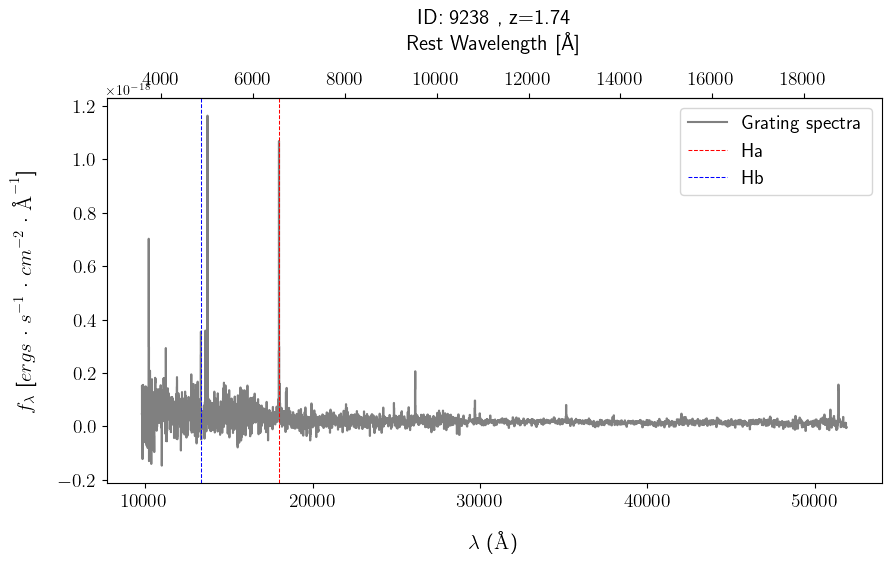

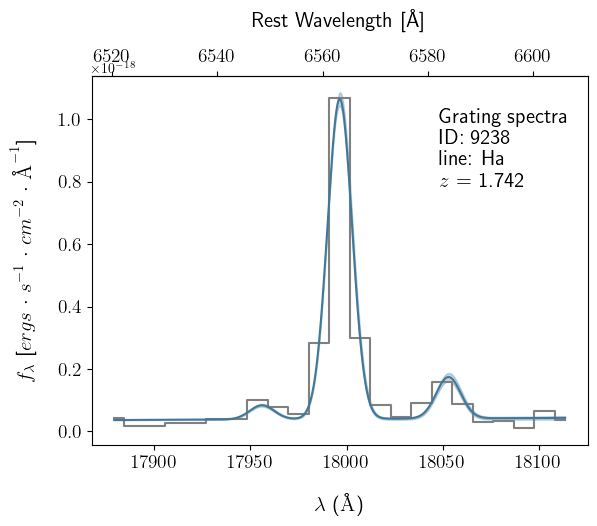

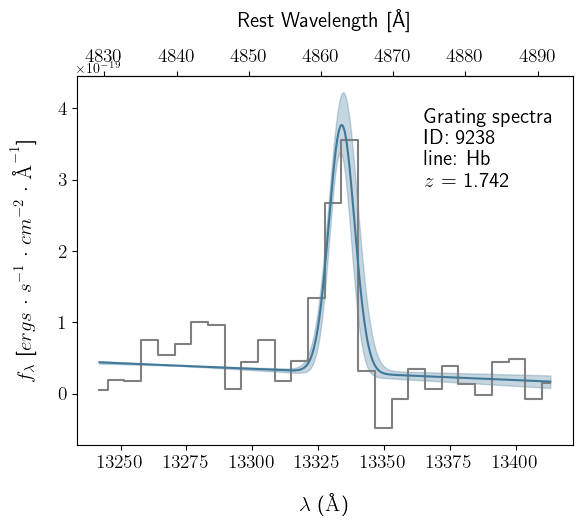

In [43]:
# source = int(NIRSpec_df[NIRSpec_df['MSA_ID'] == 8299].index[0])

source = 105
CEERS_specific_spectra_plotting_func(NIRSpec_df['MSA_ID'][source], wavs_cleaned[source], fluxes_cleaned[source], NIRSpec_df['Z_SPEC'][source], data_label='Grating spectra', data_color='grey', 
                                     loc_obs_emission_lines=[Ha_line_obs[source],Hb_line_obs[source]], line_center_idx=[Ha_center[source],Hb_center[source]], emission_line_labels=line_labels, emission_line_colors=line_colors,
                                     line_model_outputs=[Ha_emcee_df['median_params'][source],Hb_emcee_df['median_params'][source]], line_model_output_errs=[[Ha_emcee_df['perc_16th_params'][source],Hb_emcee_df['perc_16th_params'][source]],[Ha_emcee_df['perc_84th_params'][source],Hb_emcee_df['perc_84th_params'][source]]], fit='emcee')

# Calculating integrated line flux

In [44]:
Ha_flux_list = []
Ha_flux_err_list = []
Hb_flux_list = []
Hb_flux_err_list = []
NII_flux_list = []
NII_flux_err_list = []
SNR_Ha_list = []
SNR_Hb_list = []
SNR_NII_list = []
for source in range(len(NIRSpec_df)):

    line = 'Ha' # line which is getting dust corrected

    # integrated fluxes
    H1_integ_flux_obs = integrated_line_flux(Ha_emcee_df['A'][source],Ha_emcee_df['sigma'][source],Ha_emcee_df['A_err'][source][0],Ha_emcee_df['sigma_err'][source][0])[0]
    H2_integ_flux_obs = integrated_line_flux(Hb_emcee_df['A'][source],Hb_emcee_df['sigma'][source],Hb_emcee_df['A_err'][source][0],Hb_emcee_df['sigma_err'][source][0])[0]
    NII_integ_flux_obs = integrated_line_flux(Ha_emcee_df['A_NII'][source],Ha_emcee_df['sigma'][source],Ha_emcee_df['A_NII_err'][source][0],Ha_emcee_df['sigma_err'][source][0])[0]

    # [mean flux err, 16% flux err, 84% flux err]
    H1_integ_flux_obs_err = [integrated_line_flux(Ha_emcee_df['A'][source],Ha_emcee_df['sigma'][source],Ha_emcee_df['A_err'][source][0],Ha_emcee_df['sigma_err'][source][0])[1],
                            integrated_line_flux(Ha_emcee_df['A'][source],Ha_emcee_df['sigma'][source],Ha_emcee_df['A_err'][source][1],Ha_emcee_df['sigma_err'][source][1])[1],
                            integrated_line_flux(Ha_emcee_df['A'][source],Ha_emcee_df['sigma'][source],Ha_emcee_df['A_err'][source][2],Ha_emcee_df['sigma_err'][source][2])[1]
                           ]
    H2_integ_flux_obs_err = [integrated_line_flux(Hb_emcee_df['A'][source],Hb_emcee_df['sigma'][source],Hb_emcee_df['A_err'][source][0],Hb_emcee_df['sigma_err'][source][0])[1],
                            integrated_line_flux(Hb_emcee_df['A'][source],Hb_emcee_df['sigma'][source],Hb_emcee_df['A_err'][source][1],Hb_emcee_df['sigma_err'][source][1])[1],
                            integrated_line_flux(Hb_emcee_df['A'][source],Hb_emcee_df['sigma'][source],Hb_emcee_df['A_err'][source][2],Hb_emcee_df['sigma_err'][source][2])[1]
                            ]

    NII_integ_flux_obs_err = [integrated_line_flux(Ha_emcee_df['A_NII'][source],Ha_emcee_df['sigma'][source],Ha_emcee_df['A_NII_err'][source][0],Ha_emcee_df['sigma_err'][source][0])[1],
                            integrated_line_flux(Ha_emcee_df['A_NII'][source],Ha_emcee_df['sigma'][source],Ha_emcee_df['A_NII_err'][source][1],Ha_emcee_df['sigma_err'][source][1])[1],
                            integrated_line_flux(Ha_emcee_df['A_NII'][source],Ha_emcee_df['sigma'][source],Ha_emcee_df['A_NII_err'][source][2],Ha_emcee_df['sigma_err'][source][2])[1]
                           ]

    Ha_flux_list.append(H1_integ_flux_obs)
    Hb_flux_list.append(H2_integ_flux_obs)
    NII_flux_list.append(NII_integ_flux_obs)
    Ha_flux_err_list.append(H1_integ_flux_obs_err)
    Hb_flux_err_list.append(H2_integ_flux_obs_err)
    NII_flux_err_list.append(NII_integ_flux_obs_err)

    SNR_Ha_list.append(H1_integ_flux_obs/H1_integ_flux_obs_err[0])
    SNR_Hb_list.append(H2_integ_flux_obs/H2_integ_flux_obs_err[0])
    SNR_NII_list.append(NII_integ_flux_obs/NII_integ_flux_obs_err[0])


NIRSpec_df['H-ALPHA INTEGRATED FLUX OBSERVED 1'] = Ha_flux_list
NIRSpec_df['H-ALPHA INTEGRATED FLUX OBSERVED ERRORS 1'] = Ha_flux_err_list
NIRSpec_df['H-BETA INTEGRATED FLUX OBSERVED'] = Hb_flux_list
NIRSpec_df['H-BETA INTEGRATED FLUX OBSERVED ERRORS'] = Hb_flux_err_list
NIRSpec_df['NII INTEGRATED FLUX OBSERVED 1'] = NII_flux_list
NIRSpec_df['NII INTEGRATED FLUX OBSERVED ERRORS 1'] = NII_flux_err_list
NIRSpec_df['H-ALPHA EMISSION LINE SNR 1'] = SNR_Ha_list
NIRSpec_df['H-BETA EMISSION LINE SNR'] = SNR_Hb_list
NIRSpec_df['NII EMISSION LINE SNR 1'] = SNR_NII_list

NIRSpec_df.head()

MSA_ID  Z_SPEC          RA        DEC  H-ALPHA INTEGRATED FLUX OBSERVED 1  \
0   10293   1.676  214.872556  52.875949                        1.283886e-17   
1   11088   3.303  214.806482  52.878827                        5.644758e-17   
2    1115   6.300  214.828968  52.875701                        9.039415e-18   
3   11580   3.229  214.878534  52.874142                        2.302423e-18   
4   11699   3.301  214.867247  52.836737                        1.221464e-17   

           H-ALPHA INTEGRATED FLUX OBSERVED ERRORS 1  \
0  [9.456367150049997e-19, 9.35145349795999e-19, ...   
1  [9.306739945670776e-19, 9.332368167629408e-19,...   
2  [5.634632078384692e-19, 5.586776402653469e-19,...   
3  [2.296352480907879e-19, 2.2054270967651007e-19...   
4  [4.420155314959229e-19, 4.271631830639167e-19,...   

   H-BETA INTEGRATED FLUX OBSERVED  \
0                     4.321224e-18   
1                     1.434341e-17   
2                     2.303420e-18   
3                     8.456244e-19   
4                     3.687848e-18   

              H-BETA INTEGRATED FLUX OBSERVED ERRORS  \
0  [6.007497828732798e-19, 5.974794980298855e-19,...   
1  [4.667635126306483e-19, 4.556335573225162e-19,...   
2  [5.871967431395373e-19, 5.788553429858248e-19,...   
3  [2.899162629310918e-19, 2.7143748724630047e-19...   
4  [2.9881240811434286e-19, 2.960417320146532e-19...   

   NII INTEGRATED FLUX OBSERVED 1  \
0                    1.001028e-18   
1                    1.567245e-18   
2                    1.460480e-20   
3                    4.397961e-20   
4                    2.924671e-19   

               NII INTEGRATED FLUX OBSERVED ERRORS 1  \
0  [1.5170043900503811e-19, 1.4947297766846447e-1...   
1  [7.356176742686008e-20, 7.561563485628048e-20,...   
2  [1.7691553370147046e-20, 1.0750709615544922e-2...   
3  [3.3931129896720147e-20, 2.7845371162737894e-2...   
4  [4.2182146531885925e-20, 4.299575282930397e-20...   

   H-ALPHA EMISSION LINE SNR 1  H-BETA EMISSION LINE SNR  \
0                    13.576949                  7.193051   
1                    60.652369                 30.729497   
2                    16.042600                  3.922741   
3                    10.026436                  2.916789   
4                    27.633963                 12.341683   

   NII EMISSION LINE SNR 1  
0                 6.598716  
1                21.305154  
2                 0.825524  
3                 1.296143  
4                 6.933434

# Signal-to-noise cut

In [45]:
bad_Balmer_measurement = []
count_Ha_bad = 0
count_Hb_bad = 0
count_both_bad = 0
nan_values = 0
for source in range(len(NIRSpec_df)):
    SNR_Ha = NIRSpec_df['H-ALPHA EMISSION LINE SNR 1'][source]
    SNR_Hb = NIRSpec_df['H-BETA EMISSION LINE SNR'][source] 
    
    if (SNR_Ha < 3) or (SNR_Hb < 3) or np.isnan(SNR_Ha) or np.isnan(SNR_Hb):
        bad_Balmer_measurement.append(NIRSpec_df['MSA_ID'][source])   

    if (SNR_Ha < 3) and (SNR_Hb < 3):
        count_both_bad += 1
    
    elif SNR_Ha < 3:
        count_Ha_bad += 1

    elif SNR_Hb < 3:
        count_Hb_bad += 1

    if np.isnan(SNR_Ha) or np.isnan(SNR_Hb):
        nan_values += 1

print(str(nan_values)+' sources with nan values for either or both Balmer measurements')
print(str(count_both_bad) + ' sources with both Balmer measurements having SNR < 3')
print(str(count_Ha_bad)+' sources with Ha measurements having SNR < 3')
print(str(count_Hb_bad)+' sources with Hb measurements having SNR < 3')
print(str(len(bad_Balmer_measurement))+' TOTAL SOURCES to be dropped from dataframe')

0 sources with nan values for either or both Balmer measurements
0 sources with both Balmer measurements having SNR < 3
0 sources with Ha measurements having SNR < 3
13 sources with Hb measurements having SNR < 3
13 TOTAL SOURCES to be dropped from dataframe


In [46]:
msa_ids_to_drop = bad_Balmer_measurement 
NIRSpec_df = NIRSpec_df[~NIRSpec_df['MSA_ID'].isin(msa_ids_to_drop)]
NIRSpec_df = NIRSpec_df.reset_index(drop=True)
Ha_emcee_df = Ha_emcee_df[~Ha_emcee_df['MSA_ID'].isin(msa_ids_to_drop)]
Ha_emcee_df = Ha_emcee_df.reset_index(drop=True)
Hb_emcee_df = Hb_emcee_df[~Hb_emcee_df['MSA_ID'].isin(msa_ids_to_drop)]
Hb_emcee_df = Hb_emcee_df.reset_index(drop=True)
NIRSpec_df

MSA_ID  Z_SPEC          RA        DEC  H-ALPHA INTEGRATED FLUX OBSERVED 1  \
0    10293   1.676  214.872556  52.875949                        1.283886e-17   
1    11088   3.303  214.806482  52.878827                        5.644758e-17   
2     1115   6.300  214.828968  52.875701                        9.039415e-18   
3    11699   3.301  214.867247  52.836737                        1.221464e-17   
4     1173   4.997  214.876469  52.839412                        8.733280e-18   
..     ...     ...         ...        ...                                 ...   
88    8736   1.554  215.216724  53.057855                        1.224801e-17   
89    8971   1.573  215.049454  52.941954                        5.504314e-17   
90    9156   2.054  215.069889  53.007982                        3.642091e-17   
91    9211   1.631  215.043555  52.989917                        4.947052e-17   
92    9238   1.742  215.082111  52.998676                        2.317964e-17   

            H-ALPHA INTEGRATED FLUX OBSERVED ERRORS 1  \
0   [9.456367150049997e-19, 9.35145349795999e-19, ...   
1   [9.306739945670776e-19, 9.332368167629408e-19,...   
2   [5.634632078384692e-19, 5.586776402653469e-19,...   
3   [4.420155314959229e-19, 4.271631830639167e-19,...   
4   [3.409190745702183e-19, 3.362852083618552e-19,...   
..                                                ...   
88  [7.077468069404373e-19, 7.22206021420611e-19, ...   
89  [1.1784012254731335e-18, 1.159565679448654e-18...   
90  [1.1754723679832895e-18, 1.199574735351939e-18...   
91  [1.1715454757879098e-18, 1.1806461625761313e-1...   
92  [5.41678751289824e-19, 5.441184114454886e-19, ...   

    H-BETA INTEGRATED FLUX OBSERVED  \
0                      4.321224e-18   
1                      1.434341e-17   
2                      2.303420e-18   
3                      3.687848e-18   
4                      2.041776e-18   
..                              ...   
88                     4.134000e-18   
89                     1.395670e-17   
90                     1.214586e-17   
91                     1.632030e-17   
92                     5.989633e-18   

               H-BETA INTEGRATED FLUX OBSERVED ERRORS  \
0   [6.007497828732798e-19, 5.974794980298855e-19,...   
1   [4.667635126306483e-19, 4.556335573225162e-19,...   
2   [5.871967431395373e-19, 5.788553429858248e-19,...   
3   [2.9881240811434286e-19, 2.960417320146532e-19...   
4   [5.087450272732084e-19, 4.894350594120529e-19,...   
..                                                ...   
88  [5.105064189103502e-19, 5.074237984858947e-19,...   
89  [6.814813114672672e-19, 6.838340388484528e-19,...   
90  [9.336814472361432e-19, 9.154080612180779e-19,...   
91  [8.6745746669702e-19, 8.596701532358915e-19, 8...   
92  [1.037245619434916e-18, 1.0675100679726833e-18...   

    NII INTEGRATED FLUX OBSERVED 1  \
0                     1.001028e-18   
1                     1.567245e-18   
2                     1.460480e-20   
3                     2.924671e-19   
4                     2.431430e-19   
..                             ...   
88                    4.882845e-19   
89                    1.791010e-18   
90                    1.245569e-18   
91                    8.589207e-19   
92                    1.020305e-18   

                NII INTEGRATED FLUX OBSERVED ERRORS 1  \
0   [1.5170043900503811e-19, 1.4947297766846447e-1...   
1   [7.356176742686008e-20, 7.561563485628048e-20,...   
2   [1.7691553370147046e-20, 1.0750709615544922e-2...   
3   [4.2182146531885925e-20, 4.299575282930397e-20...   
4   [3.666704649348665e-20, 3.633475408653478e-20,...   
..                                                ...   
88  [8.082571697094502e-20, 8.252112748374023e-20,...   
89  [1.2727528872132445e-19, 1.2986494925016432e-1...   
90  [1.1482189890215397e-19, 1.1436873361016653e-1...   
91  [1.1262897418823297e-19, 1.0842183187977354e-1...   
92  [7.268248243120315e-20, 7.228584320051953e-20,...   

    H-ALPHA EMISSION LINE SNR 1  H-BETA EMISSION L

# Saving to final dataframe

In [47]:
# updating dataframe to match RUBIES one
NIRSpec_df['H-ALPHA INTEGRATED FLUX OBSERVED 2'] = [None] * len(NIRSpec_df)
NIRSpec_df['H-ALPHA INTEGRATED FLUX OBSERVED ERRORS 2'] = [[None]*3] * len(NIRSpec_df)
NIRSpec_df['H-ALPHA EMISSION LINE SNR 2'] = [None] * len(NIRSpec_df)
NIRSpec_df['NII INTEGRATED FLUX OBSERVED 2'] = [None] * len(NIRSpec_df)
NIRSpec_df['NII INTEGRATED FLUX OBSERVED ERRORS 2'] = [[None]*3] * len(NIRSpec_df)
NIRSpec_df['NII EMISSION LINE SNR 2'] = [None] * len(NIRSpec_df)

NIRSpec_df.sort_values(by=['MSA_ID'],inplace=True)
NIRSpec_df = NIRSpec_df.reset_index(drop=True)
NIRSpec_df.to_csv('../outputs/checkpoints/CEERS_sample_Balmer.csv',index=False)
NIRSpec_df

MSA_ID  Z_SPEC          RA        DEC  H-ALPHA INTEGRATED FLUX OBSERVED 1  \
0      323   5.667  215.125247  53.004816                        7.932235e-18   
1      355   6.100  215.151954  52.992771                        5.157415e-18   
2      403   5.761  214.885556  52.835043                        7.365268e-18   
3      603   6.058  215.032515  52.897511                        5.089498e-18   
4      618   6.051  215.126857  52.968083                        2.108497e-18   
..     ...     ...         ...        ...                                 ...   
88   26836   2.010  215.065999  52.998202                        8.206600e-18   
89   27063   1.594  214.966510  52.846668                        4.809851e-18   
90   27182   1.244  214.868125  52.838860                        9.692114e-18   
91   31075   1.284  215.035558  52.946681                        3.198289e-17   
92   37597   1.416  214.911170  52.843044                        1.355986e-17   

            H-ALPHA INTEGRATED FLUX OBSERVED ERRORS 1  \
0   [1.509446052715896e-18, 1.783647400861984e-18,...   
1   [2.883474949004915e-19, 2.916715726223796e-19,...   
2   [3.7542351754241184e-19, 3.6183125223190853e-1...   
3   [2.8508979826522456e-19, 2.84046902281898e-19,...   
4   [1.838034588505312e-19, 2.0048103859589382e-19...   
..                                                ...   
88  [3.947745191396921e-19, 3.875673554779894e-19,...   
89  [6.122306029340572e-19, 6.198940325200611e-19,...   
90  [4.828176316834833e-19, 4.875656804643873e-19,...   
91  [1.11744352665406e-18, 1.0987553861647834e-18,...   
92  [6.827972360173796e-19, 7.092424947516492e-19,...   

    H-BETA INTEGRATED FLUX OBSERVED  \
0                      3.126651e-18   
1                      1.628494e-18   
2                      1.855020e-18   
3                      1.676880e-18   
4                      5.010233e-19   
..                              ...   
88                     2.814792e-18   
89                     1.508161e-18   
90                     3.629079e-18   
91                     1.088689e-17   
92                     5.380554e-18   

               H-BETA INTEGRATED FLUX OBSERVED ERRORS  \
0   [2.2859472050993405e-19, 2.232394111866683e-19...   
1   [1.705331605177903e-19, 1.7110650761728058e-19...   
2   [2.265073059866181e-19, 2.2252486270943954e-19...   
3   [2.021790151866102e-19, 1.9925053988374692e-19...   
4   [1.6148598033389648e-19, 1.474633737852465e-19...   
..                                                ...   
88  [5.536086723666042e-19, 5.415966653492001e-19,...   
89  [4.81517128542958e-19, 4.44089290651773e-19, 5...   
90  [6.406813211872338e-19, 6.368301099867172e-19,...   
91  [8.011282613055063e-19, 7.757904732798016e-19,...   
92  [4.374944888678573e-19, 4.2126413358836018e-19...   

    NII INTEGRATED FLUX OBSERVED 1  \
0                     8.225984e-20   
1                     1.763519e-19   
2                     1.924182e-19   
3                     1.336858e-19   
4                     4.046936e-21   
..                             ...   
88                    1.432108e-19   
89                    1.766710e-19   
90                    9.818068e-20   
91                    6.008741e-20   
92                    9.260496e-20   

                NII INTEGRATED FLUX OBSERVED ERRORS 1  \
0   [3.5139648543841826e-20, 3.656487094656826e-20...   
1   [4.057831752557369e-20, 4.1817423799832757e-20...   
2   [5.0273774452855815e-20, 5.002328093774229e-20...   
3   [3.959617607040938e-20, 4.382274907053362e-20,...   
4   [9.520571398007035e-21, 3.694597582695611e-21,...   
..                                                ...   
88  [3.84254803225855e-20, 3.741884503425387e-20, ...   
89  [6.603299956244748e-20, 6.279582461456131e-20,...   
90  [5.189362410225953e-20, 5.1111876489115447e-20...   
91  [6.096081065506105e-20, 4.3651340422185287e-20...   
92  [7.267256162424546e-20, 5.830874683296045e-20,...   

    H-ALPHA EMISSION LINE SNR 1  H-BETA EMISSION L